In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit


D:\Anaconda3\envs\deep_learning\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
data_weather_encoded = pd.read_csv('data_weather_encoded.csv')


In [3]:
def create_lagged_features(df, window, target_column):
    lagged_df = df.copy()
    original_columns = df.columns.tolist()  # Get a list of all original columns

    # Create lagged features
    for i in range(1, window + 1):
        shifted_df = df.shift(i)
        shifted_df.columns = [f"{column}_lag{i}" for column in shifted_df.columns]
        lagged_df = pd.concat((lagged_df, shifted_df), axis=1)
    
    # Drop all current-day columns including the target column
    lagged_df.drop(columns=original_columns, inplace=True, errors='ignore')
    
    # Drop the first 'window' rows
    lagged_df = lagged_df.iloc[window:]
    return lagged_df




window = 20  # We will use the last 20 days of data as input features
target_column = "mean_temp"  # target variable
data_weather_encoded_lagged = create_lagged_features(data_weather_encoded, window, target_column)
y = data_weather_encoded[target_column].iloc[window:]  # Note that we need to start at line 'window'
X = data_weather_encoded_lagged
# Split training and test sets, in chronological order
split_index = int(0.8 * len(X))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Create a scaler object
scaler = MinMaxScaler()

# Convert y_train to numpy array and reshape, then normalize
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))


In [31]:
import torch
import numpy as np
from deap import base, creator, tools, algorithms
from skorch import NeuralNetRegressor
from sklearn.model_selection import cross_val_score
from pytorch_lightning import LightningModule, Trainer
from torch import nn

# Use the GPU if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define model
class MLP(LightningModule):
    def __init__(self, input_dim, hidden_size, dropout_rate):
        super(MLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, int(hidden_size)),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(int(hidden_size), 1),
        )

    def forward(self, X):
        return self.layer(X)

    def configure_optimizers(self, learning_rate=0.01):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

# create model
def create_model(hidden_size, dropout_rate, learning_rate):
    model = NeuralNetRegressor(
        MLP(input_dim=X_train.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate).to(device),
        max_epochs=10,
        optimizer=torch.optim.Adam,
        lr=learning_rate,
        device=device,
    )
    return model

# Define the fitness function
def fitness(individual):
    hidden_size, dropout_rate, learning_rate = individual
    
    # Modify parameter value
    hidden_size = max(1, int(hidden_size))
    dropout_rate = random.uniform(0, 1)
    learning_rate = max(0, learning_rate)
    
    model = create_model(hidden_size, dropout_rate, learning_rate)
    scores = cross_val_score(model, X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(), cv=3, scoring='neg_mean_squared_error', error_score='raise')
    return np.mean(scores),

def mutateAndClip(individual, indpb):
    # Apply Gaussian mutation
    tools.mutGaussian(individual, mu=0, sigma=0.2, indpb=indpb)

    # Clip the values
    individual[0] = max(1, individual[0])        # hidden_size
    individual[1] = np.clip(individual[1], 0, 1) # dropout_rate
    individual[2] = max(0, individual[2])        # learning_rate
    
    return individual,




# Create a fitness-maximizing multi-objective optimization problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define individuals and populations
toolbox = base.Toolbox()
toolbox.register("attr_hidden_size", lambda: np.random.randint(50, 500))
toolbox.register("attr_dropout_rate", np.random.rand)
toolbox.register("attr_learning_rate", lambda: 10**np.random.uniform(-4, -1))
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_hidden_size, toolbox.attr_dropout_rate, toolbox.attr_learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", mutateAndClip, indpb=0.1)



# Define crossover, mutation, selection operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness)

# Genetic Algorithm Parameters
pop_size = 50
cxpb = 0.5
mutpb = 0.2
ngen = 40

pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)




In [12]:
# run the genetic algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                   stats=stats, halloffame=hof, verbose=True)

print("Best individual is: ", hof[0])

  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  11819294.1246   339454.7897  2.3237
      2  2549200.7205   118295.7180  0.2679
      3  1277529.2364    41036.0243  0.2565
      4   633102.9422    16775.9877  0.2343
      5   325706.3323     5184.3985  0.2488
      6   168654.1203     9660.7830  0.2302
      7    93270.4059     2299.1895  0.3369
      8    55555.2798      674.1645  0.2492
      9    33913.7700      384.7395  0.2459
     10    22199.6193     1347.8375  0.2512
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  11514721.2720    93465.3792  0.2439
      2  2518113.3752    15775.9949  0.2452
      3  1294062.9037     7116.1304  0.2449
      4   615780.9662    45762.4751  0.2497
      5   317779.1446     3512.6023  0.2332
      6   166502.7392     2849.0123  0.2365
      7    91140.5756     4904.5778  0.2493
      8    51285.5752      893.8379  0.2479
      9    33504.5449     

      2        0.2818        0.2736  0.1635
      3        0.2815        0.2734  0.2082
      4        0.2812        0.2730  0.2082
      5        0.2809        0.2727  0.1842
      6        0.2805        0.2723  0.1910
      7        0.2801        0.2718  0.2061
      8        0.2796        0.2714  0.1974
      9        0.2791        0.2709  0.2088
     10        0.2786        0.2703  0.2077
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  10973713.7894        0.2598  0.1951
      2        0.2884        0.2597  0.2043
      3        0.2882        0.2595  0.2022
      4        0.2880        0.2593  0.1893
      5        0.2878        0.2591  0.2003
      6        0.2875        0.2588  0.2052
      7        0.2873        0.2586  0.2031
      8        0.2870        0.2583  0.2137
      9        0.2866        0.2579  0.1656
     10        0.2863        0.2576  0.1900
  epoch    train_loss    valid_loss     dur
-------  ------------  ------

      8        0.0300        0.0267  0.2264
      9        0.0300        0.0267  0.1882
     10        0.0300        0.0267  0.2032
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1155763815.8961   929107.9799  0.2211
      2  295025123.7205   342853.7204  0.1820
      3  82830961.1218    33468.9145  0.1971
      4  22303468.0495    43314.8929  0.2169
      5  5981064.8804     1734.1987  0.2143
      6  1331028.1526      685.2400  0.2153
      7   301842.2700      473.5020  0.2181
      8   105199.7813      269.9307  0.2172
      9    51565.1949      162.5786  0.2153
     10    31215.1355      138.9294  0.2184
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1112207793.6722  1153865.7764  0.2492
      2  279614240.4453   277261.2041  0.2290
      3  74511039.5176    43622.3162  0.2225
      4  19323805.3197     7543.8834  0.1979
      5  4878178.5762     3494.0983  0.2254
      

      2   600823.7182     1721.5997  0.2180
      3   837825.8469     1784.9477  0.2190
      4     2358.9807      147.9322  0.1740
      5      684.0782       22.2506  0.2003
      6      388.6158        8.2429  0.1604
      7      231.0242        6.4216  0.2103
      8      154.7241        3.7331  0.2153
      9      105.6482        2.3519  0.2072
     10       69.7566        1.7463  0.2171
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  44274967.0694   148574.6921  0.2159
      2  1283867.7120      946.4768  0.1816
      3   361926.2411      648.7952  0.2082
      4   123013.5417     1304.0708  0.2182
      5    51518.1895      404.1355  0.2188
      6    25501.0120      227.2854  0.2180
      7    14121.4604       89.1260  0.2062
      8     8141.9667       70.2291  0.1959
      9     5267.6874       54.2526  0.1911
     10     3391.5336       35.1840  0.2163
  epoch     train_loss    valid_loss     dur
-------  -------------  ----

      9      373.9128       13.0587  0.2602
     10      258.7996       10.3981  0.2681
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  27703058.4618   128061.3136  0.2966
      2   136291.4174     1352.5966  0.2567
      3    30322.6498      397.8330  0.2571
      4    10285.2203      153.8299  0.2527
      5     4305.2806       85.6010  0.2692
      6     2059.9520       81.5546  0.2676
      7     1153.8584       36.8896  0.2456
      8      672.5340       26.7237  0.2660
      9      416.9632       18.9837  0.2586
     10      280.1569       15.4109  0.2333
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  14545744954.6966        0.0400  0.2872
      2        0.0414        0.0393  0.2610
      3        0.0412        0.0393  0.2620
      4        0.0412        0.0393  0.2918
      5        0.0412        0.0393  0.2917
      6        0.0412        0.0393  0.3076
      7        0.

      6        0.6255        0.5940  0.3063
      7        0.6254        0.5939  0.3250
      8        0.6253        0.5939  0.3331
      9        0.6253        0.5938  0.3286
     10        0.6252        0.5937  0.3054
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  11917072.8649   122147.0016  0.3101
      2  3415097.9471    24068.7624  0.3051
      3  1274508.5361     6257.5345  0.2967
      4   496776.6997     7460.6492  0.2950
      5   216558.8321      650.1639  0.3052
      6   104429.3272      389.8297  0.3010
      7    56724.8486      620.0829  0.3074
      8    31435.4607     1984.9897  0.3002
      9    20567.8841      223.5156  0.2957
     10    12881.8723      120.1221  0.3006
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  10357827.0272   168864.6502  0.2909
      2  2796116.8185    24690.2889  0.2966
      3   882474.8950     2027.2760  0.2921
      4   318999.4221     

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  538786421.9450    29056.1290  0.2965
      2    33048.8528      319.1060  0.3072
      3      107.1595        0.0339  0.2849
      4        0.6936        0.1518  0.3056
      5        0.1711        0.1213  0.3041
      6        0.1695        0.1177  0.3045
      7        0.1686        0.1168  0.2991
      8        0.1721        0.1173  0.2966
      9        0.1702        0.1148  0.3018
     10        0.1714        0.1190  0.2975
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  561246146.6609    33633.6808  0.2983
      2    35106.5052      112.7446  0.3015
      3       71.1528        1.2570  0.2935
      4        0.7749        0.0540  0.2896
      5        0.1729        0.1005  0.2994
      6        0.1646        0.1030  0.2964
      7        0.1668        0.1024  0.2976
      8        0.1686        0.1053  0.2897
      9        0.166

  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  42202765.4354    15684.2278  0.2845
      2  4548593.8249     2725.6001  0.2865
      3   852442.5503     4503.1260  0.2885
      4   223904.2230      352.0073  0.2878
      5    78964.1062      187.8951  0.2760
      6    33541.9167      148.5518  0.2960
      7    16237.9083      117.5988  0.2981
      8     8869.8448       90.2363  0.3149
      9     5592.3451       65.9081  0.2946
     10     3644.4680       46.0083  0.2897
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  35402687.4249   175728.9073  0.2810
      2  3112748.3609     1287.6419  0.2999
      3   450122.0529     6006.1651  0.2936
      4   124422.6955     1090.0837  0.2904
      5    40011.6251      151.2649  0.2854
      6    16977.0639      126.2198  0.2969
      7     8390.0140       52.2286  0.2977
      8     4969.7506       47.7595  0.2892
      9     3062.1160     

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  967711080.2240        0.0796  0.2773
      2        0.0826        0.0787  0.2725
      3        0.0824        0.0787  0.2637
      4        0.0824        0.0787  0.2681
      5        0.0824        0.0787  0.2661
      6        0.0824        0.0786  0.2728
      7        0.0823        0.0786  0.3049
      8        0.0823        0.0786  0.2993
      9        0.0823        0.0786  0.2874
     10        0.0823        0.0786  0.2778
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  967359487.7330        0.0679  0.2688
      2        0.0805        0.0671  0.2712
      3        0.0804        0.0671  0.2636
      4        0.0803        0.0671  0.2685
      5        0.0803        0.0671  0.2675
      6        0.0803        0.0671  0.2779
      7        0.0803        0.0671  0.2662
      8        0.0803        0.0670  0.2620
      9        0.080

      9        0.0659        0.0574  0.2817
     10        0.0658        0.0574  0.2831
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  87711965.9938      995.6424  0.2766
      2  9498276.5396     1955.8413  0.2692
      3  1483590.8686      511.1270  0.2661
      4   252402.2039      165.9430  0.2689
      5    43746.9821       95.7843  0.2664
      6     9680.2258      101.7190  0.2717
      7     3582.8703       63.6587  0.2586
      8     1755.5251       44.6876  0.2605
      9     1098.0782       36.7497  0.2719
     10      701.9482       29.5195  0.2744
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  86707929.3061    86457.9852  0.2700
      2  9837493.1602     3347.8465  0.2673
      3  1508213.5119     1084.9482  0.2689
      4   242519.7625      196.5313  0.2664
      5    40501.7418      122.2277  0.2549
      6     7227.6454       87.5491  0.2597
      7     2367.5151     

      2    29349.4360       36.9184  0.1903
      3     4576.1475       63.2582  0.2121
      4     1379.6323       32.7512  0.1931
      5      558.8456       32.9823  0.1842
      6      274.7715       25.5761  0.1772
      7      158.8288       19.8208  0.1790
      8       97.3977       12.5676  0.1851
      9       60.4785        6.1853  0.1347
     10       38.8755        3.7890  0.1901
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  4227799.8855      435.9135  0.2041
      2    40579.5297      103.1733  0.1892
      3     5566.0876       43.0228  0.1780
      4     1721.8625       24.7842  0.1896
      5      695.6430       25.0656  0.1879
      6      346.1971       24.7236  0.1715
      7      209.9176       22.8444  0.1822
      8      129.6151       16.9351  0.1736
      9       84.2246       12.0611  0.1902
     10       54.1511        7.5891  0.1726
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

     10        0.0593        0.0516  0.2091
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  4361889.1317        0.2644  0.1961
      2        0.2722        0.2642  0.1941
      3        0.2717        0.2636  0.1830
      4        0.2711        0.2629  0.1920
      5        0.2703        0.2621  0.1946
      6        0.2695        0.2612  0.1939
      7        0.2686        0.2602  0.1941
      8        0.2675        0.2592  0.1940
      9        0.2664        0.2581  0.1941
     10        0.2652        0.2569  0.1921
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  4598239.7742        0.2352  0.1951
      2        0.2624        0.2350  0.1961
      3        0.2619        0.2345  0.1972
      4        0.2613        0.2339  0.1920
      5        0.2606        0.2332  0.2052
      6        0.2598        0.2324  0.1970
      7        0.2590        0.2316  0.1992
      8        0.2580        0.2

      5      561.8982      312.1934  0.1931
      6      228.7383      124.2622  0.2023
      7       88.8163       47.5768  0.2391
      8       33.2900       17.4813  0.2256
      9       12.0023        6.3771  0.2013
     10        4.5197        2.5123  0.2190
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5431563262.8280        0.0676  0.2401
      2        0.0700        0.0665  0.2543
      3        0.0698        0.0665  0.2545
      4        0.0698        0.0665  0.2694
      5        0.0698        0.0665  0.3078
      6        0.0698        0.0665  0.2866
      7        0.0698        0.0665  0.2901
      8        0.0697        0.0665  0.2957
      9        0.0697        0.0665  0.2935
     10        0.0697        0.0665  0.2736
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  3993592213.3856        0.0569  0.2594
      2        0.0678        0.0560  0.2806
      3       

      5        0.2161        0.1982  0.2010
      6        0.2160        0.1981  0.1912
      7        0.2159        0.1980  0.2042
      8        0.2158        0.1980  0.2001
      9        0.2157        0.1979  0.1861
     10        0.2156        0.1978  0.2030
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5146637858.3760        0.0715  0.2110
      2        0.0740        0.0704  0.1980
      3        0.0738        0.0704  0.2210
      4        0.0738        0.0704  0.2065
      5        0.0738        0.0704  0.2182
      6        0.0738        0.0704  0.2091
      7        0.0738        0.0703  0.2161
      8        0.0737        0.0703  0.2316
      9        0.0737        0.0703  0.2302
     10        0.0737        0.0703  0.2081
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  4847531241.4583        0.0607  0.2279
      2        0.0721        0.0597  0.2108
      3       

      6       36.0436        0.7184  0.2490
      7       19.4065        0.5213  0.2358
      8       10.8759        0.4437  0.2412
      9        6.7373        0.3787  0.2282
     10        4.0749        0.3505  0.2298
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  433379383.5308   222687.8872  0.2486
      2    57675.0072      172.5715  0.2121
      3      127.7548        1.1345  0.2401
      4       95.9202        7.6908  0.2503
      5       84.1584        7.8093  0.2347
      6       72.3305        6.4061  0.2218
      7       64.1337        5.3141  0.2461
      8       55.0716        5.1187  0.1783
      9       46.1194        4.0639  0.2151
     10       39.6737        3.2214  0.1946
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  424367185.0387   119507.2383  0.1963
      2    52163.4327     9915.0461  0.2257
      3     5890.1166     2235.2509  0.2301
      4     1598.661

      9        0.2128        0.1950  0.2007
     10        0.2127        0.1950  0.1972
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  2146043093.3721        0.1401  0.1980
      2        0.1449        0.1393  0.1935
      3        0.1447        0.1393  0.2053
      4        0.1447        0.1393  0.1722
      5        0.1447        0.1392  0.1869
      6        0.1446        0.1392  0.2153
      7        0.1446        0.1391  0.1851
      8        0.1445        0.1391  0.2236
      9        0.1445        0.1390  0.1913
     10        0.1444        0.1390  0.2082
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1387959132.7526        0.0597  0.1993
      2        0.0711        0.0588  0.2092
      3        0.0709        0.0588  0.1841
      4        0.0708        0.0588  0.2070
      5        0.0708        0.0587  0.1679
      6        0.0708        0.0587  0.1715
      7       

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  851191527.7758        0.3963  0.1829
      2        0.4336        0.3984  0.2032
      3        0.4340        0.3983  0.1989
      4        0.4339        0.3982  0.2341
      5        0.4338        0.3981  0.2291
      6        0.4336        0.3980  0.2162
      7        0.4335        0.3978  0.2101
      8        0.4333        0.3977  0.2056
      9        0.4332        0.3975  0.2071
     10        0.4330        0.3973  0.1921
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  943438054.7095        0.3989  0.2260
      2        0.4264        0.4010  0.2101
      3        0.4268        0.4010  0.2031
      4        0.4267        0.4009  0.1953
      5        0.4266        0.4008  0.2120
      6        0.4264        0.4006  0.1882
      7        0.4263        0.4005  0.2001
      8        0.4262        0.4003  0.2092
      9        0.426

      8        0.0675        0.0559  0.2350
      9        0.0675        0.0558  0.1881
     10        0.0675        0.0558  0.2320
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  8275392921.7143        0.0579  0.2039
      2        0.0657        0.0571  0.2123
      3        0.0655        0.0571  0.2121
      4        0.0655        0.0571  0.2182
      5        0.0655        0.0571  0.2131
      6        0.0655        0.0571  0.2012
      7        0.0655        0.0571  0.1552
      8        0.0655        0.0571  0.2010
      9        0.0655        0.0571  0.2054
     10        0.0655        0.0571  0.2237
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  366471780.6686        0.2465  0.2192
      2        0.2524        0.2456  0.2191
      3        0.2522        0.2456  0.2238
      4        0.2521        0.2455  0.2154
      5        0.2521        0.2455  0.2207
      6        0.

      2        0.2160        0.1914  0.1922
      3        0.2158        0.1914  0.2102
      4        0.2157        0.1913  0.2002
      5        0.2157        0.1913  0.2110
      6        0.2156        0.1912  0.2092
      7        0.2155        0.1911  0.2092
      8        0.2155        0.1910  0.2986
      9        0.2154        0.1910  0.2828
     10        0.2153        0.1909  0.2796
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  312348399.7720        0.1924  0.2806
      2        0.2092        0.1914  0.2875
      3        0.2089        0.1914  0.2385
      4        0.2088        0.1913  0.2132
      5        0.2088        0.1913  0.2396
      6        0.2087        0.1912  0.2302
      7        0.2087        0.1911  0.2248
      8        0.2086        0.1910  0.2489
      9        0.2085        0.1910  0.2261
     10        0.2084        0.1909  0.2353
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.5979        0.5680  0.2627
      3        0.5987        0.5680  0.2616
      4        0.5987        0.5679  0.2412
      5        0.5986        0.5678  0.2587
      6        0.5985        0.5678  0.2546
      7        0.5985        0.5677  0.2191
      8        0.5984        0.5676  0.2310
      9        0.5983        0.5675  0.1941
     10        0.5982        0.5675  0.1501
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  165700874.8630        0.3431  0.1216
      2        0.3528        0.3438  0.1930
      3        0.3529        0.3438  0.2041
      4        0.3528        0.3437  0.1480
      5        0.3527        0.3436  0.1925
      6        0.3526        0.3435  0.1855
      7        0.3525        0.3434  0.2092
      8        0.3524        0.3433  0.2013
      9        0.3523        0.3431  0.1686
     10        0.3521        0.3430  0.2070
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      5        0.2453        0.2378  0.2426
      6        0.2452        0.2378  0.2221
      7        0.2452        0.2378  0.2298
      8        0.2452        0.2377  0.2146
      9        0.2451        0.2377  0.1911
     10        0.2451        0.2376  0.2220
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  661965792.2222     1777.2548  0.2316
      2       62.6203        0.2146  0.2002
      3        0.2404        0.2145  0.2153
      4        0.2404        0.2145  0.2376
      5        0.2404        0.2145  0.2561
      6        0.2404        0.2144  0.2449
      7        0.2403        0.2144  0.2412
      8        0.2403        0.2144  0.3136
      9        0.2402        0.2143  0.2757
     10        0.2402        0.2143  0.2567
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  651690059.0559        0.2181  0.2712
      2        0.2361        0.2172  0.2734
      3        0.235

      9     4769.8332      144.6386  0.1850
     10     3785.1317      145.0817  0.1883
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  44102852.0540   151655.0514  0.1818
      2    54231.7621      658.8531  0.2058
      3    23133.3204      383.3586  0.2048
      4    17919.1133      204.1899  0.2044
      5    13759.2099      315.2874  0.2029
      6    10944.9030      201.4197  0.1559
      7     8434.0704      202.7302  0.1921
      8     6365.5863      190.7879  0.2199
      9     4942.4456      260.9501  0.1912
     10     3675.7784      169.9014  0.2154
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  43737308.7298   553645.1642  0.2050
      2   120443.0493     3899.6370  0.2031
      3    22729.1678      180.9753  0.2011
      4    18193.3043      185.7180  0.2072
      5    14300.6171      256.2825  0.2052
      6    11209.3208      170.1035  0.2201
      7     8795.3449     

      2  27103470.8769  24597257.4907  0.1825
      3  27305176.9301  24597257.4907  0.1841
      4  26936041.3185  24597257.4907  0.1973
      5  27138449.7279  24597257.4907  0.1921
      6  27012656.9808  24597257.4907  0.2028
      7  26808875.3865  24597257.4907  0.1943
      8  27229512.1979  24597257.4907  0.2062
      9  27032571.0365  24597257.4907  0.2071
     10  27342832.8324  24597257.4907  0.2109
  epoch     train_loss     valid_loss     dur
-------  -------------  -------------  ------
      1  27381318.5405  24597257.4907  0.2052
      2  27247675.2356  24597257.4907  0.2171
      3  26726422.0730  24597257.4907  0.1963
      4  27019146.6382  24597257.4907  0.2210
      5  27302710.2944  24597257.4907  0.2082
      6  27581425.9085  24597257.4907  0.1981
      7  26954499.2826  24597257.4907  0.1953
      8  27036348.9536  24597257.4907  0.2303
      9  27368108.9796  24597257.4907  0.2087
     10  27184823.1354  24597257.4907  0.2101
  epoch        train_loss    valid

      7        4.3721        0.6869  0.2233
      8        0.7205        0.6863  0.2471
      9        0.7198        0.6857  0.2723
     10        0.7192        0.6850  0.2321
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5522542226.9878        0.7292  0.1975
      2        0.7473        0.7348  0.2266
      3        0.7484        0.7348  0.1828
      4        0.7483        0.7346  0.2010
      5        0.7481        0.7345  0.1706
      6        0.7479        0.7343  0.1740
      7        0.7478        0.7341  0.1991
      8        0.7476        0.7339  0.1812
      9        0.7473        0.7336  0.1635
     10        0.7471        0.7334  0.1710
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  720049823.4632        0.0704  0.1863
      2        0.0831        0.0693  0.1613
      3        0.0829        0.0693  0.1965
      4        0.0828        0.0693  0.1566
      5        0.

      3        0.3567        0.3475  0.1772
      4        0.3566        0.3474  0.1722
      5        0.3565        0.3473  0.1776
      6        0.3564        0.3472  0.2305
      7        0.3563        0.3471  0.2331
      8        0.3561        0.3469  0.2391
      9        0.3560        0.3468  0.2176
     10        0.3558        0.3466  0.2142
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  98881087.9167        0.3290  0.1835
      2        0.3626        0.3307  0.1591
      3        0.3629        0.3306  0.2022
      4        0.3628        0.3306  0.2043
      5        0.3627        0.3305  0.2121
      6        0.3626        0.3304  0.2102
      7        0.3625        0.3302  0.2157
      8        0.3623        0.3301  0.2102
      9        0.3622        0.3300  0.1961
     10        0.3620        0.3298  0.1970
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  99094990.5925     

      2        0.0330        0.0277  0.6435
      3        0.0329        0.0277  0.5790
      4        0.0329        0.0277  0.8111
      5        0.0329        0.0277  0.7636
      6        0.0328        0.0277  0.8416
      7        0.0328        0.0276  0.8310
      8        0.0328        0.0276  0.5155
      9        0.0328        0.0276  0.7610
     10        0.0328        0.0276  0.6605
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1040992550.4195        0.2865  0.9316
      2        0.3213        0.2850  1.0051
      3        0.3065        0.2848  0.8206
      4        0.3062        0.2844  0.8740
      5        0.3059        0.2841  0.6935
      6        0.3054        0.2837  0.6555
      7        0.3050        0.2832  0.7900
      8        0.3045        0.2827  0.6570
      9        0.3040        0.2822  0.8071
     10        0.3034        0.2816  0.7035
  epoch      train_loss    valid_loss     dur
-------  ------------

  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  46734903.7457        0.2235  0.2895
      2        0.2499        0.2234  0.2855
      3        0.2498        0.2233  0.3850
      4        0.2497        0.2232  0.2975
      5        0.2496        0.2231  0.2945
      6        0.2495        0.2230  0.3890
      7        0.2494        0.2229  0.3095
      8        0.2492        0.2227  0.2875
      9        0.2491        0.2226  0.3045
     10        0.2489        0.2224  0.2935
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  34818437.1670        0.2258  0.2885
      2        0.2449        0.2257  0.2775
      3        0.2448        0.2256  0.3755
      4        0.2447        0.2255  0.2775
      5        0.2445        0.2254  0.2755
      6        0.2444        0.2252  0.2815
      7        0.2442        0.2250  0.2790
      8        0.2440        0.2249  0.2665
      9        0.2439     

      8       26.1795        0.4526  0.2452
      9       21.3192        0.5907  0.2470
     10       17.1039        0.5799  0.2470
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  438077128.0519      943.9560  0.2202
      2     2712.9828     1843.6955  0.2583
      3     1193.3827      579.8251  0.2449
      4      365.9616      169.9402  0.2191
      5      103.1053       43.9060  0.2256
      6       24.9992        9.8052  0.2514
      7        5.2707        1.8575  0.2577
      8        0.9637        0.3087  0.2956
      9        0.1706        0.0611  0.2823
     10        0.0527        0.0285  0.2630
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  433503868.3754    15324.9293  0.2707
      2    12788.2849     3352.1169  0.3035
      3     1256.2025      194.6235  0.2694
      4       64.1431        5.9083  0.2510
      5        1.6074        0.0818  0.2985
      6        0.047

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  206121915.1775        0.2617  0.3210
      2        0.4144        0.2612  0.3244
      3   162065.1673        0.2659  0.3220
      4        0.2947        0.2656  0.2819
      5        0.2944        0.2653  0.3652
      6        0.2940        0.2649  0.3608
      7        0.2935        0.2644  0.3513
      8        0.2930        0.2639  0.3334
      9        0.2925        0.2634  0.3014
     10        0.2919        0.2628  0.2718
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  224116142.8034        0.3205  0.3114
      2        1.0655        0.3158  0.3101
      3        0.3387        0.3156  0.2948
      4        0.3385        0.3154  0.3084
      5        0.3383        0.3152  0.2996
      6        0.3382        0.3152  0.3257
      7        0.3379        0.3150  0.2785
      8        0.3376        0.3147  0.3308
      9        0.337

      2        0.0848        0.0708  0.2567
      3        0.0846        0.0708  0.2514
      4        0.0846        0.0708  0.2567
      5        0.0846        0.0708  0.2638
      6        0.0846        0.0708  0.2540
      7        0.0845        0.0708  0.2478
      8        0.0845        0.0708  0.2524
      9        0.0845        0.0708  0.2448
     10        0.0845        0.0708  0.2551
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  12344136265.9641        0.0720  0.2382
      2        0.0810        0.0710  0.2151
      3        0.0808        0.0710  0.2501
      4        0.0808        0.0710  0.2556
      5        0.0808        0.0710  0.2362
      6        0.0808        0.0710  0.2427
      7        0.0808        0.0710  0.2551
      8        0.0808        0.0710  0.2839
      9        0.0808        0.0710  0.2818
     10        0.0808        0.0710  0.2689
  epoch      train_loss    valid_loss     dur
-------  ---------

      8        1.2767        1.2144  0.2744
      9        1.2764        1.2142  0.2869
     10        1.2761        1.2139  0.2847
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  22643982659.9580        1.2037  0.3030
      2        1.2566        1.2137  0.3211
      3        1.2586        1.2137  0.3169
      4        1.2585        1.2135  0.3180
      5        1.2583        1.2133  0.3089
      6        1.2581        1.2131  0.3275
      7        1.2579        1.2128  0.3173
      8        1.2576        1.2126  0.3186
      9        1.2573        1.2123  0.3266
     10        1.2570        1.2120  0.3126
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  394719981.0128   332899.3023  0.2860
      2    56077.3296       39.1162  0.3511
      3      402.7722        2.2005  0.3101
      4      113.4268        4.0221  0.3406
      5       54.1312        0.9416  0.3339
      6       

      7        0.4412        0.4148  0.1216
      8        0.4408        0.4144  0.1892
      9        0.4404        0.4140  0.1774
     10        0.4400        0.4136  0.1417
3  	35    	-5.347  	34.1627    	-244.383    	-0.0272962
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  2491722677.5187        0.0438  0.2351
      2        0.0450        0.0427  0.2130
      3        0.0448        0.0426  0.2022
      4        0.0448        0.0426  0.2192
      5        0.0447        0.0426  0.1770
      6        0.0447        0.0426  0.2162
      7        0.0447        0.0426  0.2169
      8        0.0447        0.0425  0.2180
      9        0.0446        0.0425  0.2182
     10        0.0446        0.0425  0.2161
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  2823823817.5220        0.2901  0.2181
      2        0.3203        0.2897  0.2143
      3        0.3220        0.2898  0.2061
  

      8       73.7672        1.2333  0.2241
      9       20.8653        0.5923  0.2309
     10        4.9313        0.2764  0.2003
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  58018642.8681      955.5298  0.2002
      2      767.5284       49.7922  0.1914
      3      246.9514       23.5362  0.2187
      4      148.6738       12.9461  0.2186
      5       99.3129        7.0250  0.2061
      6       60.8398        4.1165  0.2263
      7       43.6228        2.4234  0.2151
      8       31.4543        1.4853  0.1937
      9       22.6047        0.9544  0.1937
     10       17.0492        0.6241  0.2212
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  39010537.5228        9.1469  0.2411
      2      219.8775       19.4547  0.2301
      3       57.1920        2.4403  0.2316
      4       24.7338        0.6092  0.2355
      5       17.4091        0.3582  0.2667
      6       12.1579     

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  2797871.2981    26668.0153  0.1555
      2   138149.3664     3560.4876  0.1925
      3    18897.7197      274.2159  0.1883
      4     3352.6010       95.5603  0.1930
      5     1129.7206       31.3818  0.1981
      6      560.1657       20.9015  0.1973
      7      361.3996       17.9566  0.1958
      8      226.4419       13.0861  0.1995
      9      154.5702        9.7834  0.1958
     10      103.6787        6.1877  0.1928
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  3391091.1652    98914.8791  0.1980
      2   199185.8120     3836.2289  0.1875
      3    24775.6386      248.2396  0.1592
      4     5590.7462      188.0086  0.1771
      5     1765.2432       63.9804  0.1891
      6      764.3362       35.3446  0.1687
      7      450.9820       27.2629  0.1932
      8      301.1169       23.5618  0.1999
      9      212.8164       19.6

     10        0.6867        0.6537  0.2687
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  233334674.8348        0.3048  0.2779
      2        0.3130        0.3044  0.2865
      3        0.3128        0.3043  0.2789
      4        0.3128        0.3043  0.2745
      5        0.3127        0.3042  0.2971
      6        0.3127        0.3041  0.3172
      7        0.3126        0.3041  0.2986
      8        0.3125        0.3040  0.3372
      9        0.3124        0.3039  0.3138
     10        0.3123        0.3038  0.3124
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  296676202.1394        0.3130  0.2805
      2        0.3444        0.3130  0.2822
      3        0.3444        0.3129  0.2854
      4        0.3443        0.3129  0.2936
      5        0.3443        0.3128  0.2927
      6        0.3442        0.3128  0.2801
      7        0.3441        0.3127  0.2634
      8        0.344

      9        0.1205        0.1077  0.3006
     10        0.1205        0.1077  0.3501
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  419058090.5482   157494.0782  0.2762
      2   137931.4693     2409.6402  0.2629
      3    11135.4753       53.3319  0.2674
      4      967.4525       35.1940  0.2876
      5       85.0027       15.4120  0.3031
      6        4.3769        0.3120  0.2949
      7        0.4442        0.1295  0.2872
      8        0.2797        0.0844  0.2985
      9        0.2063        0.0644  0.2951
     10        0.1544        0.0534  0.3038
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  420180486.9291   194001.0678  0.3026
      2    23351.6533      248.6779  0.3015
      3       95.3277        3.8242  0.2893
      4        1.4861        0.0509  0.3593
      5        0.0549        0.0236  0.2959
      6        0.0507        0.0237  0.2813
      7        0.051

      3        0.6281        0.6157  0.2582
      4        0.6281        0.6156  0.2724
      5        0.6280        0.6156  0.2564
      6        0.6280        0.6156  0.2632
      7        0.6279        0.6155  0.2616
      8        0.6279        0.6155  0.2751
      9        0.6278        0.6154  0.2777
     10        0.6277        0.6153  0.2851
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  33382142483.8298        0.5738  0.2876
      2        0.6197        0.5776  0.3022
      3        0.6205        0.5776  0.2748
      4        0.6205        0.5776  0.2528
      5        0.6205        0.5775  0.2939
      6        0.6204        0.5775  0.2717
      7        0.6204        0.5774  0.3029
      8        0.6203        0.5774  0.2718
      9        0.6203        0.5773  0.2778
     10        0.6202        0.5773  0.2712
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  334

      2        0.3946        0.3609  0.2800
      3        0.3947        0.3609  0.2783
      4        0.3947        0.3608  0.2576
      5        0.3946        0.3608  0.2676
      6        0.3946        0.3607  0.2743
      7        0.3945        0.3606  0.2774
      8        0.3945        0.3606  0.3050
      9        0.3944        0.3605  0.2844
     10        0.3943        0.3604  0.2793
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  387643283.2352        0.3556  0.2776
      2        0.3809        0.3568  0.2765
      3        0.3811        0.3568  0.2967
      4        0.3811        0.3567  0.2596
      5        0.3810        0.3567  0.2849
      6        0.3810        0.3566  0.2661
      7        0.3809        0.3565  0.2651
      8        0.3808        0.3565  0.2741
      9        0.3808        0.3564  0.2824
     10        0.3807        0.3563  0.2739
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      7        0.0575        0.0479  0.2238
      8        0.9108        0.0472  0.2123
      9        0.0573        0.0471  0.1919
     10        0.0572        0.0470  0.2124
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  12829615297.6946        0.7165  0.2110
      2        0.7587        0.7245  0.1895
      3        0.7601        0.7241  0.2019
      4        0.7595        0.7235  0.1875
      5        0.7589        0.7228  0.2093
      6        0.7581        0.7220  0.2073
      7        0.7573        0.7212  0.2116
      8        0.7564        0.7202  0.2034
      9        0.7554        0.7192  0.2072
     10        0.7543        0.7182  0.2145
4  	29    	-575249 	4.02674e+06	-2.87624e+07	-0.0272962
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  14584845.5054        0.2576  0.1918
      2        0.2652        0.2574  0.1972
      3        0.2651        0.2573  0.1663
     

      2  2104555.7800    44904.4758  0.3259
      3  1202581.4323     4346.9274  0.3290
      4   715012.0275     3690.6943  0.2852
      5   417371.3260    17878.7125  0.2698
      6   217057.3553     3597.3467  0.2749
      7   119525.7157     3533.5793  0.2721
      8    64744.9616     2284.0686  0.2788
      9    38890.4091     5738.5566  0.2738
     10    22304.7487      552.2774  0.2648
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  10916587.8870    14701.8386  0.2761
      2  2044969.1869     2402.8663  0.2800
      3  1259666.0855    20959.4642  0.2705
      4   670166.6155    12285.2215  0.2738
      5   362387.4002     2301.9892  0.3303
      6   202037.6009    20578.2186  0.3206
      7   124449.7114     2094.8089  0.2760
      8    65117.3913     4033.7078  0.2801
      9    34961.1385     1513.1627  0.2855
     10    20719.7913      786.6390  0.2787
  epoch       train_loss    valid_loss     dur
-------  ---------------  

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  262968660.0744        0.3208  0.2491
      2        0.3530        0.3211  0.2579
      3        0.3530        0.3211  0.2403
      4        0.3530        0.3210  0.2282
      5        0.3529        0.3210  0.2258
      6        0.3528        0.3209  0.1901
      7        0.3597        0.3208  0.2372
      8        0.3527        0.3207  0.2043
      9        0.3526        0.3206  0.2382
     10        0.3525        0.3205  0.2167
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  286635125.3796     2708.6398  0.2181
      2    15357.8975      161.9315  0.1942
      3      605.1223       19.1243  0.1916
      4       93.8762        3.8705  0.2005
      5       13.3563        1.0622  0.1756
      6        1.9972        0.4092  0.2187
      7        0.4539        0.2626  0.2058
      8        0.2931        0.2205  0.1608
      9        0.283

      9        0.4451        0.4346  0.2914
     10        0.4448        0.4343  0.2916
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  757114210.7433        0.2191  0.2855
      2        0.2453        0.2191  0.2840
      3        0.2452        0.2190  0.2822
      4        0.2451        0.2189  0.2732
      5        0.2451        0.2188  0.2878
      6        0.2450        0.2188  0.2929
      7        0.2449        0.2187  0.2906
      8        0.2448        0.2185  0.2898
      9        0.2446        0.2184  0.2766
     10        0.2445        0.2183  0.2836
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  316838343.8090   923756.3931  0.2820
      2   126802.1018      259.3516  0.2774
      3      531.8402        5.8469  0.2813
      4        2.8884        0.0968  0.2805
      5        0.0504        0.0267  0.2675
      6        0.0341        0.0284  0.2860
      7        0.034

      5        0.1276        0.1226  0.2329
      6        0.1276        0.1225  0.2382
      7        0.1275        0.1225  0.2556
      8        0.1275        0.1224  0.2443
      9        0.1274        0.1223  0.2472
     10        0.1273        0.1223  0.2440
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  764600655.1603        0.1105  0.2404
      2        0.1272        0.1090  0.2367
      3        0.1269        0.1090  0.2392
      4        0.1268        0.1089  0.2330
      5        0.1268        0.1089  0.2430
      6        0.1267        0.1088  0.2389
      7        0.1267        0.1088  0.2478
      8        0.1266        0.1087  0.2428
      9        0.1265        0.1086  0.2574
     10        0.1264        0.1086  0.2411
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  847225041.1308        0.1074  0.2923
      2        0.1188        0.1058  0.2414
      3        0.118

      6        0.0533        0.0507  0.3115
      7        0.0533        0.0507  0.2927
      8        0.0533        0.0507  0.3023
      9        0.0533        0.0507  0.3019
     10        0.0533        0.0507  0.2978
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  30158162585.5171        0.0510  0.2886
      2        0.0611        0.0502  0.2850
      3        0.0609        0.0502  0.3040
      4        0.0609        0.0502  0.3180
      5        0.0609        0.0502  0.3823
      6        0.0609        0.0502  0.3097
      7        0.0609        0.0502  0.3240
      8        0.0609        0.0502  0.3232
      9        0.0609        0.0502  0.3183
     10        0.0609        0.0502  0.3362
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  29883059905.4700        0.0480  0.3383
      2        0.0546        0.0472  0.2970
      3        0.0544        0.0472  0.2776
      4 

      7        0.3085        0.0243  0.2993
      8        0.0425        0.0242  0.2984
      9        0.0352        0.0243  0.3193
     10        0.0352        0.0243  0.2795
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  779088909.2492   297177.6213  0.2758
      2    45999.1635      151.9036  0.2603
      3     4985.0343        3.3206  0.2509
      4     2618.4698        3.5240  0.2659
      5     1324.2089        6.2285  0.2858
      6      788.2916        2.4063  0.2836
      7      421.9722        0.6834  0.2765
      8      227.8285        0.0829  0.2668
      9      139.6736        1.0379  0.2668
     10       75.1667        0.0644  0.2536
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  773520092.7132    78336.2201  0.2657
      2    32627.8855      255.6428  0.2571
      3     7509.2891        1.8574  0.2508
      4     2932.3191        0.7029  0.3020
      5     1334.527

      5        0.4113        0.4013  0.1801
      6        0.4110        0.4010  0.1711
      7        0.4107        0.4007  0.1831
      8        0.4104        0.4003  0.1823
      9        0.4100        0.4000  0.1706
     10        0.4096        0.3996  0.1821
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  25212219.0337        0.3703  0.1712
      2        0.4053        0.3711  0.1912
      3        0.4054        0.3709  0.1981
      4        0.4052        0.3707  0.1920
      5        0.4049        0.3705  0.1951
      6        0.4047        0.3702  0.1606
      7        0.4044        0.3699  0.1096
      8        0.4041        0.3696  0.1802
      9        0.4037        0.3693  0.1448
     10        0.4033        0.3689  0.1866
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  25955814.7937        0.3697  0.1823
      2        0.3951        0.3704  0.1822
      3        0.3951     

  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  13138462182.2734        0.4670  0.2805
      2        0.5062        0.4678  0.2660
      3        0.5064        0.4677  0.2705
      4        0.5063        0.4677  0.2733
      5        0.5063        0.4676  0.2476
      6        0.5062        0.4676  0.3022
      7        0.5061        0.4675  0.2623
      8        0.5061        0.4674  0.2905
      9        0.5060        0.4674  0.2572
     10        0.5059        0.4673  0.2685
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  13716898189.7428        0.4435  0.2712
      2        0.4712        0.4442  0.2745
      3        0.4713        0.4442  0.2652
      4        0.4713        0.4441  0.2748
      5        0.4713        0.4441  0.2559
      6        0.4712        0.4440  0.2744
      7        0.4711        0.4440  0.2765
      8        0.4711        0.4439  0.2679
      9 

      2        0.0459        0.0375  0.2703
      3        0.0457        0.0375  0.2597
      4        0.0457        0.0375  0.2754
      5        0.0457        0.0375  0.2500
      6        0.0457        0.0375  0.2701
      7        0.0457        0.0375  0.2777
      8        0.0457        0.0375  0.2720
      9        0.0457        0.0375  0.2698
     10        0.0457        0.0375  0.2763
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  44295149135.1505        0.0384  0.2440
      2        0.0436        0.0376  0.2357
      3        0.0434        0.0376  0.2708
      4        0.0434        0.0376  0.2629
      5        0.0434        0.0376  0.2668
      6        0.0434        0.0376  0.2740
      7        0.0434        0.0376  0.2434
      8        0.0434        0.0376  0.2656
      9        0.0434        0.0376  0.2584
     10        0.0434        0.0376  0.2349
  epoch     train_loss    valid_loss     dur
-------  ----------

      7        0.7157        0.6694  0.1971
      8        0.7156        0.6693  0.2449
      9        0.7155        0.6693  0.2266
     10        0.7154        0.6692  0.2114
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  36665375382.8849        0.6671  0.2154
      2        0.7038        0.6712  0.1958
      3        0.7046        0.6712  0.2097
      4        0.7046        0.6712  0.2222
      5        0.7045        0.6711  0.2234
      6        0.7045        0.6710  0.2296
      7        0.7044        0.6710  0.2317
      8        0.7043        0.6709  0.2252
      9        0.7043        0.6708  0.2250
     10        0.7042        0.6707  0.2334
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  335195953.8381    12863.8678  0.2294
      2    55692.8788      842.3053  0.2147
      3     3025.7221       12.0332  0.2234
      4      683.7872        5.4980  0.2233
      5      1

      2        0.1835        0.1671  0.2523
      3        0.1833        0.1670  0.2565
      4        0.1833        0.1670  0.2510
      5        0.1833        0.1670  0.2590
      6        0.1832        0.1669  0.2650
      7        0.1832        0.1669  0.2614
      8        0.1832        0.1669  0.2629
      9        0.1831        0.1668  0.2569
     10        0.1831        0.1668  0.2920
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  355441936.2898        0.2275  0.2746
      2        0.2340        0.2266  0.2703
      3        0.2338        0.2265  0.2736
      4        0.2337        0.2265  0.2610
      5        0.2337        0.2265  0.2636
      6        0.2337        0.2264  0.2606
      7        0.2336        0.2264  0.2669
      8        0.2336        0.2263  0.2485
      9        0.2335        0.2263  0.2448
     10        0.2335        0.2262  0.2624
  epoch      train_loss    valid_loss     dur
-------  -------------- 

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  406324877.4793    33248.3824  0.2501
      2    28321.2091       40.3873  0.2541
      3      246.7778        2.7373  0.2639
      4       15.0872        1.0841  0.2494
      5        4.0399        0.6117  0.2500
      6        2.1032        0.4400  0.2410
      7        1.3865        0.3583  0.2500
      8        1.1549        0.3089  0.2581
      9        0.7874        0.2823  0.2523
     10        0.5801        0.2642  0.2386
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  432371487.3364        0.1765  0.2215
      2        0.1995        0.1761  0.2503
      3        0.1994        0.1760  0.2436
      4        0.1994        0.1760  0.2384
      5        0.1993        0.1760  0.2401
      6        0.1993        0.1760  0.1925
      7        0.2113        0.1759  0.2068
      8        0.1992        0.1759  0.2018
      9        0.199

      9        0.2488        0.2413  0.2814
     10        0.2488        0.2413  0.2864
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  606290853.6322   142191.6622  0.3067
      2    50474.1145       27.8465  0.2803
      3      361.0294        0.2186  0.2949
      4       19.6638        0.1362  0.2883
      5        0.7670        0.1641  0.2858
      6        0.3118        0.1546  0.2842
      7        0.2406        0.1457  0.2935
      8        0.2193        0.1452  0.2798
      9        0.2390        0.1299  0.2896
     10        0.1719        0.1325  0.2960
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  420901835.0882        0.2442  0.2952
      2        0.2826        0.2439  0.2811
      3        0.2638        0.2438  0.2886
      4        0.2637        0.2438  0.2931
      5        0.2637        0.2438  0.2834
      6        0.2637        0.2437  0.2927
      7        0.263

      2    39421.9756     1711.2717  0.3105
      3      647.6464        9.7707  0.3009
      4       50.6435        0.4775  0.2909
      5       36.8241        0.1663  0.2907
      6       25.4094        0.1778  0.2941
      7       18.4832        0.1753  0.2974
      8       12.9761        0.1005  0.2894
      9        8.3888        0.0968  0.2941
     10        5.7690        0.0765  0.3020
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  489061180.0764   325034.9044  0.2948
      2    33650.8619     3058.6385  0.2926
      3      516.6565       21.7013  0.2885
      4       26.0642        0.1370  0.2900
      5       16.6439        0.3335  0.3092
      6       11.5444        0.2845  0.2869
      7        7.0096        0.1492  0.2942
      8        4.4131        0.1079  0.2782
      9        2.7863        0.0787  0.2934
     10        1.5654        0.0443  0.2887
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      7        0.0971        0.0398  0.3676
      8        0.0975        0.0372  0.3638
      9        0.1004        0.0388  0.3779
     10        0.1005        0.0393  0.3652
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  452106096.6032    30759.6124  0.3641
      2    40229.5818       22.3409  0.3630
      3       63.2291        3.6770  0.3558
      4        0.8272        0.0896  0.3720
      5        0.1333        0.0587  0.3780
      6        0.1332        0.0603  0.3664
      7        0.1354        0.0596  0.3691
      8        0.1335        0.0613  0.3588
      9        0.1324        0.0602  0.3620
     10        0.1278        0.0589  0.3734
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  282095391.8348    27194.5917  0.3598
      2    17833.6434     3617.2370  0.3644
      3     2837.5602      877.1601  0.3769
      4      760.1024      256.0269  0.3638
      5      217.893

      4        1.4363        0.0311  0.2631
      5        0.1366        0.0599  0.2672
      6        0.1255        0.0613  0.2454
      7        0.1275        0.0569  0.2426
      8        0.1286        0.0617  0.3128
      9        0.1278        0.0584  0.3842
     10        0.1280        0.0596  0.4079
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  374999790.6776    31787.0995  0.3969
      2    11024.9894      253.0350  0.3705
      3      454.7908        0.9188  0.3515
      4        5.5936        0.0411  0.3378
      5        0.1312        0.0590  0.3429
      6        0.1231        0.0576  0.3141
      7        0.1243        0.0546  0.3104
      8        0.1209        0.0548  0.3084
      9        0.1214        0.0541  0.3036
     10        0.1257        0.0563  0.3109
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  340264155.4348   156682.3409  0.3465
      2    26449.756

     10        0.3542        0.3059  0.2857
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  193675085.2271        0.3212  0.2771
      2        0.3399        0.3166  0.2863
      3        0.3394        0.3165  0.2816
      4        0.3392        0.3164  0.2819
      5        0.3391        0.3162  0.2912
      6        0.3390        0.3161  0.2819
      7        0.3388        0.3159  0.2834
      8        0.3386        0.3157  0.2874
      9        0.3384        0.3155  0.2949
     10        0.3382        0.3153  0.2881
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  228279413.5006        0.2694  0.3007
      2        0.2773        0.2693  0.2912
      3        0.2772        0.2692  0.2875
      4        0.2772        0.2692  0.2769
      5        0.2771        0.2691  0.2881
      6        0.2770        0.2690  0.3051
      7        0.2769        0.2689  0.3328
      8        0.276

      6        0.2092        0.1852  0.2604
      7        0.2091        0.1852  0.2640
      8        0.2091        0.1851  0.2414
      9        0.2091        0.1851  0.2726
     10        0.2090        0.1851  0.2736
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  479304647.5317        0.1888  0.2622
      2        0.2056        0.1880  0.2700
      3        0.2054        0.1880  0.2703
      4        0.2054        0.1880  0.2671
      5        0.2053        0.1880  0.2571
      6        0.2053        0.1879  0.2408
      7        0.2053        0.1879  0.2283
      8        0.2052        0.1879  0.2519
      9        0.2052        0.1878  0.2436
     10        0.2052        0.1878  0.2305
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  17323430.0751   137480.2646  0.2374
      2  1072360.8501     2270.1432  0.2179
      3   162369.7551     2304.8458  0.2099
      4    42790.3439  

      3      131.4975        1.0912  0.2676
      4       15.6932        1.5678  0.2513
      5       11.9599        1.4830  0.2545
      6        9.9759        1.3481  0.2540
      7        7.9798        1.4127  0.2588
      8        6.3099        1.1857  0.2540
      9        4.9272        1.1841  0.2453
     10        3.9964        1.1798  0.2523
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  516750903.4341    13262.6241  0.2972
      2    15134.0207      263.2819  0.3243
      3      188.2062        7.6639  0.2617
      4       67.4274        3.3661  0.2470
      5       51.9226        1.4171  0.2351
      6       36.5477        0.8770  0.2514
      7       27.1925        0.6289  0.2597
      8       18.6077        0.0434  0.2617
      9       13.1032        0.4840  0.2771
     10        8.8382        0.5825  0.2864
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  79068911.3057  

     10        0.2963        0.2881  0.3056
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  112164484.3547        0.2881  0.2979
      2        0.3182        0.2880  0.2957
      3        0.3181        0.2879  0.2995
      4        0.3180        0.2878  0.2976
      5        0.3178        0.2876  0.2985
      6        0.3177        0.2874  0.2883
      7        0.3175        0.2873  0.2965
      8        0.3173        0.2871  0.2841
      9        0.3171        0.2869  0.3034
     10        0.3169        0.2866  0.2891
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  147849939.4956        0.2665  0.2985
      2        0.2873        0.2664  0.2907
      3        0.2872        0.2663  0.2952
      4        0.2872        0.2663  0.2842
      5        0.2871        0.2662  0.2844
      6        0.2870        0.2661  0.2786
      7        0.2869        0.2660  0.2937
      8        0.286

      2        0.2320        0.2064  0.2947
      3        0.2318        0.2064  0.2864
      4        0.2317        0.2064  0.3047
      5        0.2317        0.2063  0.2956
      6        0.2317        0.2063  0.3175
      7        0.2316        0.2062  0.3349
      8        0.2316        0.2062  0.3271
      9        0.2316        0.2062  0.2636
     10        0.2315        0.2061  0.2657
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  279501033.5760     5286.2579  0.2478
      2    11172.0784     1120.3037  0.2815
      3     2187.0186      320.2505  0.2871
      4      743.5327      119.9033  0.2100
      5      286.0925       52.7717  0.2370
      6      138.1377       22.3989  0.2608
      7       58.4033        9.4339  0.2748
      8       27.1294        3.5718  0.2482
      9       11.0474        1.1816  0.2546
     10        4.4101        0.3170  0.2369
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      9        0.3361        0.3287  0.3505
     10        0.3360        0.3286  0.3609
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  333057165.5339        0.3017  0.3656
      2        0.3337        0.3030  0.3602
      3        0.3340        0.3030  0.3859
      4        0.3339        0.3029  0.3967
      5        0.3339        0.3029  0.3927
      6        0.3338        0.3028  0.3941
      7        0.3338        0.3028  0.3939
      8        0.3337        0.3027  0.3950
      9        0.3336        0.3026  0.3923
     10        0.3336        0.3026  0.3866
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  348807308.6564        0.2913  0.3901
      2        0.3139        0.2921  0.4071
      3        0.3140        0.2921  0.4079
      4        0.3140        0.2921  0.3820
      5        0.3139        0.2920  0.3237
      6        0.3139        0.2920  0.3005
      7        0.313

      5        0.3587        0.3265  0.2491
      6        0.3586        0.3264  0.2565
      7        0.3585        0.3263  0.2542
      8        0.3584        0.3262  0.2686
      9        0.3583        0.3261  0.2586
     10        0.3582        0.3260  0.2633
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  245057234.7108        0.2801  0.2664
      2        0.2998        0.2801  0.2369
      3        0.2998        0.2784  0.2500
      4        0.2998        0.2784  0.2480
      5        0.2997        0.2783  0.2478
      6        0.2996        0.2782  0.2476
      7        0.2995        0.2782  0.2493
      8        0.2995        0.2781  0.2376
      9        0.2996        0.2780  0.2482
     10        0.2993        0.2779  0.2079
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  208660560.8168    20634.8648  0.2399
      2    14104.3538       24.6321  0.2447
      3       61.855

      3     2778.9800      751.7467  0.2298
      4      738.1489      196.9258  0.2194
      5      183.9048       45.1623  0.1966
      6       38.4442        9.5508  0.2188
      7        7.1272        1.8149  0.2222
      8        1.1607        0.3748  0.2267
      9        0.2561        0.1298  0.2310
     10        0.1535        0.0794  0.2189
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  355187743.9928     6208.9552  0.2274
      2    14763.9139     3074.0001  0.1983
      3     2019.8755      198.0147  0.2262
      4      104.9820        8.8421  0.2365
      5        3.7952        0.3412  0.2414
      6        0.1839        0.0727  0.2531
      7        0.1450        0.0654  0.2667
      8        0.1407        0.0663  0.2655
      9        0.1388        0.0653  0.2492
     10        0.1409        0.0658  0.2716
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  186875227.509

      7       56.9621       43.3998  0.1919
      8       36.5970       27.8122  0.2253
      9       23.1692       17.4502  0.2165
     10       14.2489       10.7786  0.2228
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  312356414.1967     1243.7716  0.2180
      2      307.8559      110.2421  0.2261
      3      100.8912       81.2577  0.2228
      4       73.4122       58.7937  0.2067
      5       52.2342       40.8271  0.2312
      6       35.2751       27.4583  0.2283
      7       23.4024       17.9089  0.1916
      8       14.9509       11.3992  0.2063
      9        9.4384        7.1405  0.2134
     10        5.8335        4.4991  0.1999
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5233643506.3656        0.5742  0.2167
      2        0.5882        0.5768  0.2251
      3        0.5888        0.5768  0.2377
      4        0.5887        0.5767  0.2252
      5        0.

      2        0.2402        0.2212  0.1943
      3        0.2401        0.2212  0.1971
      4        0.2401        0.2212  0.2202
      5        0.2401        0.2211  0.2323
      6        0.2400        0.2211  0.1980
      7        0.2400        0.2210  0.1947
      8        0.2399        0.2210  0.1846
      9        0.2398        0.2209  0.2169
     10        0.2398        0.2208  0.2019
  epoch           train_loss    valid_loss     dur
-------  -------------------  ------------  ------
      1  73527627088951.4531       12.3329  0.1943
      2       12.5408       12.5227  0.2148
      3       12.5808       12.5238  0.1862
      4       12.5809       12.5236  0.1776
      5       12.5807       12.5234  0.2047
      6       12.5805       12.5231  0.2036
      7       12.5802       12.5229  0.1970
      8       12.5799       12.5226  0.1895
      9       12.5796       12.5222  0.1496
     10       12.5793       12.5219  0.2077
  epoch           train_loss    valid_loss     dur
----

      6        0.2606        0.2408  0.2723
      7        0.2605        0.2407  0.2431
      8        0.2604        0.2405  0.3194
      9        0.2602        0.2404  0.2979
     10        0.2601        0.2403  0.2734
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  516111658.6904    71769.2299  0.2796
      2    16376.9050      644.8844  0.2335
      3      211.1782        0.2988  0.2592
      4        0.8009        0.0657  0.2574
      5        0.1560        0.0734  0.2649
      6        0.1525        0.0710  0.2669
      7        0.1492        0.0742  0.2599
      8        0.1537        0.0726  0.2550
      9        0.1554        0.0721  0.2551
     10        0.1560        0.0730  0.2491
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  523033170.6132   165248.2495  0.2472
      2    46739.8726      612.9609  0.2564
      3      269.2311       21.1520  0.2592
      4        8.924

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  449534627.1830   801349.7799  0.2423
      2   129427.6993     4064.2944  0.2230
      3     1021.6946        2.0952  0.2763
      4      282.8524        5.1966  0.2602
      5      194.8834        1.5314  0.2044
      6      138.4095        1.9664  0.3075
      7       92.1261        1.1027  0.3060
      8       61.1949        1.1564  0.2793
      9       39.6848        0.6747  0.3212
     10       25.6807        0.7623  0.2484
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  461408631.1265   908426.1639  0.2400
      2   136252.0059     1584.6492  0.2682
      3     1878.2387        0.8356  0.2460
      4      699.6767        3.9164  0.2614
      5      462.5530        6.7947  0.2493
      6      329.6972        3.0804  0.2487
      7      241.5096        2.2307  0.2535
      8      171.3205        2.2824  0.2651
      9      123.873

      8        0.2075        0.1900  0.2560
      9        0.2074        0.1899  0.2465
     10        0.2074        0.1899  0.2381
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  361403443.9188        0.3747  0.2517
      2        0.3846        0.3751  0.2510
      3        0.3846        0.3751  0.2286
      4        0.3846        0.3750  0.2548
      5        0.3845        0.3750  0.2542
      6        0.3844        0.3749  0.2507
      7        0.3844        0.3748  0.2504
      8        0.3843        0.3747  0.2534
      9        0.3842        0.3746  0.2355
     10        0.3841        0.3745  0.2205
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  310323337.7893       12.6279  0.2293
      2     6344.7034       40.4641  0.2178
      3       56.9584        0.1843  0.2199
      4        0.4811        0.2870  0.2112
      5        0.4881        0.3024  0.2157
      6        0.354

      2    92737.7246      217.6024  0.2120
      3    15450.3599       28.1901  0.2149
      4     9255.3393        3.2429  0.2047
      5     5770.2615        5.3714  0.1971
      6     3724.1076        3.2163  0.2060
      7     2346.4276       13.8073  0.2002
      8     1516.3297        0.7265  0.1984
      9     1012.0078       11.2962  0.2267
     10      604.3406        2.3802  0.2353
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  461979925.5140   288241.3418  0.2324
      2    88192.2498    11406.4285  0.2498
      3     6090.3561     2541.9951  0.2114
      4     1560.1175      730.8155  0.2122
      5      450.1826      203.0310  0.2259
      6      119.7843       50.4820  0.2256
      7       28.2591       10.8302  0.2208
      8        5.7355        1.9974  0.2223
      9        1.0170        0.3324  0.2242
     10        0.1819        0.0647  0.1989
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.1129        0.1080  0.2038
      3        0.1126        0.1080  0.2259
      4        0.1126        0.1080  0.2223
      5        0.1126        0.1080  0.2258
      6        0.1126        0.1080  0.2091
      7        0.1126        0.1079  0.2185
      8        0.1125        0.1079  0.2217
      9        0.1125        0.1079  0.2018
     10        0.1125        0.1079  0.2196
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5655087931.8003        0.0960  0.2150
      2        0.1116        0.0949  0.2245
      3        0.1114        0.0949  0.2191
      4        0.1114        0.0949  0.2188
      5        0.1114        0.0949  0.2250
      6        0.1113        0.0948  0.2098
      7        0.1113        0.0948  0.2008
      8        0.1113        0.0948  0.2231
      9        0.1113        0.0948  0.2316
     10        0.1113        0.0948  0.2175
  epoch       train_loss    valid_loss     dur
-------  -----------

      6      105.3743        4.8552  0.2208
      7       65.5421        4.4022  0.2082
      8       40.5799        2.9673  0.2171
      9       24.0554        2.5835  0.2137
     10       14.4714        1.3299  0.2132
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  325121235.7305    44992.7911  0.2226
      2    15937.8159      104.9589  0.2255
      3      200.0315        0.7246  0.2223
      4        3.5275        0.5353  0.2312
      5        2.8262        0.3832  0.1803
      6        2.5569        0.2918  0.2245
      7        2.2286        0.2700  0.2211
      8        1.9014        0.2604  0.2204
      9        1.6201        0.2346  0.2059
     10        1.3455        0.1783  0.2261
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  308717520.9545     8089.5006  0.2289
      2     5594.0751        4.8074  0.2245
      3       33.2931        0.5069  0.2199
      4        0.355

      8        0.0614        0.0584  0.2683
      9        0.0614        0.0584  0.2772
     10        0.0614        0.0584  0.2744
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  20507051861.8300        0.1842  0.2763
      2        0.2075        0.1836  0.2741
      3        0.2074        0.1835  0.2831
      4        0.2074        0.1835  0.2816
      5        0.2074        0.1835  0.2774
      6        0.2073        0.1835  0.2838
      7        0.2073        0.1834  0.2822
      8        0.2073        0.1834  0.2744
      9        0.2072        0.1834  0.2840
     10        0.2072        0.1833  0.2790
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  20274582116.2622        0.3994  0.2760
      2        0.4261        0.4006  0.2749
      3        0.4264        0.4006  0.2785
      4        0.4263        0.4005  0.2651
      5        0.4263        0.4005  0.2771
      6 

      4        0.3134        0.2835  0.2757
      5        0.3134        0.2834  0.2798
      6        0.3134        0.2834  0.2822
      7        0.3133        0.2834  0.2733
      8        0.3133        0.2833  0.2762
      9        0.3132        0.2833  0.2792
     10        0.3132        0.2832  0.2859
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  30737532700.1478        0.0603  0.2733
      2        0.0627        0.0517  0.2747
      3        0.0595        0.0517  0.2702
      4        0.0594        0.0517  0.2834
      5        0.0594        0.0517  0.2798
      6        0.0594        0.0517  0.2784
      7        0.0594        0.0517  0.2846
      8        0.0594        0.0517  0.2854
      9        0.0594        0.0517  0.2686
     10        0.0594        0.0517  0.2721
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  332778691.2003     3472.0892  0.2803
      2     90

      7        0.0508        0.0243  0.2126
      8        0.0512        0.0243  0.2402
      9        0.0470        0.0242  0.2385
     10        0.0492        0.0241  0.2072
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  617725323.7545     9234.1571  0.2252
      2     6080.1628     2251.3995  0.2192
      3     1257.1637      358.3086  0.2437
      4      172.8166       36.1848  0.2413
      5       14.9639        2.3026  0.2270
      6        0.8344        0.1220  0.2312
      7        0.0732        0.0292  0.2491
      8        0.0502        0.0254  0.2573
      9        0.0502        0.0251  0.2351
     10        0.0482        0.0251  0.2470
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  289436083.5804    26769.8194  0.2582
      2    11289.8282        3.6919  0.2598
      3       39.8451        0.0667  0.2644
      4        0.3418        0.0859  0.2563
      5        0.111

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  575057552.8965   558716.4508  0.2229
      2    98538.7814     4353.0440  0.2242
      3     3891.7416       17.5551  0.2027
      4      517.0976       14.4717  0.2211
      5       64.1736        0.7455  0.2204
      6        4.8842        0.0722  0.2264
      7        0.3356        0.0274  0.2271
      8        0.0697        0.0242  0.2162
      9        0.0600        0.0250  0.2130
     10        0.0614        0.0253  0.2117
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  563280340.1375       28.0415  0.2079
      2     1028.1309      405.4298  0.2231
      3      274.2580       31.4518  0.2162
      4       15.8520        1.0791  0.2227
      5        0.3927        0.0809  0.2062
      6        0.1058        0.0560  0.2053
      7        0.1051        0.0561  0.1901
      8        0.1047        0.0562  0.2231
      9        0.107

      2    22261.0956     2244.3373  0.2110
      3      444.1203        1.9405  0.2253
      4        1.1700        0.0241  0.2226
      5        0.0378        0.0242  0.2210
      6        0.0345        0.0242  0.2101
      7        0.0329        0.0242  0.1981
      8        0.0344        0.0242  0.1992
      9        0.0340        0.0242  0.1701
     10        0.0339        0.0242  0.2200
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  635901813.5329   285500.7183  0.2222
      2    25830.9398     2036.2133  0.2032
      3      458.9029        0.1197  0.2212
      4        0.6715        0.0314  0.2211
      5        0.0350        0.0245  0.2675
      6        0.0349        0.0240  0.2249
      7        0.0365        0.0240  0.2131
      8        0.0346        0.0241  0.2028
      9        0.0351        0.0241  0.2341
     10        0.0338        0.0241  0.2632
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      8       39.8249        2.3398  0.2053
      9       26.7194        1.0378  0.1981
     10       19.3421        1.1587  0.2093
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  181137707.1971   167789.1242  0.2193
      2    41481.3254      551.9811  0.2175
      3     4755.7544        1.4324  0.1911
      4     1352.1182        4.2284  0.2191
      5      458.7406        9.4990  0.2091
      6      161.9901        2.9400  0.2187
      7       61.5714        1.2885  0.2053
      8       24.8828        1.1145  0.2198
      9       10.0514        0.7304  0.1981
     10        4.5704        0.5657  0.2052
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  84274371.0528        0.1348  0.2173
      2        0.9651        0.9095  0.2202
      3        1.1709        0.8970  0.2194
      4        1.1569        0.8761  0.2116
      5        1.0792        0.8536  0.2000
      6        1.0663  

      2    52340.0282      430.7300  0.1911
      3      673.0499       43.0020  0.1893
      4      212.8466       11.0246  0.1948
      5      122.6863        8.7978  0.1922
      6       75.0684        5.1941  0.1801
      7       45.9333        3.3598  0.2001
      8       27.9276        1.8047  0.1911
      9       16.1191        1.2908  0.2003
     10        9.4813        1.0595  0.1962
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  513559455.7047    78295.1933  0.2136
      2    81021.7062      311.8156  0.1972
      3      294.5187        8.9780  0.1900
      4        3.0191        0.0876  0.2023
      5        0.2610        0.1182  0.1971
      6        0.1901        0.1077  0.1837
      7        0.1950        0.0858  0.2022
      8        0.1960        0.0909  0.1982
      9        0.1943        0.0984  0.1967
     10        0.1877        0.0957  0.1916
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3       11.4206        6.1762  0.2670
      4        5.9238        2.9632  0.2354
      5        2.8077        1.2504  0.2707
      6        1.2112        0.4644  0.2363
      7        0.4922        0.1565  0.3443
      8        0.2152        0.0545  0.2510
      9        0.1168        0.0277  0.2379
     10        0.0864        0.0240  0.3545
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  632022765.7597    51427.2362  0.2536
      2    31926.3860     6471.5134  0.2592
      3     3052.6090      535.9937  0.2237
      4      234.4800       28.6428  0.3207
      5       10.8312        0.7293  0.2301
      6        0.3273        0.0242  0.2262
      7        0.0733        0.0287  0.2506
      8        0.0690        0.0290  0.2472
      9        0.0705        0.0290  0.2725
     10        0.0702        0.0287  0.2420
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  501710520.436

      8       63.1587       35.1726  0.2584
      9       25.5930       14.4717  0.2052
     10       10.5313        6.5757  0.2322
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  414462749.4666   165011.6153  0.2121
      2    33575.5972     1512.3992  0.1931
      3      543.3267       76.4852  0.2002
      4       30.5913        8.8310  0.2089
      5        5.4225        3.6891  0.2062
      6        2.5728        2.2370  0.1922
      7        1.6079        1.5913  0.1961
      8        1.1596        1.2337  0.2260
      9        0.9131        1.0148  0.2276
     10        0.7624        0.8660  0.2230
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  171652825.2488    52260.9248  0.2230
      2    31421.4309       10.0228  0.2311
      3     1689.5499        4.2843  0.2322
      4      392.3850        0.3859  0.2327
      5       88.1899        0.6525  0.2571
      6       16.677

      7        0.1055        0.0482  0.2311
      8        0.1039        0.0469  0.2072
      9        0.1058        0.0480  0.2049
     10        0.1009        0.0482  0.2059
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  390697582.5152        1.2122  0.1851
      2     6345.8062        5.3683  0.1792
      3       38.5915        1.4107  0.2181
      4        0.3590        0.0495  0.2120
      5        0.1019        0.0466  0.1971
      6        0.1004        0.0472  0.2296
      7        0.1024        0.0473  0.1766
      8        0.1026        0.0467  0.2067
      9        0.1029        0.0468  0.1805
     10        0.1007        0.0448  0.1981
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  638852295.6719    39704.2576  0.1801
      2    17676.7622     1067.1936  0.2022
      3      271.5191        0.5519  0.2042
      4        0.2168        0.0243  0.1632
      5        0.112

      3        5.6995        5.7953  0.2451
      4        5.6996        5.7952  0.2346
      5        5.6996        5.7951  0.2435
      6        5.6995        5.7950  0.2472
      7        5.6993        5.7949  0.2689
      8        5.6992        5.7947  0.2687
      9        5.6991        5.7946  0.2534
     10        5.6990        5.7945  0.2517
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  369226681.9834        0.2561  0.2507
      2        0.2633        0.2554  0.2492
      3        0.2631        0.2554  0.2443
      4        0.2631        0.2553  0.2318
      5        0.2630        0.2553  0.2161
      6        0.2630        0.2552  0.2141
      7        0.2629        0.2552  0.1761
      8        0.2629        0.2551  0.1772
      9        0.2628        0.2551  0.2120
     10        0.2628        0.2550  0.2171
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  392820144.751

      5        0.0912        0.0318  0.2462
      6        0.0860        0.0296  0.2728
      7        0.0862        0.0297  0.2620
      8        0.0873        0.0297  0.2756
      9        0.0872        0.0294  0.2841
     10        0.0875        0.0295  0.2845
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  429863683.9822     1312.1995  0.2551
      2    11123.8252       93.3336  0.2649
      3       18.6432        1.0895  0.2462
      4        0.3274        0.0603  0.2764
      5        0.1180        0.0550  0.2654
      6        0.1167        0.0548  0.2403
      7        0.1130        0.0546  0.2340
      8        0.1170        0.0566  0.2199
      9        0.1149        0.0550  0.2061
     10        0.1181        0.0564  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  431112225.9972    68051.1970  0.2253
      2    14969.9862      176.0740  0.2150
      3       66.487

     10        0.0930        0.0422  0.3063
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  244523303.7869        0.3237  0.2756
      2        0.3325        0.3237  0.2807
      3        0.3325        0.3237  0.2736
      4        0.3324        0.3236  0.2573
      5        0.3323        0.3235  0.2637
      6        0.3322        0.3234  0.2421
      7        0.3321        0.3232  0.2579
      8        0.3319        0.3231  0.2560
      9        0.5264        0.3229  0.2547
     10        0.3316        0.3228  0.2494
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  223454281.5455        0.3249  0.2497
      2        0.9016        0.3250  0.2463
      3        0.3571        0.3250  0.2467
      4        0.3581        0.3249  0.1944
      5        0.3569        0.3248  0.2208
      6        0.3568        0.3247  0.2251
      7        0.3567        0.3246  0.2101
      8        0.550

      2    27169.6028      895.2774  0.2474
      3      161.7906        1.0836  0.2021
      4        0.9050        0.0699  0.2071
      5        0.1036        0.0402  0.1692
      6        0.1033        0.0434  0.2061
      7        0.1021        0.0428  0.1912
      8        0.1023        0.0411  0.1782
      9        0.1025        0.0420  0.2191
     10        0.1002        0.0404  0.2170
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  433853666.9199   108829.8204  0.2015
      2    43526.2634      349.8487  0.2061
      3      115.1332        3.3518  0.2226
      4        0.8197        0.0549  0.2321
      5        0.0994        0.0404  0.1994
      6        0.0993        0.0378  0.2178
      7        0.0998        0.0362  0.2339
      8        0.0977        0.0383  0.2031
      9        0.0974        0.0378  0.2230
     10        0.0965        0.0384  0.2302
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      9        0.1577        0.0798  0.2243
     10        0.1559        0.0757  0.2024
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  441419045.7109    11592.6240  0.2063
      2    76074.2729      895.5982  0.1892
      3      571.6402       10.9284  0.2141
      4        3.2866        0.0826  0.2220
      5        0.1617        0.0878  0.2157
      6        0.1509        0.0990  0.2151
      7        0.1518        0.0879  0.1871
      8        0.1502        0.0836  0.2041
      9        0.1526        0.0945  0.2211
     10        0.1509        0.1082  0.1931
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  564794579.8052    31130.6594  0.1867
      2    31052.0220     9426.3318  0.2166
      3     3428.4377      630.5677  0.2231
      4      207.5762       26.5517  0.2251
      5        7.3134        0.5262  0.2047
      6        0.1338        0.0274  0.2665
      7        0.025

      2    15067.0844      298.7064  0.2477
      3       76.7925        1.5107  0.2424
      4        0.4417        0.0564  0.2031
      5        0.0718        0.0359  0.2172
      6        0.0685        0.0384  0.1997
      7        0.0707        0.0407  0.1982
      8        0.0678        0.0399  0.2105
      9        0.0677        0.0443  0.2191
     10        0.0704        0.0411  0.2141
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  447569317.0402   145187.6252  0.2130
      2    38508.2295      759.4728  0.2070
      3      340.8216        0.1674  0.2041
      4        1.7067        0.0608  0.2333
      5        0.1259        0.0468  0.2117
      6        0.1195        0.0541  0.2261
      7        0.1172        0.0527  0.2331
      8        0.1219        0.0547  0.2578
      9        0.1216        0.0536  0.2361
     10        0.1171        0.0487  0.2548
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6        0.1727        0.1477  0.2665
      7        0.1726        0.1452  0.2306
      8        0.1709        0.1418  0.2174
      9        0.1728        0.1301  0.2511
     10        0.1764        0.1637  0.2379
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  77399666.4274        0.3344  0.2408
      2        0.3437        0.3348  0.2003
      3        0.3437        0.3347  0.2160
      4        0.3436        0.3346  0.2043
      5        0.3435        0.3345  0.2122
      6        0.3434        0.3343  0.1811
      7        0.3432        0.3342  0.2212
      8        0.3430        0.3340  0.2147
      9        0.3428        0.3338  0.2086
     10        0.3426        0.3336  0.2220
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  274831562.7541        0.2291  0.2306
      2        0.2556        0.2286  0.2205
      3        0.2554        0.2286  0.2193
      4        0.2554  

      7        0.3559        0.3325  0.2232
      8        0.3558        0.3323  0.2161
      9        0.3557        0.3322  0.2240
     10        0.3555        0.3321  0.2267
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  209566442.8394   184954.3615  0.1937
      2    30075.1885      629.9744  0.2122
      3      160.6735        6.4693  0.2163
      4        1.1876        0.0776  0.2193
      5        0.1061        0.0327  0.2183
      6        0.1060        0.0331  0.2166
      7        0.1049        0.0302  0.2181
      8        0.1055        0.0311  0.2192
      9        0.1053        0.0318  0.2081
     10        0.1069        0.0376  0.2120
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  220510752.9475      602.0794  0.2260
      2    18331.4441        0.9868  0.2052
      3    72232.8692      548.9666  0.1944
      4      122.8773        0.7588  0.1522
      5        0.470

      2        0.2074        0.2005  0.2412
      3        0.2072        0.2005  0.1919
      4        0.2072        0.2004  0.2030
      5        0.2071        0.2004  0.2248
      6        0.2071        0.2004  0.1962
      7        0.2071        0.2003  0.2466
      8        0.2070        0.2003  0.1952
      9        0.2070        0.2002  0.2338
     10        0.2069        0.2002  0.2411
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  387505051.7242        0.1801  0.2297
      2        0.2029        0.1792  0.2272
      3        0.2027        0.1792  0.2018
      4        0.2027        0.1791  0.2256
      5        0.2027        0.1791  0.2260
      6        0.2026        0.1791  0.2319
      7        0.2026        0.1790  0.2074
      8        0.2026        0.1790  0.2559
      9        0.2025        0.1790  0.2681
     10        0.2025        0.1789  0.2634
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3      546.7469       22.1064  0.2382
      4        4.2481        0.1387  0.2466
      5        0.0541        0.0244  0.2558
      6        0.0411        0.0248  0.2498
      7        0.0418        0.0244  0.2483
      8        0.0429        0.0241  0.2585
      9        0.0424        0.0241  0.2438
     10        0.0421        0.0242  0.1923
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  426667399.2496   294075.9898  0.2040
      2    45078.1681     1147.8375  0.1750
      3      373.8245       13.2290  0.1613
      4       64.7990        0.4678  0.2051
      5       24.3419        0.2010  0.1646
      6        7.3283        0.0608  0.2001
      7        1.9784        0.0334  0.2041
      8        0.5023        0.0248  0.2059
      9        0.1399        0.0240  0.2037
     10        0.0707        0.0242  0.2241
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  418496087.471

      5        0.2503        0.2428  0.2451
      6        0.2502        0.2427  0.2467
      7        0.2504        0.2426  0.2521
      8        0.2501        0.2426  0.2397
      9        0.2500        0.2425  0.2359
     10        0.2499        0.2424  0.2534
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  82085833.0270        0.2123  0.2573
      2        0.2380        0.2122  0.2356
      3        0.2379        0.2121  0.2455
      4        0.2378        0.2120  0.2304
      5        0.2377        0.2119  0.2495
      6        0.2376        0.2118  0.2455
      7        0.2375        0.2117  0.2402
      8        0.2373        0.2116  0.2600
      9        0.2372        0.2114  0.2363
     10        0.2370        0.2113  0.2592
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  203386887.4630        0.2110  0.2356
      2        0.2293        0.2108  0.2351
      3        0.2295  

      9       17.6023        6.5964  0.1941
     10        5.7987        2.3804  0.2181
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  634789977.4496   160498.6814  0.2182
      2    31556.4737       65.7415  0.2022
      3      195.6183        3.9134  0.1875
      4        0.8316        0.0336  0.2070
      5        0.0443        0.0237  0.2240
      6        0.0412        0.0238  0.2021
      7        0.0402        0.0236  0.2192
      8        0.0399        0.0241  0.2200
      9        0.0398        0.0237  0.2310
     10        0.0407        0.0241  0.2232
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  644590894.8431       51.1007  0.2201
      2    11127.0772       36.1752  0.2030
      3       61.2757        0.3301  0.2271
      4        0.2522        0.0248  0.2178
      5        0.0388        0.0238  0.2190
      6        0.0386        0.0239  0.2261
      7        0.038

     10        0.1229        0.0536  0.2478
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  151220768.1170        0.1873  0.1821
      2        0.2108        0.1866  0.2449
      3        0.2106        0.1865  0.2181
      4        0.2106        0.1865  0.2061
      5        0.2105        0.1864  0.1752
      6        0.2104        0.1864  0.2273
      7        0.2104        0.1863  0.2191
      8        0.2103        0.1863  0.2082
      9        0.2103        0.1862  0.2167
     10        0.2102        0.1861  0.1775
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  348814905.1317    28157.9131  0.2083
      2    23776.1409      704.2775  0.2142
      3      312.4500        6.2543  0.2147
      4       14.8159        1.5634  0.2207
      5        2.6235        0.7330  0.2253
      6        0.8764        0.2989  0.2250
      7        0.4220        0.2240  0.2140
      8        0.291

      8        0.1202        0.0750  0.2507
      9        0.1200        0.0726  0.2311
     10        0.1234        0.0752  0.2286
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  343400865.2971     3571.6314  0.2186
      2     1499.4300        1.9200  0.2102
      3        1.9968        0.6745  0.2163
      4        1.3115        0.5282  0.2222
      5        0.9188        0.4449  0.2072
      6        0.7768        0.3834  0.2181
      7        0.6144        0.3408  0.2012
      8        0.6391        0.3058  0.2211
      9        0.5317        0.2820  0.2201
     10        0.5032        0.2628  0.2233
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  337043273.6413    70161.4747  0.1896
      2    17384.0967       28.1401  0.1950
      3      106.5064        0.6412  0.2091
      4        0.5598        0.1068  0.2161
      5        0.1232        0.0655  0.2210
      6        0.121

      7        0.2565        0.2488  0.2213
      8        0.2564        0.2488  0.2250
      9        0.2564        0.2487  0.2135
     10        0.2563        0.2487  0.2214
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  482389719.2914    26117.3051  0.2211
      2     1909.7854        0.3545  0.2235
      3        0.3881        0.3545  0.2252
      4        0.3880        0.3545  0.1990
      5        0.3880        0.3544  0.2208
      6        0.3879        0.3543  0.2192
      7        0.3879        0.3543  0.2266
      8        0.3878        0.3542  0.2248
      9        0.3877        0.3541  0.2250
     10        0.3876        0.3540  0.2310
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  117202897.7069    14159.5919  0.2263
      2    49006.0332     1242.6432  0.2206
      3     6181.6896        0.8150  0.2122
      4     2556.6324       13.2610  0.2232
      5     1215.476

      7        9.4743        0.0419  0.2221
      8        8.3622        0.0927  0.2231
      9        7.4878        0.1841  0.1873
     10        7.0415        0.4780  0.2240
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  324669236.2861   258768.4566  0.2277
      2    84199.3628      328.8541  0.2171
      3      403.5052       13.2636  0.2062
      4        3.2317        0.0287  0.2290
      5        0.0618        0.0241  0.2081
      6        0.0383        0.0238  0.2162
      7        0.0391        0.0237  0.2266
      8        0.0405        0.0237  0.2251
      9        0.0397        0.0240  0.2142
     10        0.0399        0.0243  0.2243
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  327373064.9279     7908.8539  0.2081
      2     2090.6189       94.9349  0.2152
      3       12.9298        0.4068  0.2207
      4        0.1079        0.0241  0.1952
      5        0.039

      2        0.1992        0.1757  0.2049
      3        0.1990        0.1757  0.2252
      4        0.1990        0.1757  0.2229
      5        0.1990        0.1757  0.2201
      6        0.1990        0.1756  0.2141
      7        0.1989        0.1756  0.2262
      8        0.1989        0.1756  0.2091
      9        0.1989        0.1756  0.2239
     10        0.1988        0.1755  0.2214
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  617767520.8421        0.1854  0.2270
      2        0.2021        0.1847  0.2022
      3        0.2019        0.1847  0.2270
      4        0.2019        0.1847  0.1950
      5        0.2019        0.1847  0.1762
      6        0.2018        0.1846  0.2091
      7        0.2018        0.1846  0.1672
      8        0.2018        0.1846  0.1767
      9        0.2017        0.1845  0.1546
     10        0.2017        0.1845  0.1881
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    20261.5519      184.9022  0.2473
      3     1345.2649        7.2704  0.2647
      4      280.9243       10.2232  0.2621
      5      162.1153        9.6821  0.2520
      6      115.0100        5.7388  0.1902
      7       85.8295        4.0920  0.2304
      8       63.2609        4.0124  0.1903
      9       45.9766        2.4017  0.1902
     10       33.3938        1.8637  0.2071
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  231089922.6210        0.2338  0.1939
      2        0.2531        0.2336  0.2051
      3        0.2530        0.2336  0.1802
      4        0.2530        0.2335  0.2120
      5        0.2529        0.2335  0.1895
      6        0.2529        0.2334  0.2171
      7        0.2528        0.2334  0.2156
      8        0.2528        0.2333  0.2353
      9        0.2527        0.2332  0.1922
     10        0.2526        0.2332  0.2270
  epoch      train_loss    valid_loss     dur
-------  -------------- 

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  400835307.9530        0.2619  0.2508
      2        0.2901        0.2612  0.2500
      3        0.2899        0.2612  0.2527
      4        0.2898        0.2611  0.2579
      5        0.2898        0.2611  0.2211
      6        0.2897        0.2610  0.2471
      7        0.2897        0.2610  0.2309
      8        0.2896        0.2609  0.2177
      9        0.2896        0.2608  0.2301
     10        0.2895        0.2608  0.2515
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  126712812.0293        0.3423  0.2302
      2        0.3670        0.3434  0.2545
      3        0.3672        0.3433  0.2546
      4        0.3671        0.3432  0.2486
      5        0.3670        0.3431  0.2503
      6        0.3669        0.3430  0.2584
      7        0.3667        0.3429  0.2311
      8        0.3666        0.3427  0.2567
      9        0.366

      4        2.5564        0.0749  0.1821
      5        0.1660        0.0631  0.2201
      6        0.1537        0.0579  0.2182
      7        0.1513        0.0668  0.2160
      8        0.1522        0.0633  0.2104
      9        0.1517        0.0761  0.2082
     10        0.1554        0.0757  0.2163
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  322249181.1589   106043.4038  0.2101
      2    42993.2758       61.7413  0.2079
      3      149.6123        0.2076  0.1880
      4        0.9282        0.0307  0.2122
      5        0.1529        0.0614  0.2041
      6        0.1504        0.0652  0.2069
      7        0.1448        0.0675  0.2102
      8        0.1456        0.0636  0.2182
      9        0.1464        0.0663  0.2046
     10        0.1452        0.0636  0.2173
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  5078347375.5747        1.0809  0.2291
      2      124.

      6        0.3691        0.3364  0.1951
      7        0.3690        0.3363  0.2060
      8        0.3689        0.3362  0.2142
      9        0.3687        0.3360  0.2073
     10        0.3686        0.3359  0.2029
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  146806034.9240        0.2712  0.2088
      2        0.2918        0.2706  0.1825
      3        0.2916        0.2705  0.2073
      4        0.2915        0.2704  0.2220
      5        0.2914        0.2703  0.2102
      6        0.2913        0.2702  0.2302
      7        0.2912        0.2701  0.2308
      8        0.2911        0.2700  0.2448
      9        0.2910        0.2699  0.2382
     10        0.2908        0.2698  0.2186
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  558312334.1914      965.5457  0.2203
      2      111.6237        0.3137  0.2222
      3        0.3224        0.3137  0.2382
      4        0.322

      8      339.9849        7.5269  0.2383
      9      257.0791        3.8650  0.2310
     10      208.0464        2.0517  0.2345
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  465387042.1219     4542.5248  0.2470
      2    47911.7916     2451.4113  0.2568
      3      971.5759       17.5764  0.2283
      4      531.2996        1.9738  0.2594
      5      414.4356        3.9476  0.2567
      6      323.1701        2.7880  0.2423
      7      264.3261        4.3681  0.2528
      8      209.2539        3.5528  0.2273
      9      166.2188        2.5803  0.2662
     10      135.3761        2.9004  0.2446
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  48209728.0994        0.2677  0.2423
      2        0.2747        0.2664  0.2357
      3        0.2739        0.2657  0.1921
      4        0.2732        0.2648  0.2422
      5        0.2723        0.2639  0.2478
      6        0.2712  

      6        0.0392        0.0239  0.2420
      7        0.0411        0.0239  0.2597
      8        0.0389        0.0240  0.2527
      9        0.0402        0.0239  0.2601
     10        0.0384        0.0239  0.2623
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  500035015.4186    99899.6303  0.2575
      2    30593.9209        6.9356  0.2273
      3       54.6549        0.0605  0.2562
      4        0.2574        0.0246  0.2337
      5        0.0402        0.0237  0.2341
      6        0.0374        0.0238  0.2695
      7        0.0387        0.0238  0.2579
      8        0.0382        0.0238  0.2398
      9        0.0395        0.0238  0.2521
     10        0.0367        0.0238  0.2517
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  222516816.6194        0.2991  0.2292
      2        0.3077        0.2994  0.2625
      3        0.3158        0.2993  0.2493
      4        0.307

      6        0.8147        0.3265  0.2308
      7        0.7459        0.3112  0.2214
      8        0.7569        0.3007  0.2033
      9        0.5386        0.2948  0.2368
     10        0.4434        0.2905  0.2516
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  154123793.6410        0.2438  0.2402
      2        0.2636        0.2436  0.2559
      3        0.2635        0.2436  0.2473
      4        0.2644        0.2435  0.2657
      5        0.2634        0.2434  0.2163
      6        0.2633        0.2434  0.2379
      7        0.2632        0.2433  0.2441
      8        0.2631        0.2432  0.2636
      9        0.2631        0.2431  0.2615
     10        0.2630        0.2430  0.2466
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  441336757.3357      867.5520  0.2506
      2    24838.4507      353.9978  0.2589
      3      100.1234        1.7433  0.2477
      4        0.440

      9       18.6712        0.4342  0.2778
     10        9.3483        0.1507  0.2751
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  431947479.6532   181460.5077  0.2777
      2    59060.0009     2528.5237  0.2738
      3      628.2500        9.2390  0.2646
      4        1.4383        0.0298  0.2730
      5        0.0721        0.0259  0.2709
      6        0.0613        0.0267  0.2900
      7        0.0644        0.0266  0.2643
      8        0.0609        0.0265  0.2869
      9        0.0638        0.0266  0.2670
     10        0.0634        0.0263  0.2595
13 	37    	-0.873611	3.11265    	-21.7364    	-0.0245793
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  393448618.6647   161061.9504  0.2271
      2    18831.4226       52.4007  0.2415
      3      242.5316       11.7156  0.2491
      4       92.6302        3.5957  0.2537
      5       57.4160        1.7629  0.2430
      6

      2     2924.4651       55.9979  0.1871
      3       11.3605        0.4020  0.1780
      4        0.2129        0.0741  0.1376
      5        0.1817        0.0830  0.1870
      6        0.1799        0.0844  0.1953
      7        0.1821        0.0880  0.2031
      8        0.1851        0.0845  0.2012
      9        0.1783        0.0835  0.2011
     10        0.1804        0.0841  0.2012
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  353100904.6179    79025.5386  0.1983
      2    24724.3354       25.5627  0.1973
      3     2255.9349      197.9806  0.2052
      4      900.7268       78.7795  0.2090
      5      439.8255       48.8391  0.1887
      6      231.3279       22.9733  0.1771
      7      123.3487       13.3789  0.2247
      8       66.5671        6.7455  0.2022
      9       35.3594        3.4209  0.2355
     10       18.4017        1.8147  0.2435
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      5        0.2124        0.1140  0.2356
      6        0.2077        0.1018  0.2395
      7        0.2057        0.1063  0.2452
      8        0.2089        0.1004  0.2438
      9        0.2095        0.0979  0.2410
     10        0.2152        0.1031  0.2287
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  464842901.5439        0.2669  0.2178
      2        0.2738        0.2656  0.2331
      3        0.2735        0.2656  0.2002
      4        0.2734        0.2655  0.2230
      5        0.2734        0.2655  0.2189
      6        0.2734        0.2654  0.2262
      7        0.2733        0.2654  0.2131
      8        0.2733        0.2653  0.2210
      9        0.2732        0.2653  0.2169
     10        0.2731        0.2652  0.2355
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  615945363.7943     3990.1358  0.2219
      2      676.8820       64.0901  0.2211
      3       79.872

      5        0.2713        0.2510  0.2550
      6        0.2712        0.2510  0.2694
      7        0.2712        0.2509  0.2146
      8        0.2711        0.2509  0.2501
      9        0.2711        0.2508  0.2477
     10        0.2710        0.2508  0.2701
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  373781517.9635     2577.7384  0.2841
      2      935.8094        1.1139  0.2509
      3        5.1021        0.3972  0.2441
      4        0.2922        0.1674  0.2428
      5        0.2657        0.1797  0.2633
      6        0.2666        0.1835  0.2478
      7        0.2639        0.1837  0.2436
      8        0.2633        0.1787  0.2457
      9        0.2642        0.1826  0.2678
     10        0.2605        0.1845  0.2463
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  378152646.6620     7534.9051  0.2210
      2    18037.5115      273.9685  0.2447
      3      200.264

      5        0.2558        0.2362  0.4665
      6        0.2557        0.2361  0.5990
      7        0.2557        0.2361  0.4430
      8        0.2557        0.2360  0.4565
      9        0.2556        0.2360  0.4935
     10        0.2556        0.2360  0.6460
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  374979880.3754   233773.8635  0.5265
      2    53973.8054      778.0749  0.5880
      3      314.0770        3.7984  0.5750
      4        1.0243        0.1061  0.5095
      5        0.0816        0.0305  0.5395
      6        0.0755        0.0351  0.4160
      7        0.0778        0.0338  0.9891
      8        0.0768        0.0337  1.0746
      9        0.0766        0.0351  0.5065
     10        0.0782        0.0302  0.6410
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  380746665.6223   152979.3405  0.6790
      2    66057.9848       91.4312  0.6525
      3     1455.128

      6        0.1899        0.1393  0.6420
      7        0.1858        0.1455  0.6196
      8        0.1897        0.1427  0.6730
      9        0.1897        0.1411  0.6705
     10        0.1876        0.1555  0.6080
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  584223796.9246        0.3789  0.6330
      2        0.3891        0.3797  0.6050
      3        0.3893        0.3797  0.6340
      4        0.3892        0.3796  0.9021
      5        0.3892        0.3796  0.4770
      6        0.3891        0.3795  0.5770
      7        0.3891        0.3794  0.7910
      8        0.3890        0.3794  0.7580
      9        0.3889        0.3793  0.5315
     10        0.3888        0.3792  0.6995
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  604131598.4520        0.3587  0.6825
      2        0.3932        0.3596  0.9381
      3        0.3934        0.3595  0.3880
      4        0.393

      3     1624.9453      102.2891  0.3145
      4      639.8294       52.4541  0.3860
      5      292.3301       25.0730  0.3950
      6      142.0289       11.1702  0.3470
      7       67.1680        5.2108  0.3685
      8       32.8294        2.3904  0.3660
      9       14.7007        0.9456  0.3530
     10        6.5016        0.2445  0.3275
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  314227343.5707    21445.8086  0.3530
      2     8024.4894       23.8598  0.3175
      3        7.2209        0.7843  0.3680
      4        0.3701        0.1170  0.3325
      5        0.2403        0.1321  0.3465
      6        0.2409        0.1313  0.3180
      7        0.2459        0.1312  0.3155
      8        0.2419        0.1318  0.3245
      9        0.2435        0.1300  0.3470
     10        0.2435        0.1319  0.3615
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  325537014.715

      8        2.0996        0.9787  0.3085
      9        1.3595        0.7492  0.3090
     10        0.8921        0.5262  0.3375
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  367933412.5314   125794.9316  0.3225
      2    38199.1902       18.1899  0.3510
      3      182.4677        7.5245  0.3335
      4       20.7867        5.8602  0.3910
      5        7.5110        2.9692  0.3220
      6        2.9932        1.2480  0.3345
      7        1.2742        0.6370  0.3145
      8        0.7196        0.3897  0.3245
      9        0.4698        0.2613  0.3350
     10        0.3331        0.1929  0.3345
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  365397031.1039   304953.0099  0.3250
      2    43781.0154      918.3655  0.3385
      3      142.2402        0.3038  0.3535
      4        0.8090        0.0319  0.3225
      5        0.0836        0.0326  0.3025
      6        0.075

      9        0.3392        0.3302  0.7860
     10        0.3391        0.3302  0.5680
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  444754441.5694      201.3998  0.6415
      2     6687.2093       68.3652  0.6630
      3      922.5364        9.1889  0.5520
      4       86.4727        1.1508  0.6020
      5        4.5780        0.1508  0.6030
      6        0.2686        0.0954  0.6510
      7        0.1866        0.0859  0.6855
      8        0.1845        0.0915  0.4735
      9        0.1908        0.0859  0.6130
     10        0.1855        0.0864  0.5335
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  428430457.0963        3.7316  0.5125
      2     5695.5121       18.7231  0.7961
      3      132.7173        6.0543  0.7711
      4       22.6578        2.5387  0.6650
      5        6.3485        1.3288  0.7361
      6        3.6351        0.8223  0.6430
      7        2.057

      6        0.0502        0.0282  0.8596
      7        0.0500        0.0269  0.7075
      8        0.0502        0.0272  0.6620
      9        0.0509        0.0283  0.6435
     10        0.0493        0.0272  0.5035
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  331760044.2069    71289.6783  0.5970
      2    15546.0490      486.8320  0.6200
      3       82.3543        1.5538  0.7800
      4        0.6418        0.0370  0.5290
      5        0.0525        0.0243  0.9296
      6        0.0494        0.0242  0.6735
      7        0.0525        0.0243  0.6130
      8        0.0510        0.0238  0.7055
      9        0.0515        0.0236  0.7035
     10        0.0533        0.0237  0.8240
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  336886805.6055      564.2178  0.6490
      2     9688.1080      369.5100  0.5930
      3       69.5245        2.1092  0.7245
      4        0.404

      2        0.2763        0.2482  0.3475
      3        0.2841        0.2482  0.3540
      4        0.2761        0.2481  0.3325
      5        0.2761        0.2481  0.4100
      6        0.2760        0.2481  0.3700
      7        0.2760        0.2480  0.3485
      8        0.2759        0.2479  0.4345
      9        0.2758        0.2479  0.4180
     10        0.2758        0.2478  0.3205
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  488703714.2912        0.2492  0.3490
      2        0.2690        0.2488  0.4060
      3        0.2689        0.2488  0.3335
      4        0.2689        0.2488  0.3590
      5        0.2689        0.2487  0.4150
      6        0.2688        0.2487  0.4200
      7        0.2688        0.2486  0.3410
      8        0.2687        0.2486  0.3585
      9        0.2687        0.2485  0.3550
     10        0.2686        0.2485  0.3285
  epoch      train_loss    valid_loss     dur
-------  -------------- 

  epoch            train_loss       valid_loss     dur
-------  --------------------  ---------------  ------
      1  436503229333815.1250  1449314393.3943  0.3300
      2  616765478.6296  37336360.0148  0.4090
      3  80430883.1416  12951850.0358  0.3325
      4  1106187606483.1169  73479210.5612  0.3095
      5  133705702.2041  15467248.3090  0.3380
      6  39897983.1268  6419031.8325  0.3435
      7  19362428.4818  3359717.0782  0.3520
      8  10790556.4626  1994671.7630  0.4360
      9  6535866.5795  1295314.4570  0.3910
     10  4371662.5645   890941.8143  0.3365
  epoch            train_loss    valid_loss     dur
-------  --------------------  ------------  ------
      1  637791966588919.6250       15.3853  0.3505
      2       15.6838       15.5602  0.4100
      3       15.7207       15.5612  0.3300
      4  875795576465.3801       17.8386  0.3275
      5       18.0219       17.8540  0.3900
      6       18.0249       17.8539  0.3325
      7       18.0247       17.8537  0.3

      2      537.2172        2.0723  0.3415
      3       11.7229        1.6630  0.3510
      4        9.1749        1.2969  0.3365
      5        7.7572        0.9709  0.3590
      6        6.1836        0.6940  0.3245
      7        4.7515        0.4779  0.3370
      8        3.6771        0.3133  0.4140
      9        2.7105        0.1969  0.3675
     10        2.0222        0.1177  0.3750
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  513597680.3686    41836.6270  0.3805
      2    38484.0517      468.9941  0.4130
      3      667.9708       45.9930  0.3950
      4       71.5186        6.5328  0.3430
      5       11.2995        1.9026  0.3555
      6        3.8264        0.8828  0.4085
      7        1.5899        0.5636  0.3855
      8        0.9626        0.4232  0.3410
      9        0.6334        0.3541  0.3890
     10        0.5681        0.3087  0.3585
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      7        0.1161        0.0385  0.9151
      8        0.1187        0.0396  0.5815
      9        0.1153        0.0417  0.5710
     10        0.1164        0.0396  0.7621
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  546382749.6133   129826.9378  0.7671
      2    17802.3127      369.0687  0.6480
      3       70.8237        3.5961  0.7085
      4        0.6167        0.0764  0.7760
      5        0.1127        0.0369  0.7711
      6        0.1122        0.0396  0.9691
      7        0.1118        0.0392  0.8651
      8        0.1160        0.0408  0.7300
      9        0.1155        0.0396  0.8611
     10        0.1159        0.0415  0.9216
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  602125966.4413      211.9714  0.6755
      2     2036.0639      399.1090  0.6815
      3      505.0615       12.7319  0.9446
      4      152.8436        7.0714  0.6965
      5       65.515

      2    79294.3232      612.1784  0.8826
      3     2046.2308       83.0851  0.6220
      4     1020.6578       22.9699  0.5035
      5      655.3873       20.4063  0.8641
      6      436.1783       17.3947  0.7325
      7      299.1644        9.0004  0.7335
      8      203.4652        7.8409  0.7870
      9      148.7734        8.6774  0.6140
     10      105.2594        6.5168  0.8410
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  480146057.3938    42791.9251  0.7625
      2    31284.1577     9665.5630  0.6965
      3     4254.3708      955.3924  0.6555
      4      381.5555       65.7207  0.6350
      5       22.8703        2.6468  0.6285
      6        1.1370        0.0787  0.8220
      7        0.3497        0.0258  0.6975
      8        0.2917        0.0251  0.7285
      9        0.2472        0.0250  0.8755
     10        0.1983        0.0251  0.6140
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      9        0.5568        0.2300  0.3440
     10        0.4215        0.1866  0.3475
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  202696141.6473    84982.9096  0.3730
      2    23449.0421      469.1935  0.3170
      3      477.6762       89.8887  0.3145
      4      160.8310       30.2963  0.3810
      5      106.1132       19.1856  0.3545
      6       77.3619       12.4239  0.4415
      7       56.7344        8.4023  0.3175
      8       44.4740        5.6476  0.3445
      9       32.1433        3.9670  0.4090
     10       25.3747        2.8667  0.3320
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  606768511.6593      824.9684  0.3660
      2    20585.7500      206.3435  0.4080
      3     2664.2115      167.8301  0.3355
      4      644.2775       22.1622  0.3280
      5      124.1971        4.6941  0.3235
      6       17.7489        0.6414  0.3365
      7        2.065

      2        2.0986        2.1665  0.3165
      3        2.1089        2.1668  0.3900
      4        2.1090        2.1668  0.3670
      5        2.1089        2.1667  0.3960
      6        2.1089        2.1667  0.3475
      7        2.1089        2.1667  0.3710
      8        2.1088        2.1666  0.3345
      9        2.1087        2.1666  0.3330
     10        2.1087        2.1665  0.4270
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  560191099.7480   191449.5387  0.3510
      2    50461.0360     1351.0639  0.3365
      3      285.7279       15.6637  0.3440
      4       29.5012        1.9534  0.3575
      5       11.5510        1.3208  0.3550
      6        4.9025        0.7444  0.3355
      7        2.0721        0.4888  0.3335
      8        1.2300        0.3480  0.3700
      9        0.8147        0.1799  0.3375
     10        0.5556        0.2059  0.3640
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    63762.7596       46.7772  0.6180
      3     3154.6597        0.9161  0.7710
      4      948.6284        0.3036  0.6785
      5      270.0891        0.5303  1.0291
      6       63.8656        0.7608  0.6435
      7       10.7010        0.0250  0.7385
      8        1.8641        0.0247  0.6160
      9        0.3059        0.0266  0.8010
     10        0.0620        0.0242  0.7600
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  501607759.8145     8037.6137  0.9076
      2   120351.5994      745.8007  0.6855
      3     1960.1893       18.4027  0.6815
      4      197.2534       15.0340  0.8340
      5       54.1363       14.8623  0.6945
      6       23.5156        3.1764  0.5640
      7        9.5354        0.4891  0.8896
      8        7.7732        0.2642  0.5805
      9        6.6442        0.1723  0.5355
     10        5.7182        0.1242  0.7475
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      4        0.1843        0.1199  0.4470
      5        0.1612        0.1109  0.3460
      6        0.1616        0.1103  0.3625
      7        0.1595        0.1085  0.3480
      8        0.1592        0.1107  0.3205
      9        0.1599        0.1105  0.3325
     10        0.1587        0.1096  0.3245
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  481056167.6806     9586.8037  0.3560
      2     2885.9158       41.5030  0.4050
      3       31.2231        0.0244  0.4050
      4        0.3025        0.0790  0.3305
      5        0.1609        0.0930  0.3400
      6        0.1554        0.0966  0.4230
      7        0.1548        0.0974  0.3265
      8        0.1587        0.0957  0.4130
      9        0.1574        0.0979  0.3165
     10        0.1564        0.0959  0.3490
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  478198334.5691     1568.4107  0.3410
      2     2025.056

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  693019503.3247        0.3077  0.3415
      2        0.3396        0.3087  0.3610
      3        0.3398        0.3086  0.4050
      4        0.3398        0.3086  0.3510
      5        0.3397        0.3086  0.4100
      6        0.3397        0.3085  0.3345
      7        0.3397        0.3085  0.3530
      8        0.3396        0.3084  0.3480
      9        0.3396        0.3084  0.3595
     10        0.3395        0.3083  0.4000
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  612091243.2367        0.2847  0.3830
      2        0.3064        0.2850  0.3530
      3        0.3064        0.2849  0.3425
      4        0.3064        0.2849  0.3490
      5        0.3064        0.2849  0.3335
      6        0.3063        0.2848  0.3530
      7        0.3063        0.2848  0.4100
      8        0.3063        0.2848  0.3505
      9        0.306

      6        3.6919        0.3898  0.6440
      7        3.5793        0.3932  0.7875
      8        3.4777        0.3981  0.7750
      9        3.3929        0.3644  0.7561
     10        3.1203        0.3396  0.7780
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  425300268.0353    52685.0315  0.6705
      2    67748.6711      684.1095  0.8041
      3     6875.5924      119.4970  0.6380
      4     2671.7396       72.2676  0.6430
      5     1526.6314       37.5685  0.6235
      6      905.1708       29.0704  0.8511
      7      536.2432        9.4288  0.6805
      8      314.2740       10.0590  0.6180
      9      174.4384        5.1449  0.6905
     10       96.3340        3.8315  0.6150
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  241292662.2579        0.2581  0.7610
      2        0.2653        0.2574  0.7845
      3        0.2652        0.2574  0.6395
      4        0.265

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  426403207.7710        0.4088  0.6350
      2        0.4356        0.4097  0.6535
      3        0.4357        0.4097  0.7515
      4        0.4357        0.4096  0.6315
      5        0.4356        0.4096  0.5545
      6        0.4356        0.4095  0.5830
      7        0.4355        0.4094  0.8260
      8        0.4354        0.4093  0.7750
      9        0.4353        0.4092  0.8696
     10        0.4352        0.4091  0.7770
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  409744246.2294     9438.2600  0.5280
      2    30030.4063     1520.3800  0.6700
      3     1484.0973        0.5512  0.7371
      4      908.2083        0.4279  0.7475
      5      634.9345        0.3406  0.7421
      6      435.0328        0.7171  0.6610
      7      281.8988        1.1322  0.4925
      8      180.6044        0.0899  0.7025
      9      108.045

      2        0.3203        0.2982  0.3660
      3        0.3203        0.2982  0.3760
      4        0.3203        0.2981  0.3385
      5        0.3202        0.2981  0.3315
      6        0.3202        0.2980  0.3380
      7        0.3201        0.2980  0.3545
      8        0.3201        0.2979  0.3450
      9        0.3200        0.2978  0.3535
     10        0.3199        0.2977  0.3920
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  441178540.2282     1783.4535  0.4280
      2    23682.6931       59.4704  0.3395
      3      144.7551        6.0215  0.3180
      4        0.8637        0.0333  0.3345
      5        0.0602        0.0298  0.3265
      6        0.0562        0.0290  0.3900
      7        0.0572        0.0284  0.3620
      8        0.0570        0.0303  0.3245
      9        0.0579        0.0302  0.3400
     10        0.0565        0.0301  0.3385
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      7        0.4122        0.3869  0.3570
      8        0.4121        0.3868  0.3625
      9        0.4120        0.3867  0.3280
     10        0.4120        0.3866  0.4090
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  467381360.5443    67317.6263  0.3365
      2    40111.9011      569.7636  0.3700
      3     1235.7259       31.8249  0.4240
      4      232.2631        7.2471  0.3480
      5       44.5031        1.5730  0.3505
      6        8.2502        1.1744  0.3550
      7        2.5056        0.6431  0.3395
      8        1.0440        0.3871  0.3500
      9        0.6448        0.2489  0.3175
     10        0.4713        0.1692  0.3345
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  459536716.6375    20855.6863  0.3505
      2    53510.0266     3058.1939  0.3480
      3     1687.8515       10.2113  0.3295
      4      277.0664        7.5015  0.3265
      5       50.828

     10        0.2046        0.1873  0.3650
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  485586223.9721      984.3205  0.3340
      2      129.9960       32.5077  0.3215
      3   119168.9939       49.8180  0.4360
      4       90.0700       42.3377  0.3820
      5       71.7988       33.6558  0.4290
      6       58.1884       26.3308  0.3185
      7       45.4379       20.4425  0.3745
      8       35.2074       15.7895  0.3480
      9       27.7162       12.0813  0.3625
     10       21.4633        9.1533  0.3150
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  465142468.0054    14696.3717  0.3495
      2    24414.3441     4947.9681  0.3310
      3     4299.1584      938.7849  0.3485
      4      919.2114      216.0809  0.4090
      5      211.7927       46.1162  0.4325
      6       44.2639        7.9190  0.3415
      7        7.7341        1.0004  0.3415
      8        1.243

      9        1.2378        0.0311  0.6260
     10        0.6346        0.0296  0.8576
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  502963036.0831    29679.5098  0.7365
      2    56167.8310       13.9999  0.8400
      3      279.7327       11.4052  0.7941
      4        2.0002        0.0244  0.9351
      5        0.0582        0.0274  0.7910
      6        0.0524        0.0277  0.6280
      7        0.0508        0.0280  0.6330
      8        0.0519        0.0275  0.5690
      9        0.0518        0.0269  0.7901
     10        0.0525        0.0265  0.7475
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  504715500.2467    11189.9056  0.6210
      2     3728.4366      107.5288  0.4190
      3       22.5286        0.8760  0.3225
      4        0.1736        0.0263  0.3380
      5        0.0578        0.0245  0.3175
      6        0.0583        0.0253  0.2895
      7        0.054

      2    12682.7297      673.1788  0.3505
      3      102.9142        3.6623  0.3600
      4        0.5549        0.0245  0.4635
      5        0.0516        0.0280  0.3285
      6        0.0509        0.0264  0.3555
      7        0.0498        0.0258  0.4110
      8        0.0507        0.0260  0.3395
      9        0.0525        0.0258  0.4350
     10        0.0527        0.0257  0.3680
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  427146870.0240       96.7387  0.4000
      2       71.4962       50.8980  0.4415
      3       45.1814       33.8046  0.4040
      4       29.3058       20.9448  0.3690
      5       17.6260       12.1432  0.4470
      6        9.9643        6.6317  0.3680
      7        5.2827        3.4262  0.4090
      8        2.6708        1.6701  0.3940
      9        1.2632        0.7823  0.4350
     10        0.5911        0.3525  0.3860
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      8        0.2258        0.2187  0.3385
      9        0.2257        0.2186  0.3860
     10        0.2257        0.2186  0.3990
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  410982842.2710        0.1973  0.3445
      2        0.2215        0.1966  0.3510
      3        0.2214        0.1966  0.4060
      4        0.2213        0.1966  0.3215
      5        0.2213        0.1966  0.3940
      6        0.2213        0.1965  0.3555
      7        0.2212        0.1965  0.3895
      8        0.2212        0.1965  0.3490
      9        0.2212        0.1964  0.3930
     10        0.2211        0.1964  0.3445
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  408561383.1750     6973.8588  0.3830
      2     4444.6385        0.1975  0.3345
      3        0.2154        0.1975  0.3365
      4        0.2153        0.1975  0.3180
      5        0.2153        0.1975  0.3045
      6        0.215

      4       15.1174        0.0285  0.5910
      5        0.3487        0.0283  0.7790
      6        0.0504        0.0265  0.8551
      7        0.0517        0.0273  0.7660
      8        0.0493        0.0261  0.6660
      9        0.0496        0.0272  0.7910
     10        0.0495        0.0268  0.7911
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  414056416.2063   608637.0975  0.6405
      2    80522.3553       96.0194  0.6665
      3      458.9825        1.3879  0.7505
      4        3.8441        0.0415  0.8141
      5        0.0596        0.0238  0.8486
      6        0.0499        0.0243  0.8936
      7        0.0503        0.0244  0.9056
      8        0.0519        0.0240  0.7525
      9        0.0511        0.0245  0.7005
     10        0.0496        0.0243  0.7700
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  405146319.9529   482824.9786  0.5250
      2    89637.376

      8        0.0963        0.0411  0.7081
      9        0.0988        0.0401  0.6515
     10        0.0983        0.0353  0.6350
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  392399619.5858   219886.5333  0.8546
      2    42161.2036      181.3889  0.6740
      3      325.8067        0.0289  0.7471
      4        1.4905        0.0545  0.5936
      5        0.1138        0.0417  0.3585
      6        0.1075        0.0457  0.3740
      7        0.1084        0.0414  0.3650
      8        0.1099        0.0367  0.3405
      9        0.1114        0.0421  0.4600
     10        0.1080        0.0388  0.3750
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  375917004.2039     2385.0784  0.3980
      2    30142.9576      510.6810  0.3900
      3      189.6826        0.1607  0.3525
      4        1.2746        0.0902  0.3230
      5        0.1097        0.0419  0.3545
      6        0.105

      2  104683571.3395  96934746.1360  0.3470
      3  103059738.4143  96934746.1360  0.3455
      4  103498693.6054  96934746.1360  0.4030
      5  103652170.4539  96934746.1360  0.3950
      6  104377130.2610  96934746.1360  0.3350
      7  103778199.2381  96934746.1360  0.3425
      8  104059477.3531  96934746.1360  0.3570
      9  102537994.9338  96934746.1360  0.3305
     10  104392385.2418  96934746.1360  0.3550
  epoch      train_loss     valid_loss     dur
-------  --------------  -------------  ------
      1  103590028.2647  96934746.1360  0.4070
      2  103087727.8268  96934746.1360  0.3120
      3  104158693.3878  96934746.1360  0.3455
      4  103062036.4675  96934746.1360  0.3290
      5  104341971.3494  96934746.1360  0.3740
      6  103981131.4038  96934746.1360  0.3435
      7  104798291.2999  96934746.1360  0.3660
      8  104122876.2103  96934746.1360  0.3715
      9  103893518.6098  96934746.1360  0.3090
     10  104578939.5671  96934746.1360  0.3445
  epoch      

      6        0.3611        0.3288  0.3475
      7        0.3610        0.3287  0.3800
      8        0.3610        0.3286  0.3415
      9        0.3609        0.3285  0.3950
     10        0.3608        0.3285  0.3440
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  348803785.7192        0.3355  0.3720
      2        0.3595        0.3361  0.3405
      3        0.3596        0.3360  0.3548
      4        0.3595        0.3360  0.4140
      5        0.3595        0.3359  0.3425
      6        0.3594        0.3359  0.3290
      7        0.3593        0.3358  0.3495
      8        0.3593        0.3357  0.3240
      9        0.3592        0.3356  0.3385
     10        0.3591        0.3355  0.3900
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  337551925.9876   104161.0116  0.3300
      2    92043.2345       15.0313  0.3185
      3     7341.0484       24.9064  0.3920
      4     1661.242

      2        0.2575        0.2378  0.3235
      3        0.2574        0.2377  0.3800
      4        0.2574        0.2377  0.4705
      5        0.2573        0.2376  0.7355
      6        0.2573        0.2376  0.6805
      7        0.2572        0.2375  0.6150
      8        0.2571        0.2374  0.7485
      9        0.2570        0.2373  0.7101
     10        0.2569        0.2372  0.7650
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  564198338.4421    65256.3389  0.5970
      2    33021.5628      682.5450  0.7036
      3      440.8984       22.2731  0.7740
      4       44.2625        1.8639  0.6180
      5        4.8848        0.7193  0.8500
      6        1.3196        0.3975  0.8076
      7        0.7011        0.2796  0.7425
      8        0.5061        0.2189  0.9486
      9        0.3988        0.1790  0.8561
     10        0.3490        0.1583  0.9236
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      5        6.6605        0.0266  0.7640
      6        1.0167        0.0244  0.7575
      7        0.1540        0.0237  0.8111
      8        0.0504        0.0237  0.6435
      9        0.0426        0.0238  0.4100
     10        0.0425        0.0238  0.3510
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  377506758.7703    51993.5088  0.3115
      2    26100.3691      935.8038  0.3335
      3      148.6091        0.6489  0.3115
      4        0.8892        0.0281  0.3371
      5        0.0747        0.0347  0.2976
      6        0.0739        0.0334  0.2997
      7        0.0749        0.0294  0.2786
      8        0.0754        0.0245  0.2671
      9        0.0746        0.0315  0.2607
     10        0.0764        0.0298  0.2647
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  395688098.9955      759.5017  0.2623
      2    11334.2838      573.7732  0.2518
      3      134.659

      3     4798.0647      137.4866  0.3210
      4     3663.6867       36.9892  0.3115
      5     2642.5748       24.7360  0.4520
      6     1841.2276       27.8779  0.3530
      7     1379.6659       12.8521  0.3355
      8      933.2712        8.0815  0.3530
      9      776.5281        7.1211  0.3505
     10      577.0921        7.9277  0.3940
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  566566478.1646   218480.6588  0.3675
      2    26552.1673      354.9094  0.3790
      3     1941.7164       46.9463  0.3640
      4     1501.8969        5.8891  0.3785
      5     1114.7157        6.9531  0.3385
      6      897.9108        7.4468  0.3680
      7      697.4162        8.9285  0.3585
      8      529.8982        5.1545  0.3420
      9      405.0053        7.5040  0.3495
     10      283.2205        4.5865  0.3770
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  565881475.841

      5        0.4436        0.4330  0.7940
      6        0.4430        0.4324  0.6640
      7        0.4424        0.4318  0.6305
      8        0.4417        0.4311  0.5405
      9        0.4410        0.4303  0.6190
     10        0.4402        0.4295  1.0161
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  233054854.1940        0.3207  0.6730
      2        0.3522        0.3202  0.7420
      3        0.3519        0.3200  0.6965
      4        0.3517        0.3197  0.6400
      5        0.3514        0.3194  0.9176
      6        0.3510        0.3190  0.7480
      7        0.3507        0.3187  0.5560
      8        0.3502        0.3182  0.7175
      9        0.3498        0.3178  0.5375
     10        0.3493        0.3173  0.6290
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  298282064.7646        0.3825  0.6825
      2        0.4088        0.3837  0.7645
      3        0.408

      4       81.1788        2.3729  0.7840
      5       39.6909        1.6344  0.7305
      6       18.3760        0.9693  1.1161
      7        7.9746        0.7999  0.7555
      8        3.5272        0.5852  0.6160
      9        1.8106        0.5165  0.8816
     10        1.0745        0.4187  0.7691
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  655290989.6078    74133.3674  0.7090
      2    50588.0976      764.2647  0.8701
      3     1668.4760       63.8518  0.7701
      4      537.2472       17.8157  0.7325
      5      186.1832        2.9671  0.6285
      6       58.5144        1.2320  0.5950
      7       15.5719        0.1889  0.7215
      8        3.8123        0.0779  0.6925
      9        0.7960        0.0260  0.7265
     10        0.2112        0.0259  0.6240
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  664880056.6449    39955.3765  0.7451
      2    39278.557

      4       27.9467        0.4328  0.8150
      5        0.5611        0.0797  0.7336
      6        0.1919        0.1061  0.8350
      7        0.1885        0.1042  0.5325
      8        0.1924        0.1049  0.6306
      9        0.1897        0.1038  0.4230
     10        0.1914        0.1045  0.3155
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  433412015.4579     6043.6189  0.3115
      2     1578.8072       20.6739  0.3297
      3        6.8232        0.2919  0.3228
      4        0.2202        0.0876  0.2906
      5        0.1881        0.0908  0.3516
      6        0.1852        0.0901  0.5500
      7        0.1869        0.0902  0.7735
      8        0.1893        0.0912  0.7020
      9        0.1896        0.0908  0.4325
     10        0.1889        0.0910  0.3930
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  439197703.3617     1138.3819  0.3405
      2      490.301

      8        9.6830        2.8282  0.3635
      9        8.6076        2.5723  0.3306
     10        7.6287        2.4260  0.3095
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  126523579.6196   393669.6710  0.3610
      2    80696.3630     1235.8572  0.3195
      3     3081.3037       26.9160  0.3355
      4      707.7893        5.3786  0.3340
      5      345.8535        2.3919  0.3775
      6      203.6591        2.2382  0.3280
      7      127.6308        2.5386  0.3770
      8       88.7794        0.5640  0.3375
      9       65.2704        0.3133  0.3215
     10       49.5153        0.2810  0.3730
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  340475446.6977        0.2296  0.3520
      2        0.2491        0.2298  0.3595
      3        0.2491        0.2298  0.3680
      4        0.2491        0.2297  0.3425
      5        0.2490        0.2297  0.3340
      6        0.249

      3       14.2296        0.7936  0.3245
      4        0.1765        0.0250  0.3460
      5        0.0653        0.0245  0.3315
      6        0.0663        0.0251  0.3405
      7        0.0636        0.0250  0.3565
      8        0.0670        0.0254  0.3550
      9        0.0615        0.0256  0.3561
     10        0.0664        0.0259  0.3530
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  461729943.6218    29391.0007  0.3560
      2     7613.0622      199.7848  0.3545
      3       24.4362        0.2423  0.3675
      4        0.2193        0.0266  0.3470
      5        0.0609        0.0248  0.3495
      6        0.0635        0.0246  0.3520
      7        0.0650        0.0246  0.4670
      8        0.0631        0.0247  0.3390
      9        0.0661        0.0247  0.3195
     10        0.0659        0.0246  0.3500
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  480206258.284

      5        0.3626        0.3302  0.3215
      6        0.3625        0.3302  0.3750
      7        0.3625        0.3301  0.3075
      8        0.3624        0.3300  0.3185
      9        0.3624        0.3300  0.3105
     10        0.3623        0.3299  0.3365
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  467904514.0981        0.3302  0.4270
      2        0.3537        0.3304  0.3165
      3        0.3537        0.3304  0.3415
      4        0.3537        0.3304  0.3370
      5        0.3537        0.3303  0.3205
      6        0.3536        0.3303  0.3640
      7        0.3536        0.3302  0.3185
      8        0.3535        0.3302  0.3415
      9        0.3534        0.3301  0.3175
     10        0.3534        0.3300  0.3170
  epoch      train_loss     valid_loss     dur
-------  --------------  -------------  ------
      1  136414640.8114  82476173.7256  0.3095
      2  139693694.1002  82476173.7256  0.3135
      3  13748

      9        0.3842        0.3508  0.4348
     10        0.3841        0.3507  0.4713
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  374182986.1290        0.3491  0.4127
      2        0.3736        0.3497  0.4225
      3        0.3737        0.3496  0.4165
      4        0.3736        0.3496  0.3940
      5        0.3736        0.3495  0.4780
      6        0.3735        0.3495  0.3595
      7        0.3735        0.3494  0.3710
      8        0.3734        0.3493  0.4260
      9        0.3733        0.3493  0.3690
     10        0.3732        0.3492  0.3800
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  313420552.2959        0.2837  0.5312
      2        0.2920        0.2838  0.5195
      3        0.2920        0.2838  0.5903
      4        0.2919        0.2837  0.5565
      5        0.2919        0.2837  0.6436
      6        0.2918        0.2836  0.6942
      7        0.291

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  325158329.6518    16380.8718  0.3720
      2     7677.6153      110.4383  0.3615
      3       30.1928        0.9291  0.4516
      4        0.2376        0.0269  0.4440
      5        0.0931        0.0341  0.4205
      6        0.0900        0.0318  0.4150
      7        0.0929        0.0341  0.4060
      8        0.0937        0.0345  0.4380
      9        0.0930        0.0304  0.4425
     10        0.0922        0.0320  0.4070
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  76923420.5434        0.2309  0.3980
      2        0.2381        0.2307  0.4180
      3        0.2390        0.2306  0.4755
      4        0.2378        0.2305  0.5065
      5        0.2377        0.2304  0.4260
      6        0.2376        0.2302  0.4390
      7        0.2374        0.2300  0.4415
      8        0.2372        0.2298  0.4090
      9        0.2370  

      2    58421.5615      827.0804  0.4555
      3      830.3449       16.3540  0.4370
      4      246.3302        0.5291  0.4355
      5       75.1919        0.0696  0.4225
      6       20.1888        0.0278  0.3801
      7        4.2427        0.0306  0.5320
      8        0.8368        0.0243  0.4569
      9        0.1658        0.0247  0.5120
     10        0.0524        0.0239  0.4704
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  422516067.1595      511.2783  0.4734
      2    12766.3591        9.0116  0.5555
      3       59.7234        0.0247  0.4944
      4        0.8401        0.3490  0.4620
      5        0.3468        0.3028  0.4354
      6        0.3416        0.2992  0.4904
      7        0.3442        0.3033  0.5044
      8        0.3440        0.2995  0.5057
      9        0.3449        0.3076  0.3701
     10        0.3436        0.3015  0.3948
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    63429.0551     1359.5768  0.8320
      3     2022.5785      578.0660  0.5567
      4      895.2487      278.3217  0.5850
      5      432.1833      141.0259  0.8097
      6      219.7053       70.6526  0.6209
      7      104.8816       35.9074  0.4782
      8    63033.6281       72.0625  0.5970
      9      107.0502       34.0632  0.8710
     10       46.7265       15.4096  0.9166
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  190222434.8127     1079.5192  0.6777
      2      916.3429      288.4540  0.9066
      3      422.4706      100.0054  0.5683
      4      224.7118       30.2018  0.8715
      5      150.0499        9.0308  0.5416
      6      105.7404        3.1621  0.7503
      7       80.4467        1.5164  0.8748
      8       59.9158        0.8413  0.7103
      9       46.3873        0.7049  0.8754
     10       35.4224        0.5853  1.0402
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2      614.0064        0.2567  0.4445
      3        0.2772        0.2567  0.4480
      4        0.2772        0.2567  0.4130
      5        0.2771        0.2566  0.4065
      6        0.2771        0.2566  0.4770
      7        0.2770        0.2565  0.4105
      8        0.2770        0.2565  0.4955
      9        0.2769        0.2564  0.3590
     10        0.2769        0.2564  0.3900
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  510834382.0876     6757.6582  0.4566
      2    67343.0181     2027.6140  0.4348
      3      747.2615        3.4593  0.3678
      4       34.7643        0.1205  0.3758
      5        2.1239        0.0830  0.3623
      6        0.1353        0.0409  0.4395
      7        0.0708        0.0385  0.4164
      8        0.0717        0.0369  0.3615
      9        0.0698        0.0384  0.4305
     10        0.0692        0.0415  0.3817
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6        0.2658        0.1851  0.3436
      7        0.2431        0.1841  0.3832
      8        0.2360        0.1836  0.3143
      9        0.2266        0.1839  0.3309
     10        0.2157        0.1838  0.3224
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  253143300.5189        0.3717  0.4490
      2        0.2783        0.2703  0.3577
      3        0.2782        0.2702  0.3810
      4        0.2781        0.2701  0.3928
      5        0.3601        0.2700  0.4396
      6        0.2780        0.2699  0.4171
      7        0.2779        0.2698  0.4171
      8        0.5394        0.2697  0.4331
      9        0.2776        0.2696  0.3375
     10        0.3063        0.2695  0.4072
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  317261765.9506     1741.2985  0.3983
      2     5459.6282        0.2456  0.3702
      3       28.1844        0.5975  0.3356
      4        0.528

      5        0.2940        0.2728  0.4716
      6        0.2938        0.2726  0.3769
      7        0.2936        0.2724  0.3591
      8        0.2934        0.2722  0.3804
      9        0.2932        0.2720  0.3559
     10        0.2929        0.2717  0.3553
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  384750594.3495    90311.7717  0.3656
      2    64189.7626     1088.6437  0.3788
      3      534.8543        4.3750  0.4252
      4       19.5046        0.6926  0.3727
      5        8.1479        0.4746  0.4429
      6        3.5926        0.3530  0.3753
      7        1.6090        0.3604  0.4053
      8        0.8683        0.2674  0.3553
      9        0.5293        0.2060  0.3745
     10        0.3571        0.1563  0.3962
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  388676287.9581   110337.8498  0.3542
      2    15539.4896      450.9907  0.4416
      3      108.702

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  533300355.8470    65668.5797  0.3642
      2    33601.2692      138.9407  0.4436
      3     2523.2907       53.8923  0.4658
      4      519.0299       13.1152  0.7776
      5      189.8512        7.4808  0.4405
      6       83.5516        5.8967  0.7557
      7       37.1067        2.0390  0.8667
      8       15.4051        1.3522  0.7332
      9        6.5765        0.6332  0.8632
     10        2.7431        0.4382  0.8816
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  543824871.6533    29872.0225  0.7264
      2    24030.1588       57.1521  0.9787
      3      117.9670        1.3499  0.7545
      4        0.9483        0.0277  0.7060
      5        0.0912        0.0341  0.6748
      6        0.0880        0.0346  0.8564
      7        0.0870        0.0332  1.2273
      8        0.0869        0.0345  0.7467
      9        0.088

      3       66.2330        0.0557  0.6029
      4        0.3860        0.1541  0.7761
      5        0.1726        0.1300  0.4865
      6        0.1690        0.1287  0.8780
      7        0.1669        0.1298  0.8331
      8        0.1672        0.1260  0.6061
      9        0.1692        0.1329  0.5568
     10        0.1701        0.1303  0.6221
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  487814147.1117    41569.7317  0.7543
      2    29410.2116      212.4123  0.7636
      3      198.0280        6.2204  0.7105
      4       10.4968        1.7667  0.5845
      5        3.9330        0.9866  0.6683
      6        2.1839        0.6926  0.8457
      7        1.3373        0.5409  0.6370
      8        1.0731        0.4462  0.5910
      9        0.8134        0.3851  0.3375
     10        0.7916        0.3424  0.3361
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  472424621.240

      5     8919.3653        6.7390  0.3331
      6     4429.3074        1.7679  0.3350
      7     2247.2517       18.1235  0.3632
      8     1062.8825        9.5503  0.3342
      9      463.7358        8.5027  0.3605
     10      229.4069        0.2535  0.3528
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  536115913.5202    97216.2244  0.3740
      2    68213.0997     1450.2942  0.3451
      3    12060.0954       10.1628  0.3845
      4     7220.8318       28.1938  0.3804
      5     4715.8863       13.6239  0.3941
      6     2478.7145        1.8300  0.3479
      7     1721.2289        1.3628  0.3774
      8      911.3988        4.3290  0.3868
      9      480.4065        0.8365  0.3775
     10      361.2204        0.8839  0.3961
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  534508892.6968   123513.5404  0.3693
      2    59678.4496     1395.6004  0.3785
      3    10477.453

      9        3.0917        0.2856  0.5591
     10        1.6838        0.2294  0.6573
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  365420403.6541     3242.6997  0.6065
      2   120860.9986      995.0805  0.7101
      3      408.8869        2.9134  0.9148
      4        1.4651        0.1555  0.6043
      5        0.1368        0.0548  0.7284
      6        0.1341        0.0570  0.6443
      7        0.1297        0.0578  0.8031
      8        0.1298        0.0545  0.7631
      9        0.1299        0.0541  0.7269
     10        0.1286        0.0535  0.7721
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  363087898.3131    10537.8857  0.7093
      2    21090.8889      458.2105  0.6183
      3      642.7500       38.6525  0.8335
      4      281.0223       17.6633  0.9102
      5      159.2141       14.9482  0.6076
      6       97.8111        7.7604  0.8213
      7       61.484

      6  810684187.7452  98744188.1731  0.3821
      7  842919404.3686  98744188.1731  0.3272
      8  833228932.0371  98744188.1731  0.4064
      9  832322594.9882  98744188.1731  0.3947
     10  804355785.2220  98744188.1731  0.3898
  epoch      train_loss     valid_loss     dur
-------  --------------  -------------  ------
      1  832293951.8417  98431556.3807  0.3328
      2  841318196.3636  98431556.3807  0.3236
      3  799864948.6803  98431556.3807  0.3324
      4  845505537.9790  98431556.3807  0.4225
      5  814443439.2975  98431556.3807  0.3966
      6  802266618.8151  98431556.3807  0.6217
      7  825887199.7823  98431556.3807  0.6179
      8  834474333.6846  98431556.3807  0.7656
      9  818953790.4960  98431556.3807  0.6216
     10  839552668.4576  98431556.3807  0.7319
  epoch      train_loss     valid_loss     dur
-------  --------------  -------------  ------
      1  810288290.6914  98431556.3807  0.7435
      2  845888058.2214  98431556.3807  0.8244
      3  7930

      9       95.8430        1.2741  0.3766
     10       59.4050        2.5702  0.3346
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  613556220.6092     6494.8988  0.3405
      2    32190.3074     2411.4556  0.4135
      3     2975.7656       54.0336  0.3836
      4      814.7098        1.2156  0.3826
      5      313.0926        0.9520  0.3386
      6      183.7091        5.1137  0.3310
      7      130.7294        4.2031  0.4031
      8      100.9243        4.1835  0.3293
      9       74.9798        3.2968  0.3489
     10       57.6920        2.4384  0.4058
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  624527576.8312   182704.5080  0.3761
      2    27043.4291      369.2032  0.4246
      3     1431.2094       58.5367  0.3388
      4      739.2267       10.1264  0.3607
      5      428.2554       11.0049  0.3591
      6      245.2526        3.2877  0.3711
      7      133.435

      8      150.6611       23.6680  0.3508
      9      109.2355       16.4887  0.3467
     10       79.0627       14.7545  0.3500
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  574893442.5425    22875.5373  0.3506
      2   106208.8920        5.2629  0.3372
      3     2997.7195      331.1528  0.4137
      4     1121.2918      126.1400  0.4379
      5      505.1617       55.0507  0.3614
      6      247.5398       29.5969  0.3159
      7      128.5682       18.0654  0.3690
      8       63.8895        8.6949  0.3910
      9       31.4587        6.1585  0.3633
     10       16.1592        3.2311  0.3280
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  586276899.0571    94365.4194  0.3615
      2    21092.7431      275.5613  0.3981
      3      180.9348        1.4210  0.3453
      4        6.5999        1.3815  0.3944
      5        4.1537        1.0794  0.4151
      6        2.849

      8        0.8661        0.2203  0.3639
      9        0.6875        0.2228  0.3720
     10        0.4843        0.1957  0.3726
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  196251388.9549        0.2922  0.3688
      2        0.3472        0.2916  0.3629
      3        0.3219        0.2915  0.4220
      4        0.3218        0.2914  0.4339
      5        0.3217        0.2913  0.3548
      6        0.3217        0.2913  0.3825
      7        0.3216        0.2911  0.4290
      8        0.3214        0.2910  0.4099
      9        0.3213        0.2909  0.3770
     10        0.3212        0.2908  0.3736
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  57839313.5249        0.3125  0.3639
      2        0.3349        0.3118  0.3632
      3        0.3341        0.3110  0.4382
      4        0.3331        0.3099  0.3661
      5        0.3319        0.3087  0.3441
      6        0.3306  

      9        0.7748        0.3753  0.7215
     10        0.4957        0.2272  0.8647
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  620625765.7843     1596.8431  0.7618
      2    51429.7441      403.4424  0.7769
      3    12577.9903       15.8505  0.8692
      4     4271.8235       23.0858  0.8498
      5     1601.5030        5.8461  1.0061
      6      518.6582        2.3721  0.7613
      7      161.4196        1.8045  0.9847
      8       42.7416        0.0298  0.9176
      9       10.8593        0.0224  0.6299
     10        2.3157        0.0702  0.7526
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  624965739.6930      463.7371  0.8321
      2    38320.2153       86.6969  0.9463
      3     2021.8116       16.4042  0.9038
      4      242.6758       16.3425  0.7364
      5       37.6118       10.7775  0.9048
      6        7.7162        2.4410  0.7658
      7        1.611

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  635666001.8296    24677.8158  0.3424
      2    12133.5726       22.7878  0.3427
      3       38.9331        0.3856  0.3839
      4        0.3199        0.0379  0.3281
      5        0.0511        0.0242  0.3382
      6        0.0513        0.0243  0.3566
      7        0.0505        0.0244  0.3528
      8        0.0513        0.0242  0.3879
      9        0.0524        0.0244  0.3360
     10        0.0516        0.0242  0.3990
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  634597267.6217    53454.2570  0.4602
      2    31676.3927    11052.6231  0.4131
      3     7764.7750     3676.6931  0.3567
      4     2972.5679     1668.6157  0.3450
      5     1451.2624      876.9119  0.3658
      6      789.8477      506.5526  0.3780
      7      472.0721      308.6402  0.3761
      8      293.3350      195.1904  0.3363
      9      187.929

      2     8098.7472       28.2759  0.4227
      3       64.0699        0.7340  0.4381
      4        0.9004        0.2607  0.3527
      5        0.2713        0.2321  0.3343
      6        0.2674        0.2306  0.3401
      7        0.2678        0.2296  0.4143
      8        0.2686        0.2295  0.3408
      9        0.2667        0.2298  0.3402
     10        0.2669        0.2295  0.3376
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  300676904.8875        0.3055  0.3581
      2    39458.6912        0.3060  0.4196
      3        0.3145        0.2885  0.4020
      4        0.3103        0.2885  0.3310
      5        0.3102        0.2884  0.3740
      6        0.3102        0.2883  0.3426
      7        0.3166        0.2883  0.4017
      8        0.3100        0.2882  0.4318
      9        0.3099        0.2881  0.3609
     10        0.3098        0.2880  0.4043
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6        0.1859        0.0796  0.4078
      7        0.1889        0.0804  0.3741
      8        0.1837        0.0795  0.3409
      9        0.1807        0.0798  0.3649
     10        0.1852        0.0790  0.3551
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  728631840.1455     7924.6844  0.3630
      2    19215.6404      598.2072  0.3503
      3     2250.8985        5.1294  0.3781
      4      633.5293       11.0814  0.4000
      5      160.3570        3.4066  0.4392
      6       35.0085        0.1319  0.3685
      7        6.1933        0.1178  0.3687
      8        0.9480        0.0245  0.4289
      9        0.1881        0.0258  0.3681
     10        0.0971        0.0264  0.4248
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  746500804.9159    24117.8921  0.4038
      2     6709.2980        0.3400  0.4020
      3        0.3490        0.3399  0.3960
      4        0.348

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  595314053.2969    61222.7119  0.5150
      2     9514.2422        1.3976  0.8115
      3        1.0754        0.0402  0.9020
      4        0.0810        0.0303  0.6320
      5        0.0700        0.0280  0.8233
      6        0.0718        0.0280  0.7718
      7        0.0726        0.0279  0.9372
      8        0.0753        0.0278  0.7506
      9        0.0728        0.0278  0.9001
     10        0.0742        0.0277  0.6735
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  249809302.3371        0.2484  0.5748
      2        0.2557        0.2480  0.9578
      3        0.2556        0.2480  0.5142
      4        0.2555        0.2479  0.6672
      5        0.2555        0.2479  0.6566
      6        0.2555        0.2478  0.8661
      7        0.2554        0.2478  0.8039
      8        0.2553        0.2477  0.7354
      9        0.255

      9        0.5932        0.4838  0.3759
     10        0.5236        0.4388  0.3787
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  495862264.8527    33804.5559  0.3879
      2     5406.3387       50.5204  0.4248
      3       12.6064        0.4469  0.3565
      4        0.1791        0.0237  0.3353
      5        0.0573        0.0254  0.3977
      6        0.0606        0.0254  0.3961
      7        0.0601        0.0254  0.3498
      8        0.0596        0.0254  0.3551
      9        0.0570        0.0252  0.3454
     10        0.0601        0.0253  0.4667
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  637359654.8724    71961.6610  0.4170
      2    30577.0962      364.0238  0.3636
      3      149.8856        0.3690  0.3531
      4        0.7122        0.1036  0.3442
      5        0.1164        0.0672  0.4114
      6        0.1156        0.0621  0.3725
      7        0.116

      9       34.0972        3.8354  0.2262
     10       19.8485        2.8060  0.2079
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  186183707.8458   273399.4275  0.1863
      2    20081.9856        0.5178  0.2196
      3      719.4919        3.4631  0.2138
      4      409.1878        7.2932  0.2074
      5      247.0928        8.9404  0.2206
      6      160.2695        7.2454  0.2222
      7      108.0161        6.0912  0.2209
      8       76.0017        4.7445  0.2221
      9       55.6865        3.3503  0.2142
     10       43.7525        2.6425  0.2133
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  508086097.9467     1152.1398  0.2200
      2     2921.7841        9.2115  0.2275
      3       87.0159        2.2347  0.2209
      4       62.5736        1.6005  0.2265
      5       54.2178        1.5082  0.2256
      6       46.2347        1.4705  0.2239
      7       37.637

      9        1.2631        0.9589  0.2352
     10        0.9600        0.7559  0.2456
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  653024241.2558     4764.4852  0.2144
      2     1139.2731       68.3612  0.2138
      3       40.9029       12.9550  0.2142
      4        9.1314        4.0938  0.2359
      5        3.5027        2.0834  0.2162
      6        2.0019        1.3280  0.1958
      7        1.2678        0.9624  0.2142
      8        0.9227        0.7584  0.2172
      9        0.7541        0.6258  0.2178
     10        0.6353        0.5396  0.2190
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  644494292.6753      923.1714  0.1951
      2    28778.6669      570.9461  0.2049
      3      233.2698        0.0242  0.2207
      4        0.9697        0.1762  0.2003
      5        0.2254        0.1213  0.1942
      6        0.2214        0.1236  0.2202
      7        0.222

      3        3.8755        3.7963  0.2095
      4        3.8755        3.7962  0.2092
      5        3.8753        3.7961  0.1994
      6        3.8752        3.7959  0.2131
      7        3.8750        3.7957  0.2067
      8        3.8748        3.7955  0.2012
      9        3.8746        3.7953  0.2112
     10        3.8744        3.7951  0.2170
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  10766145802.5744        0.2832  0.2219
      2        0.2891        0.2804  0.2226
      3        0.2885        0.2803  0.2232
      4        0.2884        0.2802  0.2243
      5        0.2883        0.2802  0.2254
      6        0.2882        0.2801  0.2239
      7        0.2881        0.2800  0.2262
      8        0.2880        0.2799  0.2245
      9        0.2879        0.2797  0.2098
     10        0.2878        0.2796  0.2270
  epoch        train_loss    valid_loss     dur
-------  ----------------  ------------  ------
      1  105

      5        0.2759        0.2555  0.2209
      6        0.2758        0.2554  0.2069
      7        0.2758        0.2553  0.2218
      8        0.2757        0.2553  0.2219
      9        0.2757        0.2552  0.2200
     10        0.2756        0.2552  0.1903
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  132796629.7132      998.7184  0.1955
      2     4899.1190       24.4912  0.2238
      3      699.3836       43.8435  0.2062
      4      267.3718       28.7232  0.2207
      5      120.5227       17.6173  0.2226
      6       62.3737        9.9600  0.2203
      7   301759.9535       97.2614  0.2039
      8      111.7872       12.3795  0.1969
      9       26.7939        4.2059  0.2175
     10       12.8511        2.5536  0.2093
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  257351750.9676     1671.0145  0.2210
      2     4243.7312        0.1433  0.2189
      3       15.002

      4        0.1878        0.1713  0.2033
      5        0.1878        0.1713  0.2154
      6        0.1878        0.1713  0.2197
      7        0.1878        0.1712  0.1958
      8        0.1877        0.1712  0.2177
      9        0.1877        0.1712  0.2209
     10        0.1876        0.1711  0.2130
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  759040066.0755        0.2503  0.1971
      2        0.2572        0.2494  0.2152
      3        0.2570        0.2494  0.2274
      4        0.2570        0.2494  0.2201
      5        0.2570        0.2493  0.2191
      6        0.2569        0.2493  0.2162
      7        0.2569        0.2493  0.2184
      8        0.2569        0.2492  0.2266
      9        0.2568        0.2492  0.2207
     10        0.2568        0.2491  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  768965302.8624        0.2274  0.2203
      2        0.253

      5      100.6593        1.1009  0.2222
      6       18.8177        0.1500  0.2206
      7        2.8256        0.0353  0.2215
      8        0.3642        0.0282  0.2270
      9        0.0674        0.0248  0.1989
     10        0.0441        0.0240  0.2209
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  350622207.8902    51333.8753  0.2112
      2    38250.7961      836.4368  0.2112
      3     9190.7608      115.9876  0.2123
      4     3398.8839       22.0455  0.2130
      5     1765.4825       19.7955  0.1898
      6     1101.0832        6.4141  0.1919
      7      769.6572        1.4182  0.2203
      8      567.0497        4.2729  0.2279
      9      448.0845        3.4957  0.2157
     10      332.9222        2.6413  0.2122
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  353006226.0366    20397.1854  0.1974
      2    21674.3782       50.4204  0.2208
      3     5077.436

  epoch         train_loss     valid_loss     dur
-------  -----------------  -------------  ------
      1  118661089160.4998  38183557.4042  0.2156
      2  150307809932.9202        0.2083  0.2246
      3        0.1555        0.2196  0.1849
      4        0.1577        0.2196  0.2269
      5        0.1577        0.2196  0.2261
      6        0.1577        0.2196  0.2264
      7        0.1577        0.2196  0.2268
      8        0.1577        0.2196  0.2255
      9        0.1577        0.2196  0.2394
     10      926.3420        0.1972  0.2346
  epoch        train_loss      valid_loss     dur
-------  ----------------  --------------  ------
      1  24738117332.1741  218574195.7775  0.2593
      2  162373609722.4244     5536.3037  0.2465
      3  4255470.2765        0.4512  0.2172
      4        0.3003        0.4513  0.2413
      5        0.3003        0.4512  0.2092
      6        0.3003        0.4512  0.2196
      7        0.3003        0.4512  0.2309
      8        0.3002        0

     10        0.2760        0.2555  0.2168
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  189454439.6937    79027.3371  0.2015
      2    12921.7950        7.0077  0.2231
      3      937.8559        5.6388  0.2031
      4      454.9182        1.2010  0.2244
      5      209.5758        1.1135  0.2125
      6      102.1739        1.1052  0.2107
      7       50.2142        1.1091  0.2317
      8       24.8870        1.0012  0.2176
      9       13.6832        0.9813  0.2232
     10        7.5851        0.8703  0.1808
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  648481101.7490     2033.8077  0.2215
      2    55575.6014     3878.4833  0.2126
      3     5128.0784      230.2935  0.2262
      4     2067.7420       89.3286  0.2364
      5     1076.9877       52.9918  0.2303
      6      643.3621       29.6093  0.2343
      7      392.4267       17.7246  0.2214
      8      251.582

      2    12157.3025      148.0144  0.2212
      3       74.1409        1.7475  0.2193
      4        0.4002        0.0271  0.1932
      5        0.0447        0.0264  0.1978
      6        0.0444        0.0267  0.2250
      7        0.0456        0.0262  0.2180
      8        0.0446        0.0274  0.2254
      9        0.0470        0.0262  0.2407
     10        0.0446        0.0255  0.2411
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  522084373.4857    98653.3025  0.2413
      2    17309.8339      283.9743  0.2454
      3       74.6219        1.1207  0.2581
      4        0.3426        0.0390  0.2590
      5        0.0462        0.0249  0.2629
      6        0.0446        0.0238  0.2643
      7        0.0453        0.0240  0.2637
      8        0.0451        0.0238  0.2458
      9        0.0448        0.0240  0.2483
     10        0.0453        0.0240  0.2492
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2     7826.8432      103.0345  0.2216
      3       17.8547        0.0838  0.1981
      4        0.2343        0.0625  0.2240
      5        0.1425        0.0791  0.2188
      6        0.1451        0.0792  0.2219
      7        0.1398        0.0759  0.2066
      8        0.1451        0.0797  0.2207
      9        0.1399        0.0799  0.2155
     10        0.1433        0.0788  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  513164506.4794   105328.0330  0.2144
      2    19861.2756      428.5866  0.2043
      3      193.5155        0.4077  0.2145
      4        0.9372        0.0360  0.2034
      5        0.1435        0.0606  0.2089
      6        0.1387        0.0641  0.2194
      7        0.1361        0.0644  0.2081
      8        0.1393        0.0665  0.2206
      9        0.1395        0.0623  0.2015
     10        0.1352        0.0662  0.2184
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.3097        0.3012  0.2197
      3        0.3097        0.3012  0.2022
      4        0.3096        0.3012  0.2240
      5        0.3096        0.3011  0.2003
      6        0.3095        0.3011  0.2141
      7        0.3095        0.3010  0.2189
      8        0.3094        0.3009  0.2211
      9        0.3094        0.3009  0.2159
     10        0.3093        0.3008  0.2034
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  422069756.3748        0.2152  0.2104
      2        0.2400        0.2139  0.2198
      3    48580.2701        0.2147  0.2190
      4        0.2407        0.2147  0.2229
      5        0.2406        0.2147  0.2223
      6        0.2406        0.2147  0.2194
      7        0.2406        0.2146  0.2219
      8        0.2405        0.2146  0.2164
      9        0.2405        0.2146  0.2189
     10        0.2404        0.2145  0.2222
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      7        0.2941        0.0834  0.2020
      8        0.1335        0.0755  0.2099
      9        0.1284        0.0803  0.2074
     10        0.1279        0.0779  0.1950
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  513099585.1215       11.2866  0.2238
      2      121.8381       10.7288  0.2142
      3       58.0270        7.5595  0.2167
      4       43.6011        5.1373  0.2175
      5       30.3514        3.4825  0.2083
      6       22.1192        2.3293  0.1977
      7       15.0765        1.5553  0.2019
      8       11.5981        1.0204  0.1998
      9        7.7946        0.6598  0.2222
     10        5.5790        0.4204  0.2070
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  513232229.7561     7442.9060  0.2030
      2     9170.7569       85.6070  0.2140
      3      156.6668        1.8130  0.2183
      4        4.3772        0.0281  0.2180
      5        0.251

      7        0.5904        0.0305  0.2076
      8        0.2184        0.0508  0.1736
      9        0.1344        0.0641  0.2050
     10        0.1209        0.0682  0.1991
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  564368803.3666        0.1803  0.2168
      2        0.2032        0.1794  0.2149
      3        0.2030        0.1794  0.1972
      4        0.2087        0.1794  0.1909
      5        0.2029        0.1794  0.1913
      6        0.2029        0.1793  0.1787
      7        0.2029        0.1793  0.1822
      8        0.2029        0.1793  0.1327
      9        0.2028        0.1793  0.2011
     10        0.2028        0.1792  0.1904
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  526108223.6589    56839.0088  0.2002
      2    26560.5370      232.6761  0.2007
      3     1459.1510       84.1777  0.1799
      4      574.6669       41.1817  0.1760
      5      252.369

      9        0.2775        0.2695  0.2520
     10        0.2774        0.2694  0.2590
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  496110271.1975        0.2696  0.2504
      2        0.2991        0.2700  0.2324
      3   252696.7906        0.2710  0.2535
      4        0.3005        0.2713  0.2557
      5        0.3006        0.2713  0.2558
      6        0.3005        0.2712  0.2501
      7        0.3005        0.2712  0.2474
      8        0.3004        0.2711  0.2397
      9        0.3004        0.2711  0.2534
     10        0.3016        0.2710  0.2505
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  335856803.1805        0.2255  0.2480
      2        0.2445        0.2254  0.2510
      3        0.2502        0.2254  0.2413
      4        0.2444        0.2253  0.2473
      5        0.2444        0.2253  0.2454
      6        0.2443        0.2252  0.2489
      7        0.244

      6        0.3517        0.3198  0.2526
      7        0.3517        0.3198  0.2433
      8        0.3516        0.3197  0.2543
      9        0.3515        0.3197  0.2304
     10        0.3515        0.3196  0.2311
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  357034040.1663      328.8581  0.2448
      2     5429.6982        1.7064  0.2495
      3       34.4374        1.2652  0.2263
      4        0.5909        0.1664  0.2385
      5        0.2358        0.1927  0.2382
      6        0.2342        0.1820  0.2480
      7        0.2317        0.1927  0.2632
      8        0.2340        0.1905  0.2616
      9        0.2331        0.1843  0.2628
     10        0.2346        0.1813  0.2623
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  77071048.9509   104003.5950  0.2501
      2    22881.9982      229.4025  0.2367
      3     1331.6020        1.0748  0.2379
      4      281.1801  

      2    28934.6700      468.0735  0.2478
      3       95.8941        3.5074  0.2442
      4        1.0705        0.0616  0.2457
      5        0.1621        0.0685  0.2346
      6        0.1606        0.0643  0.2555
      7        0.1562        0.0666  0.2212
      8        0.1554        0.0689  0.2231
      9        0.1553        0.0693  0.2143
     10        0.1541        0.0692  0.2083
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  321400143.2601        0.2397  0.2081
      2        0.2468        0.2393  0.1974
      3        0.2467        0.2392  0.1662
      4        0.2467        0.2392  0.1930
      5        0.2466        0.2392  0.2048
      6        0.2466        0.2391  0.2220
      7        0.2465        0.2391  0.2228
      8        0.2465        0.2390  0.2194
      9        0.2464        0.2390  0.1997
     10        0.2464        0.2389  0.2240
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3      104.4498        2.1238  0.2192
      4        0.8127        0.1039  0.2114
      5        0.2625        0.1514  0.2158
      6        0.2525        0.1503  0.1982
      7        0.2565        0.1466  0.2184
      8        0.2604        0.1484  0.2132
      9        0.2552        0.1476  0.2751
     10        0.2528        0.1454  0.2130
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  641600565.0017    60818.1424  0.2066
      2    30577.1203       67.7080  0.2131
      3      102.0738        7.2641  0.2300
      4       28.9981        0.4156  0.2470
      5        9.6934        0.1821  0.2793
      6        3.2232        0.0849  0.2728
      7        0.8541        0.0495  0.2513
      8        0.2330        0.0376  0.2590
      9        0.0971        0.0328  0.2606
     10        0.0724        0.0311  0.2506
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  654841763.060

      8        1.5782        0.7333  0.2503
      9        1.1855        0.6071  0.2509
     10        0.8737        0.5344  0.2476
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  132227801.2026        0.3511  0.2481
      2        0.3688        0.3510  0.2359
      3        0.3550        0.3401  0.2261
      4        0.3491        0.3400  0.2579
      5        0.3490        0.3399  0.2222
      6        0.3489        0.3398  0.2523
      7        0.3487        0.3396  0.2533
      8        0.3486        0.3395  0.2526
      9        0.3484        0.3393  0.2530
     10        0.3483        0.3392  0.2372
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  43058236.1397        0.2668  0.2414
      2        0.2955        0.2664  0.2457
      3        0.8283        0.2661  0.2445
      4        0.2950        0.2659  0.2425
      5        0.2947        0.2656  0.2455
      6        0.2943  

      6      645.6274        1.7688  0.2347
      7      249.0051        1.8429  0.2179
      8       86.4773        0.4996  0.2282
      9       29.1673        0.0919  0.2453
     10        9.0025        0.0785  0.2307
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  574155072.2424    13576.1991  0.2062
      2    20800.9485      107.0569  0.2276
      3       53.9632        1.3936  0.1884
      4        0.7121        0.2745  0.2366
      5        0.3076        0.2439  0.2293
      6        0.3040        0.2405  0.2398
      7        0.3055        0.2395  0.2461
      8        0.3059        0.2423  0.2553
      9        0.3084        0.2446  0.2368
     10        0.3051        0.2453  0.2596
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  564717874.8924      885.1404  0.2428
      2    24522.8734      251.0326  0.3108
      3      152.8568        0.0340  0.3367
      4        1.141

25 	38    	-477835     	3.34481e+06	-2.38915e+07	-0.0245793
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  677162543.1387      664.4707  0.2197
      2       68.7903        0.2009  0.2352
      3        0.2076        0.2009  0.1574
      4        0.2076        0.2009  0.2196
      5        0.2076        0.2009  0.2196
      6        0.2076        0.2008  0.2201
      7        0.2076        0.2008  0.2198
      8        0.2075        0.2008  0.2196
      9        0.2075        0.2007  0.2196
     10        0.2075        0.2007  0.2190
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  663434602.9161   156677.6657  0.2198
      2    77049.4370    10078.7089  0.2200
      3     7218.1072     2231.5918  0.2040
      4     1885.4329      685.1125  0.2042
      5      606.3733      208.6195  0.2196
      6      191.7758       57.5059  0.1880
      7       57.5589       14.2698  0.2196
    

      6      670.1817       84.3879  0.2641
      7      488.9056       62.6208  0.2515
      8      342.3183       40.8713  0.2353
      9      247.7089       30.9609  0.2515
     10      183.2122       23.0197  0.2509
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  574095012.5676    29386.6607  0.2353
      2    58078.4841      119.0751  0.2515
      3    15160.8155      667.1273  0.2544
      4      448.9991       16.4612  0.2629
      5      100.5556        6.2147  0.2197
      6       34.3823        3.1563  0.2357
      7       18.1626        1.1890  0.2510
      8       12.2220        0.6441  0.2513
      9        8.4312        0.4050  0.2674
     10        5.7010        0.4478  0.2505
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  595841968.8750    41553.6277  0.2508
      2    49509.6795      110.0735  0.2042
      3     1650.1831       17.8309  0.2514
      4      391.388

      5        0.1297        0.0793  0.2196
      6        0.1265        0.0812  0.2196
      7        0.1270        0.0869  0.2197
      8        0.1266        0.0800  0.2200
      9        0.1275        0.0802  0.2197
     10        0.1274        0.0740  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  265168599.9452    37073.9194  0.2353
      2    28718.9011       57.5658  0.2513
      3      166.1587        0.1704  0.2666
      4        1.0480        0.0308  0.2514
      5        0.1323        0.0688  0.2352
      6        0.1245        0.0760  0.2513
      7        0.1250        0.0666  0.2660
      8        0.1228        0.0713  0.2513
      9        0.1256        0.0730  0.2670
     10        0.1251        0.0697  0.2511
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  339494749.5358    30710.5297  0.2516
      2    55147.6100      243.9962  0.2666
      3      308.238

      7        0.7053        0.3487  0.2670
      8        0.4677        0.3044  0.2666
      9        0.3990        0.2758  0.2670
     10        0.3573        0.2565  0.2669
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  597123688.5461     4744.3195  0.2665
      2     3395.8572      139.9679  0.2977
      3       68.4179        0.7871  0.2514
      4        0.2448        0.0512  0.2677
      5        0.1245        0.0671  0.2354
      6        0.1214        0.0680  0.2509
      7        0.1214        0.0669  0.2202
      8        0.1222        0.0665  0.1569
      9        0.1239        0.0665  0.2000
     10        0.1234        0.0674  0.1901
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  614284522.8697     4502.5410  0.2002
      2     3215.2460      424.1796  0.2000
      3      525.2659       97.2983  0.1802
      4      110.7003       18.9573  0.2101
      5       20.080

      8        0.0602        0.0290  0.2354
      9        0.0604        0.0287  0.2223
     10        0.0615        0.0286  0.2176
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  568367058.6232     2988.6507  0.2196
      2     3246.8592        0.0449  0.2197
      3        4.1234        0.0418  0.2196
      4        0.0771        0.0269  0.2197
      5        0.0618        0.0261  0.2202
      6        0.0616        0.0252  0.2199
      7        0.0614        0.0269  0.2191
      8        0.0610        0.0267  0.2039
      9        0.0629        0.0254  0.2198
     10        0.0617        0.0245  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  579327912.7136   195240.3310  0.2200
      2    37240.8618       60.1879  0.2354
      3      153.7983        2.2683  0.2192
      4        0.9958        0.0612  0.2197
      5        0.0626        0.0244  0.2252
      6        0.060

      9        0.2787        0.2706  0.2353
     10        0.2785        0.2704  0.2445
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  221414640.4462      591.5566  0.2667
      2     3019.6953        1.1359  0.2669
      3        6.4650        0.3964  0.2670
      4        0.4868        0.2245  0.2667
      5        0.2443        0.2097  0.2672
      6        0.2414        0.2087  0.2511
      7        0.2413        0.2089  0.2515
      8        0.2417        0.2088  0.2353
      9        0.2419        0.2084  0.2353
     10        0.2413        0.2084  0.2509
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  197084269.7033        0.2533  0.2516
      2        0.2736        0.2532  0.2349
      3        0.2734        0.2530  0.2516
      4        0.2732        0.2528  0.2508
      5        0.2729        0.2525  0.2514
      6        0.2726        0.2522  0.2510
      7        0.272

      2        0.3250        0.2882  0.2353
      3        0.3183        0.2881  0.2040
      4        0.3183        0.2881  0.2039
      5        0.3182        0.2880  0.1884
      6        0.3181        0.2879  0.2040
      7        0.3180        0.2878  0.1728
      8        0.3179        0.2877  0.1098
      9        0.3178        0.2876  0.2041
     10        0.3177        0.2874  0.1810
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  253980514.8630    21124.9614  0.1504
      2    14791.9065       16.5702  0.1978
      3      880.5271       21.9746  0.2198
      4      401.6853       21.3079  0.1728
      5      275.0403       17.9213  0.2042
      6      177.0165       11.2136  0.2043
      7      131.5101        7.8810  0.2197
      8       95.2940        4.4043  0.1731
      9       69.0864        3.3672  0.2039
     10       51.8793        2.5022  0.2195
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6      128.3791        0.0397  0.2197
      7       49.3402        0.0674  0.1884
      8       17.9074        0.0381  0.2196
      9        5.5491        0.0325  0.2197
     10        1.6701        0.0251  0.2283
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  502860410.8808   342258.1118  0.2504
      2    63885.1322      167.0274  0.2358
      3      479.6974        2.6978  0.1885
      4      324.1015        0.7920  0.2196
      5      224.7188        0.4698  0.2197
      6      149.7145        0.3470  0.2042
      7       89.7989        0.3209  0.2192
      8       51.8653        0.1074  0.2198
      9       29.0406        0.0816  0.2196
     10       15.5703        0.0548  0.1886
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  655672016.0326   165382.6367  0.2006
      2    85270.2494     2081.6620  0.2163
      3    17162.1857      112.1472  0.2353
      4     5863.319

      5        0.3180        0.2878  0.2197
      6        0.3179        0.2877  0.2196
      7        0.3178        0.2876  0.2197
      8        0.3176        0.2874  0.2201
      9        0.3175        0.2873  0.2198
     10        0.3173        0.2871  0.2192
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  238628658.7615        0.3177  0.2198
      2        0.3408        0.3180  0.2196
      3        0.3408        0.3179  0.2195
      4        0.3407        0.3178  0.2200
      5        0.3406        0.3178  0.2192
      6        0.3406        0.3177  0.2197
      7        0.3405        0.3176  0.2196
      8        0.3404        0.3175  0.2202
      9        0.3403        0.3174  0.2197
     10        0.3402        0.3173  0.1764
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  450260987.5297   133377.6944  0.2258
      2    30104.1144      594.8797  0.2197
      3      197.858

     10       13.4959       13.7027  0.2041
  epoch             train_loss    valid_loss     dur
-------  ---------------------  ------------  ------
      1  1019731704930149.3750        2.1178  0.2006
      2        2.0703        2.1323  0.1863
      3        2.0733        2.1324  0.2146
      4        2.0733        2.1324  0.2096
      5        2.0733        2.1324  0.2196
      6        2.0733        2.1324  0.2192
      7        2.0733        2.1324  0.2039
      8        2.0733        2.1323  0.2195
      9        2.0732        2.1323  0.2308
     10        2.0732        2.1323  0.2090
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  654308413.4513    56289.5178  0.2039
      2    21523.5223      135.5843  0.2354
      3       21.4552        2.3741  0.2041
      4        0.4873        0.0256  0.1731
      5        0.0886        0.0418  0.2198
      6        0.0845        0.0401  0.1884
      7        0.0863        0.0401  0.2353

      5       64.9606       10.6625  0.2303
      6       15.6267        4.6769  0.2711
      7        5.1647        2.1372  0.2625
      8        2.2249        1.1482  0.2669
      9        1.1648        0.7411  0.2821
     10        0.8247        0.5307  0.2510
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  468114958.9848    81377.6823  0.2671
      2    43993.9327     7684.5686  0.2354
      3     2795.6756      415.9228  0.2516
      4      165.3900       17.0655  0.2668
      5       38.4415        1.2914  0.2516
      6       28.7686        0.4599  0.2670
      7       26.0674        0.4157  0.2503
      8       21.0234        0.3322  0.2513
      9       17.8629        0.3456  0.2352
     10       14.1721        0.2724  0.2515
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  468514156.6616    43206.8631  0.2508
      2    32904.6008     5347.5025  0.2671
      3     1823.209

      3        0.3538        0.3304  0.2666
      4        0.3537        0.3304  0.2665
      5        0.3537        0.3304  0.2671
      6        0.3536        0.3303  0.2825
      7        0.3536        0.3302  0.2668
      8        0.3535        0.3302  0.2665
      9        0.3535        0.3301  0.2671
     10        0.3534        0.3300  0.2509
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  643238030.0718    46983.3756  0.2665
      2   130052.0782     3719.5109  0.2515
      3    27057.4185     1965.5083  0.2502
      4     9139.2259      147.9341  0.2515
      5     3821.5405       78.0903  0.2509
      6     1751.8691      120.0059  0.2514
      7      809.1648       52.7273  0.2042
      8      392.1575       13.9017  0.2352
      9      211.8893       16.3335  0.2513
     10      100.4722        5.0714  0.2352
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  656531529.597

      2        0.2519        0.2257  0.2510
      3        0.2448        0.2257  0.2196
      4        0.2448        0.2256  0.2352
      5        0.2447        0.2255  0.2511
      6        0.2446        0.2255  0.2359
      7        0.2445        0.2254  0.2353
      8        0.2445        0.2253  0.2358
      9        0.2444        0.2252  0.2197
     10        0.2443        0.2251  0.2353
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  2623450.8887    19328.2973  0.2515
      2  2626160.5932    19328.2973  0.2353
      3  2597422.3939    19328.2973  0.2455
      4  2569673.5999    19328.2973  0.2412
      5  2604139.7260    19328.2973  0.2510
      6  2548669.0351    19328.2973  0.2515
      7  2628935.7253    19328.2973  0.2354
      8  2664861.6521    19328.2973  0.2513
      9  2588933.5867    19328.2973  0.1728
     10  2591100.3046    19328.2973  0.2212
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

      8        0.2808        0.2602  0.1884
      9        0.2808        0.2601  0.2040
     10        0.2807        0.2600  0.2040
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  486063100.8523   144569.4608  0.2193
      2    41934.6515      120.8137  0.2041
      3     1878.0287      108.1236  0.2041
      4      652.7526       42.9860  0.2041
      5      309.5786       22.4706  0.2207
      6      165.0929       10.3325  0.2042
      7       90.0088        6.4061  0.2508
      8       48.7551        4.7151  0.2508
      9       27.2252        2.6101  0.2352
     10       14.6326        1.5381  0.2409
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  565278255.8338       29.8852  0.2400
      2      804.7944       68.7063  0.2509
      3       85.9231        9.2174  0.2356
      4       10.8851        2.0965  0.2508
      5        3.1794        1.0251  0.2514
      6        1.614

      2    37202.9116      153.6385  0.2357
      3     1290.0698       22.2407  0.2198
      4      337.9533       13.8303  0.1884
      5      120.2104        2.2325  0.2348
      6       45.2083        1.6906  0.2286
      7       16.4395        1.1380  0.2198
      8        6.1615        0.2914  0.2196
      9        2.6592        0.3000  0.2352
     10        1.3761        0.1754  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  281114938.0446    22638.3525  0.2358
      2    24300.7188      826.2913  0.2043
      3     1030.2096       63.5168  0.2039
      4      149.8647       10.4685  0.2191
      5       35.0785        2.2742  0.2199
      6       10.2017        1.0334  0.1883
      7        3.9378        0.4537  0.2196
      8        1.9093        0.2854  0.2197
      9        0.9850        0.2175  0.2202
     10        0.7150        0.1590  0.2192
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3     2397.7051      302.2355  0.2198
      4      103.3607        3.3743  0.2197
      5        5.4282        0.0482  0.2357
      6        0.3355        0.0294  0.2197
      7        0.1041        0.0396  0.2196
      8        0.0995        0.0401  0.2191
      9        0.1032        0.0419  0.2197
     10        0.0985        0.0405  0.2273
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  528079971.8387    26415.1414  0.2198
      2    17875.1789      153.0391  0.2197
      3       95.4457        1.5645  0.2355
      4        0.6724        0.0794  0.2208
      5        0.1392        0.0517  0.2035
      6        0.1344        0.0504  0.2197
      7        0.1352        0.0507  0.2036
      8        0.1351        0.0511  0.2042
      9        0.1357        0.0506  0.2197
     10        0.1363        0.0505  0.2207
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  540976977.403

      6        0.8727        0.4401  0.2354
      7        0.3941        0.3188  0.2345
      8        0.3105        0.2745  0.2155
      9        0.2955        0.2578  0.2352
     10        0.2930        0.2519  0.1885
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  221827711.2563        0.3199  0.2196
      2        0.3477        0.3207  0.2197
      3        0.3478        0.3206  0.2197
      4        0.3502        0.3161  0.2197
      5        0.3477        0.3160  0.2354
      6        0.3476        0.3159  0.2199
      7        0.3475        0.3158  0.2233
      8        0.3474        0.3157  0.2160
      9        0.3473        0.3156  0.2041
     10        0.3471        0.3154  0.2041
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  126393107.5558       23.4870  0.2200
      2      160.4339       17.6069  0.2196
      3       58.7788        5.8451  0.2198
      4       15.843

      8        0.1514        0.0682  0.2508
      9        0.1442        0.0671  0.2670
     10        0.1436        0.0686  0.2721
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  514748265.0140       41.3006  0.2515
      2     3660.1138       92.5590  0.2666
      3      199.8634        5.2032  0.2835
      4       11.9691        0.0728  0.2673
      5        0.4863        0.0590  0.2670
      6        0.1785        0.0774  0.2665
      7        0.1788        0.0837  0.2513
      8        0.1773        0.0812  0.2198
      9        0.1757        0.0818  0.2579
     10        0.1821        0.0864  0.2288
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  539365677.6343    24625.5565  0.2664
      2    11763.7420        0.0292  0.2515
      3       34.1355        0.4396  0.2510
      4        0.3745        0.1382  0.2509
      5        0.2239        0.1311  0.2509
      6        0.225

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  487699857.3492    20187.7069  0.2196
      2    15646.6135        5.0085  0.1883
      3       44.1157        1.6416  0.1963
      4        1.4004        0.3734  0.1998
      5        1.1031        0.3913  0.2001
      6        1.0919        0.3704  0.1702
      7        1.0100        0.3727  0.2000
      8        0.9819        0.3671  0.1602
      9        0.9551        0.3692  0.1701
     10        0.9178        0.3799  0.1959
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  500731535.3435    50276.2254  0.1496
      2    51486.9311     1274.7765  0.1728
      3     1155.5245       30.0342  0.2197
      4      158.2587        6.4005  0.2353
      5       24.6625        0.4700  0.2356
      6        3.4106        0.0288  0.2352
      7        0.4897        0.0506  0.2197
      8        0.1793        0.0840  0.2197
      9        0.152

      5        0.0537        0.0242  0.2513
      6        0.0372        0.0237  0.2665
      7        0.0375        0.0237  0.2514
      8        0.0384        0.0238  0.2351
      9        0.0383        0.0238  0.2514
     10        0.0380        0.0238  0.2510
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  487009413.3596     7592.6490  0.2508
      2    58046.9508     3089.2925  0.2510
      3      348.4045       15.1581  0.2512
      4        1.6829        0.0244  0.2508
      5        0.0438        0.0237  0.2512
      6        0.0375        0.0238  0.2512
      7        0.0374        0.0238  0.2667
      8        0.0380        0.0238  0.2669
      9        0.0376        0.0237  0.2684
     10        0.0382        0.0238  0.2651
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  560459737.4999    87498.3601  0.2570
      2    33366.9477      516.0236  0.2669
      3    15086.112

      7      913.2701       27.1959  0.2519
      8      485.4841       17.9735  0.2502
      9      241.0283       11.0160  0.2514
     10      127.8097        5.5903  0.2353
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  596421502.8951   517000.3791  0.2195
      2   163802.3862     1265.2504  0.2196
      3     9249.5077      159.6800  0.2198
      4     5493.3461      169.5444  0.2200
      5     3105.7191      134.7067  0.2040
      6     1751.2742       71.5206  0.2196
      7     1060.0688       35.3430  0.2196
      8      628.1103       23.3540  0.2196
      9      392.7685       17.5760  0.2196
     10      276.2633       11.3928  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  643551944.9815     2390.6491  0.2196
      2      481.4257       20.6917  0.2196
      3        5.2296        0.2754  0.2353
      4        0.1336        0.0683  0.2197
      5        0.105

      2    55157.4466       67.0210  0.2198
      3      382.7704        1.7716  0.2199
      4        2.6474        0.1756  0.1885
      5        0.1870        0.0662  0.2193
      6        0.1594        0.0695  0.2196
      7        0.1870        0.0797  0.1885
      8        0.1595        0.0673  0.2196
      9        0.1610        0.0893  0.2199
     10        0.1611        0.0809  0.2041
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  580866554.2692   490466.4642  0.2197
      2    67264.9089     4437.7268  0.2197
      3      774.2966       15.1726  0.2199
      4      321.9662        2.2658  0.2196
      5      254.6412        0.2386  0.2197
      6      284.9171        0.3949  0.2197
      7      191.6408        0.3372  0.2196
      8      154.2417        0.4173  0.2199
      9      137.7398        0.7153  0.2195
     10      101.2802        0.6320  0.2271
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3       55.0960        0.1425  0.1884
      4        0.5004        0.0359  0.2040
      5        0.0987        0.0527  0.2197
      6        0.0991        0.0380  0.2040
      7        0.0985        0.0542  0.2213
      8        0.0978        0.0360  0.2032
      9        0.0981        0.0468  0.2040
     10        0.1002        0.0522  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  176945813.9020        0.2271  0.2197
      2        0.3847        0.2269  0.2623
      3        0.2341        0.2269  0.1960
      4        0.2340        0.2268  0.1650
      5        0.2339        0.2267  0.2196
      6        0.2338        0.2266  0.2202
      7        0.2337        0.2264  0.2042
      8        0.2336        0.2263  0.2042
      9        0.2334        0.2262  0.2197
     10        0.2333        0.2260  0.2194
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  230879546.988

      3     3010.9378       42.6642  0.2353
      4     1450.1578       45.0041  0.1883
      5      742.7871       35.9723  0.2291
      6      370.4784       18.2332  0.2036
      7      184.1353        6.6075  0.2106
      8       88.6940        4.1121  0.1902
      9       40.8632        1.6412  0.2000
     10       17.6119        0.9899  0.1801
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  620110946.0288   201453.1479  0.1801
      2    57834.2693       19.8430  0.1301
      3     5013.3284      115.7126  0.1601
      4     1224.4073       30.9627  0.1902
      5      245.3785        4.1387  0.2005
      6       38.3579        1.1190  0.1734
      7        4.9788        0.1777  0.2199
      8        0.6693        0.0594  0.2040
      9        0.1593        0.0456  0.2197
     10        0.1064        0.0396  0.2195
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  629681936.972

      2    18997.2119        1.3896  0.2354
      3        9.3994        1.3090  0.2352
      4        0.3018        0.0330  0.2356
      5        0.1114        0.0507  0.2039
      6        0.1070        0.0484  0.1725
      7        0.1090        0.0492  0.2200
      8        0.1084        0.0488  0.1909
      9        0.1080        0.0490  0.2015
     10        0.1078        0.0491  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  122098872.7910        0.3665  0.2198
      2        0.3763        0.3669  0.2197
      3        0.3763        0.3668  0.2196
      4        0.3762        0.3668  0.2196
      5        0.3761        0.3667  0.2200
      6        0.3760        0.3665  0.2196
      7        0.3759        0.3664  0.2197
      8        0.3757        0.3663  0.2353
      9        0.3756        0.3661  0.2356
     10        0.3754        0.3659  0.2355
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.1942        0.1772  0.2231
      3        0.1940        0.1772  0.1888
      4        0.2407        0.1772  0.2353
      5        0.1940        0.1771  0.2196
      6        0.1939        0.1771  0.2196
      7        0.1939        0.1771  0.2195
      8        0.1939        0.1771  0.2353
      9        0.1939        0.1770  0.2196
     10        0.1938        0.1770  0.2195
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  662446267.1792   158495.5458  0.2292
      2    46057.9688      525.0519  0.2256
      3      816.2601       43.4531  0.2196
      4      456.4277       15.8090  0.2196
      5      332.0889        8.1367  0.2197
      6      251.7214       10.6457  0.2040
      7      195.9934        5.7516  0.2217
      8      142.5123        6.8604  0.2352
      9      113.8433        5.4877  0.2352
     10       84.7178        4.2173  0.2202
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3    54984.5084    13981.0360  0.2513
      4     2001.0827       74.8445  0.2515
      5       10.2528        0.0549  0.2665
      6        0.1027        0.0328  0.2665
      7        0.0587        0.0265  0.2670
      8        0.0581        0.0249  0.2667
      9        0.0595        0.0248  0.2670
     10        0.0585        0.0247  0.2665
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  78007382.7631  1778846.8620  0.2665
      2  77667372.6654  1778846.8620  0.2669
      3  78585689.5931  1778846.8620  0.2668
      4  82103992.0742  1778846.8620  0.2509
      5  79605117.9641  1778846.8620  0.2672
      6  79524744.3364  1778846.8620  0.2666
      7  80267170.8448  1778846.8620  0.2670
      8  80813481.3061  1778846.8620  0.2429
      9  80165865.1082  1778846.8620  0.2509
     10  80188287.0724  1778846.8620  0.2512
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  79339042.

      2   176907.5939       60.1067  0.2151
      3    55141.7072      505.0458  0.1930
      4    18975.0148      231.1739  0.2077
      5     7337.7506       73.4916  0.2160
      6     3382.3126       51.9832  0.1884
      7     1939.1666       33.1008  0.2199
      8     1261.9252       27.1190  0.2043
      9      883.7460       20.3611  0.2196
     10      639.9950       10.4762  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  601154503.8910    70187.7089  0.2034
      2    46094.1007     1706.8731  0.2041
      3      988.7020        3.7812  0.2040
      4      253.1254        6.8258  0.2198
      5      108.0315        4.2556  0.2040
      6       38.2115        4.4346  0.2073
      7       14.7135        3.5773  0.2169
      8        6.4597        2.6883  0.2196
      9        2.8507        1.2622  0.2198
     10        1.1625        0.5879  0.1884
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3      820.2619       55.4703  0.2197
      4      372.8923       15.3433  0.2197
      5      180.7183       10.8767  0.2352
      6       81.2186        3.0378  0.2513
      7       36.9734        1.9868  0.2667
      8       16.2548        1.5675  0.2517
      9        7.5975        1.3881  0.2511
     10        3.9188        1.0645  0.2357
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  627676380.9981     2076.2581  0.2510
      2    11861.5768       97.6736  0.2509
      3       60.1229        3.0392  0.2354
      4        5.7044        1.9656  0.2359
      5        3.2194        1.2867  0.2509
      6        1.9972        0.8627  0.2485
      7        1.3263        0.6099  0.2354
      8        0.9525        0.4521  0.2511
      9        0.7173        0.3497  0.2403
     10        0.5710        0.2821  0.2354
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  622688473.041

      4       93.9085        4.3438  0.2510
      5       84.8114        3.1069  0.2460
      6       85.3569        3.0871  0.2407
      7       77.4168        2.7143  0.2444
      8       69.5583        2.4508  0.2114
      9       69.5365        2.5729  0.2197
     10       62.1509        2.4299  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  642946188.5657   717460.6363  0.2039
      2    95528.2883      215.7556  0.2040
      3      173.2811        5.5888  0.1885
      4      155.2567        5.1170  0.2039
      5      140.1894        5.8123  0.2041
      6      140.6101        5.4571  0.2040
      7      120.2119        5.3807  0.1885
      8      116.6611        5.0444  0.2197
      9      112.9646        4.6875  0.2197
     10      105.1782        4.1466  0.2038
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  649128074.2411   694102.2762  0.2198
      2    88134.792

      9        0.3336        0.3248  0.2197
     10        0.3335        0.3246  0.2353
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  632055752.3320        0.2417  0.2514
      2        0.2690        0.2413  0.2503
      3        0.2689        0.2413  0.2516
      4        0.2688        0.2413  0.2355
      5        0.2688        0.2412  0.2669
      6        0.2688        0.2412  0.2513
      7        0.2687        0.2412  0.2359
      8        0.2687        0.2411  0.2675
      9        0.2687        0.2411  0.2505
     10        0.2686        0.2411  0.2514
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  178124338.5015        0.2678  0.2509
      2        4.5506        2.4297  0.2515
      3    45411.2621        2.5894  0.2512
      4        6.1621        2.3836  0.2198
      5        5.2542        2.1753  0.2515
      6        4.6792        1.9710  0.2511
      7        4.247

      2    40961.0828      516.6555  0.2201
      3      845.8340        7.3354  0.2198
      4       29.5319        0.0239  0.2352
      5        0.3810        0.0237  0.2346
      6        0.0526        0.0241  0.2066
      7        0.0508        0.0240  0.2646
      8        0.0513        0.0238  0.2668
      9        0.0499        0.0236  0.2200
     10        0.0525        0.0237  0.2512
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  614258305.1691      942.3118  0.2664
      2    19696.5284      436.7233  0.2669
      3     1085.0256        0.5401  0.2827
      4       84.0592        0.0455  0.2600
      5        3.0369        0.0237  0.2508
      6        0.0932        0.0237  0.2199
      7        0.0506        0.0236  0.2513
      8        0.0495        0.0236  0.2353
      9        0.0522        0.0236  0.2045
     10        0.0506        0.0236  0.2040
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2   190085.3333     1273.6186  0.2513
      3    29201.1512      952.3238  0.2665
      4    13479.5690      594.7895  0.2515
      5     6975.9166      462.1848  0.2669
      6     3584.7355      243.4171  0.2666
      7     1982.5550      126.4467  0.2671
      8     1099.1982       89.4239  0.2670
      9      601.1873       52.7546  0.2198
     10      338.9045       31.5194  0.2354
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  738091458.2425     2345.7932  0.2355
      2    39553.9563       10.5174  0.2200
      3     1485.2803        1.4611  0.2198
      4      831.1896       16.6378  0.2042
      5      553.4222        5.1335  0.2190
      6      341.6911        3.4924  0.2197
      7      211.5908        1.6344  0.2241
      8      129.9683        1.2714  0.2155
      9       80.4786        1.2088  0.2197
     10       45.4319        0.9412  0.2197
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      5      602.2206       39.4944  0.2505
      6      308.0829       23.6840  0.2514
      7      156.6699       14.5084  0.2509
      8       86.0916        8.4928  0.2516
      9       56.1401        5.7106  0.2353
     10       41.4620        4.8625  0.2670
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  618749560.1650      122.3003  0.2509
      2     5233.7791       12.6194  0.2513
      3      296.0873        1.1528  0.2509
      4       27.0046        0.0599  0.2514
      5        1.6124        0.0253  0.2508
      6        0.1337        0.0334  0.2513
      7        0.0849        0.0323  0.2041
      8        0.0884        0.0319  0.2510
      9        0.0849        0.0344  0.2512
     10        0.0860        0.0314  0.2731
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  619929402.2305        0.1893  0.2510
      2        0.1747        0.1887  0.2514
      3        0.174

     10        6.9258        1.3622  0.2669
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  678112654.6382    55216.2054  0.2665
      2    25915.8890      120.5746  0.2822
      3     4433.6935       13.4885  0.2669
      4     1519.3902        4.9221  0.2826
      5      522.9528        2.4266  0.2668
      6   155588.7438      307.0703  0.2661
      7      237.4131        0.7776  0.2669
      8       18.9257        0.8050  0.2668
      9        3.4134        0.5346  0.2666
     10        1.2915        0.4053  0.2825
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  436751109.5374    61375.9309  0.2670
      2    73489.4857      500.6795  0.2505
      3      713.6358       14.6599  0.2667
      4       35.7292        0.4166  0.2670
      5        2.0402        0.0755  0.2508
      6        0.1793        0.0506  0.2514
      7        0.1262        0.0496  0.2509
      8        0.124

      5        0.3337        0.2587  0.2198
      6        0.3261        0.2566  0.2236
      7        0.3276        0.2580  0.2161
      8        0.3260        0.2592  0.2199
      9        0.3298        0.2570  0.2198
     10        0.3282        0.2591  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  199264567.0068       18.4762  0.2357
      2        7.2497        0.3001  0.2196
      3        0.3085        0.3000  0.2197
      4        0.3085        0.3000  0.2352
      5        0.3084        0.2999  0.2198
      6        0.3083        0.2998  0.2059
      7        0.3082        0.2997  0.2181
      8        0.3081        0.2996  0.2197
      9        0.3080        0.2995  0.2196
     10        0.3078        0.2994  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  149802228.7671        0.3067  0.2196
      2        0.3381        0.3069  0.2201
      3        0.338

      7        0.2826        0.2617  0.2197
      8        0.2822        0.2613  0.2199
      9        0.2818        0.2609  0.2196
     10        0.2813        0.2604  0.2248
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  686581807.4869    42047.3134  0.2002
      2    64894.6544     2027.2541  0.2041
      3     5014.6040       29.8343  0.2035
      4     1335.9993        5.0919  0.2352
      5      373.9889        1.8994  0.2198
      6       91.6071        1.8753  0.2198
      7       21.5975        1.9127  0.2202
      8        6.1247        1.6040  0.2197
      9        2.3253        0.8412  0.1883
     10        0.9038        0.3522  0.2354
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  691492257.4391     5218.0076  0.1884
      2    34090.3959      521.0260  0.1727
      3    12574.1023       44.0966  0.2037
      4     7297.6021       48.5482  0.2039
      5     4550.641

      7       86.0976        1.1643  0.2198
      8       48.4313        0.6155  0.2202
      9       29.7350        0.2553  0.2666
     10       18.3661        0.2047  0.2517
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  486228823.3306    12761.7379  0.2348
      2    37124.7992       79.5295  0.2669
      3      676.2057        9.8867  0.2510
      4       17.7608        0.3406  0.2513
      5        0.2017        0.0508  0.2509
      6        0.0921        0.0472  0.2665
      7        0.0944        0.0497  0.2509
      8        0.0964        0.0498  0.2490
      9        0.0900        0.0485  0.2352
     10        0.0910        0.0498  0.2671
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  483752778.7312     5056.9357  0.2193
      2    26336.5925       23.1196  0.2379
      3      104.8973        0.1372  0.2020
      4        0.5570        0.0616  0.2041
      5        0.094

      8       38.1125        0.0417  0.2193
      9       26.0553        0.0537  0.2044
     10       21.4422        0.0438  0.1886
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  602355757.9704   129815.0856  0.2198
      2   100771.0358     9183.4431  0.2197
      3     5401.6455      406.4227  0.2040
      4     1097.7280       34.3059  0.2198
      5      456.9319       12.7556  0.2038
      6      189.5827        6.5364  0.2201
      7       68.3805        3.0544  0.2198
      8       24.3326        1.8728  0.2190
      9        8.4999        1.2414  0.2040
     10        3.3050        0.7420  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  247351038.0910        0.2453  0.2352
      2        0.2726        0.2447  0.2041
      3        0.2725        0.2447  0.2196
      4        0.2724        0.2447  0.2198
      5        0.2724        0.2446  0.2195
      6        0.272

      9        0.1170        0.0556  0.2199
     10        0.1166        0.0563  0.2040
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  498003800.6216        0.2963  0.2041
      2        0.3051        0.2968  0.2200
      3        0.3052        0.2968  0.1723
      4        0.3051        0.2967  0.2356
      5        0.3051        0.2967  0.1885
      6        0.3051        0.2967  0.2196
      7        0.3050        0.2966  0.2197
      8        0.3050        0.2966  0.2350
      9        0.3049        0.2965  0.2203
     10        0.3049        0.2965  0.2040
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  395152532.4424        0.2165  0.1729
      2        0.2422        0.2161  0.2042
      3        0.2421        0.2161  0.2190
      4        0.2421        0.2161  0.2225
      5        0.2421        0.2161  0.2020
      6        0.2420        0.2160  0.2196
      7        0.242

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  538589498.7736   222250.6297  0.2353
      2    52987.8447      128.2754  0.2669
      3      130.3380        3.3035  0.2354
      4        0.8123        0.0895  0.2353
      5        0.0878        0.0383  0.2299
      6        0.0830        0.0376  0.2258
      7        0.0830        0.0388  0.2198
      8        0.0828        0.0389  0.2353
      9        0.0819        0.0434  0.2319
     10        0.0835        0.0390  0.2003
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  546420139.0232      582.9197  0.2302
      2    14595.6918        3.0454  0.1802
      3      697.9519        1.1553  0.2127
      4       16.5906        0.0547  0.2197
      5        0.1848        0.0327  0.2193
      6        0.0868        0.0338  0.2127
      7        0.0860        0.0332  0.2272
      8        0.0841        0.0334  0.2040
      9        0.085

     10        2.1681        0.0931  0.2513
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  311048287.8392        0.2495  0.2354
      2        0.2575        0.2488  0.2670
      3        0.2564        0.2488  0.2512
      4        0.2564        0.2488  0.2671
      5        0.2564        0.2487  0.2511
      6        0.2563        0.2487  0.2515
      7        0.2563        0.2486  0.2510
      8        0.2562        0.2486  0.2669
      9        0.2562        0.2485  0.2507
     10        0.2561        0.2485  0.2042
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  191187703.5558        0.2207  0.2203
      2        0.2464        0.2200  0.2352
      3        0.2462        0.2199  0.1728
      4        0.2462        0.2199  0.2040
      5        0.2461        0.2198  0.2196
      6        0.2461        0.2198  0.2202
      7        0.2460        0.2197  0.2040
      8        0.245

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  562193188.9648    31875.4533  0.2513
      2    22949.8868        4.1560  0.2509
      3      447.4488       28.9068  0.2509
      4       64.9835        1.1302  0.2821
      5        9.3986        0.2094  0.2827
      6        0.9327        0.0563  0.2670
      7        0.1158        0.0327  0.2513
      8        0.0597        0.0291  0.2509
      9        0.0581        0.0283  0.2512
     10        0.0567        0.0290  0.2509
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  557859257.5719   133057.5710  0.2546
      2    19340.7691      654.6529  0.2630
      3      102.3100        2.5681  0.2511
      4        0.6695        0.0361  0.2509
      5        0.0522        0.0247  0.2513
      6        0.0490        0.0239  0.2509
      7        0.0496        0.0236  0.2509
      8        0.0487        0.0236  0.2509
      9        0.048

      3     5753.5950       15.5338  0.2827
      4     2245.4225       18.9714  0.2825
      5     1082.9773       20.0300  0.2669
      6      642.9009       13.8181  0.2666
      7      309.3456       16.6691  0.2514
      8      156.2266       16.3694  0.2685
      9       72.0605       14.9651  0.2183
     10       41.9022       13.5495  0.2510
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  602345831.6066    63337.4980  0.2040
      2    38485.6472      596.9867  0.2197
      3     4860.1052        3.1307  0.2202
      4     1824.6778        0.6150  0.2042
      5      620.1715        0.7535  0.2198
      6      261.1978        0.5386  0.2199
      7      138.8976        0.6080  0.2041
      8       77.8482        0.3739  0.2198
      9       53.4397        0.3268  0.2198
     10       40.6774        0.2996  0.2099
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  610216303.346

      3      759.0762       32.8188  0.2197
      4      219.3431       18.3097  0.2198
      5       86.4869        8.2178  0.2161
      6       30.6327        2.7514  0.2040
      7        9.9766        0.9609  0.2199
      8        2.7006        0.3169  0.2196
      9        0.7347        0.1466  0.1728
     10        0.2584        0.0867  0.2041
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  709901726.9830    20840.5143  0.2040
      2    37473.2019      165.0568  0.2199
      3     4732.9847       10.8401  0.2196
      4     1389.3437        3.3750  0.1887
      5      443.5213        3.7383  0.2043
      6      160.4790        2.1807  0.1416
      7       67.5927        0.6289  0.2198
      8       27.6903        0.5431  0.2199
      9       11.7170        0.1526  0.1883
     10        4.5791        0.0635  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  729002177.478

      2     4569.6402       91.3643  0.2004
      3     1268.1903       42.2011  0.2102
      4      451.6503       15.1027  0.2069
      5      140.9952        5.0186  0.2103
      6       42.6532        1.4494  0.1702
      7       11.0146        0.6081  0.1801
      8        3.3569        0.4390  0.2016
      9        1.5118        0.3279  0.2353
     10        0.9832        0.2621  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  589884887.3844        0.2442  0.2197
      2        0.2712        0.2433  0.2041
      3        0.2710        0.2433  0.2199
      4        0.2709        0.2433  0.2198
      5        0.2709        0.2432  0.2041
      6        0.2709        0.2432  0.2197
      7        0.2708        0.2432  0.2200
      8        0.2708        0.2431  0.2200
      9        0.2708        0.2431  0.2199
     10        0.2707        0.2430  0.2197
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    65173.8907      264.2558  0.2359
      3     1100.7773        0.2909  0.2195
      4      191.6794        1.2651  0.2196
      5       36.3280        0.3718  0.2197
      6        5.4204        0.0262  0.2358
      7        0.7163        0.0309  0.2196
      8        0.1428        0.0360  0.2198
      9        0.0843        0.0336  0.1887
     10        0.0748        0.0332  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  584733087.1422    40374.3850  0.2196
      2    27378.4985      462.9775  0.2197
      3       94.4773        6.2254  0.2201
      4       10.7132        0.9208  0.2197
      5        9.2265        0.8350  0.2197
      6        8.3998        0.6410  0.2352
      7        7.7675        0.6926  0.2202
      8        7.0395        0.4572  0.2666
      9        6.5177        0.4166  0.2358
     10        6.0200        0.3799  0.2510
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.3854        0.3759  0.2828
      3        0.3854        0.3758  0.2510
      4        0.3853        0.3758  0.2043
      5        0.3853        0.3757  0.2358
      6        0.3852        0.3757  0.2355
      7        0.3852        0.3756  0.2510
      8        0.3851        0.3755  0.2428
      9        0.3850        0.3754  0.2579
     10        0.3849        0.3754  0.2443
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  332656491.5016        0.3011  0.2514
      2        0.3453        0.3009  0.1725
      3        0.3317        0.3008  0.2197
      4        0.3317        0.3008  0.2041
      5        0.3316        0.3007  0.1880
      6        0.3316        0.3007  0.1915
      7        0.3315        0.3006  0.1886
      8        0.3314        0.3005  0.1883
      9        0.3313        0.3005  0.1884
     10        0.3313        0.3004  0.1885
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      4        3.6874        0.8679  0.2198
      5        1.8720        0.4555  0.2353
      6        1.3332        0.2778  0.2202
      7        0.9382        0.1856  0.2197
      8        0.7488        0.1270  0.2353
      9        0.5924        0.0943  0.2197
     10        0.4619        0.0804  0.2200
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  687432265.1976    55495.2039  0.2197
      2    10108.9854       96.9358  0.2355
      3     1167.0709       72.2431  0.2510
      4      533.4984       45.9708  0.2358
      5      241.5426       21.9460  0.2509
      6      104.5990        8.1251  0.2829
      7       40.8923        3.8550  0.2508
      8       15.7056        1.4570  0.2666
      9        5.3052        0.5508  0.2511
     10        1.7281        0.2068  0.2665
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  686183589.9421    45835.1422  0.2664
      2    11008.754

      2    31537.0677        0.3442  0.2196
      3        0.3767        0.3420  0.2322
      4        0.3770        0.3418  0.2232
      5        0.3710        0.3415  0.2353
      6        0.3791        0.3413  0.2197
      7        0.3805        0.3410  0.1573
      8        0.3848        0.3408  0.2196
      9        0.3849        0.3405  0.2352
     10        0.3703        0.3402  0.2198
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  146571601.5586       14.5469  0.2041
      2       10.5458        0.3445  0.2039
      3        1.4511        0.2982  0.2199
      4        1.1653        0.2876  0.2197
      5   243831.8289        0.3291  0.2040
      6        0.3615        0.3291  0.2357
      7        0.3614        0.3290  0.2509
      8        0.3613        0.3289  0.2197
      9        0.3612        0.3288  0.2359
     10        0.3610        0.3287  0.1926
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    47905.9193      168.9474  0.2513
      3      147.5037        0.1908  0.2666
      4        0.9902        0.0719  0.2512
      5        0.0767        0.0369  0.2508
      6        0.0763        0.0356  0.2513
      7        0.0756        0.0328  0.2629
      8        0.0743        0.0275  0.2510
      9        0.0797        0.0270  0.2512
     10        0.0770        0.0279  0.2510
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  468478735.5508    29175.0114  0.2356
      2    25988.9755      429.0435  0.2508
      3      158.6430        4.9920  0.2513
      4        1.0714        0.0709  0.2509
      5        0.0794        0.0258  0.2513
      6        0.0761        0.0249  0.2511
      7        0.0745        0.0261  0.2514
      8        0.0748        0.0273  0.2507
      9        0.0756        0.0327  0.2513
     10        0.0756        0.0314  0.2353
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3        0.3917        0.3821  0.2498
      4        0.3917        0.3821  0.2509
      5        0.3917        0.3820  0.2510
      6        0.3916        0.3820  0.2353
      7        0.3916        0.3819  0.2202
      8        0.3915        0.3818  0.2666
      9        0.3914        0.3818  0.2360
     10        0.3913        0.3817  0.2511
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  464011159.8113       99.8729  0.2513
      2       34.0126        0.7142  0.2508
      3        1.0293        0.7263  0.2478
      4        0.9857        0.6887  0.2233
      5   161357.9630        1.2770  0.2665
      6        2.2312        1.1893  0.2357
      7        1.9189        1.0814  0.2507
      8        1.7181        0.9787  0.2509
      9        1.4180        0.8855  0.2666
     10        1.2724        0.7982  0.2201
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  477888378.236

      2    34687.8076      351.7561  0.1885
      3      180.4695        0.0917  0.2041
      4        1.1619        0.2165  0.1729
      5        0.2192        0.1253  0.1944
      6        0.2109        0.1149  0.1881
      7        0.2386        0.1241  0.1853
      8        0.2149        0.1158  0.2155
      9        0.2149        0.1266  0.1770
     10        0.2159        0.1254  0.1884
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  498867938.9456    10529.9332  0.2197
      2   159978.9781     4671.2563  0.1729
      3     2834.9980       21.9038  0.2040
      4       16.8120        1.0166  0.2041
      5        4.1137        0.4937  0.2197
      6        2.7442        0.3247  0.2227
      7        1.9077        0.2987  0.2014
      8        1.6071        0.2683  0.2198
      9        1.2752        0.2563  0.2197
     10        0.8967        0.2466  0.2196
  epoch      train_loss    valid_loss     dur
-------  -------------- 

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  571396165.1974        0.2093  0.2201
      2        0.2345        0.2088  0.2197
      3        0.2343        0.2088  0.2199
      4        0.2343        0.2088  0.2196
      5        0.2343        0.2087  0.2364
      6        0.2342        0.2087  0.2035
      7        0.2342        0.2087  0.2198
      8        0.2342        0.2086  0.2199
      9        0.2341        0.2086  0.2354
     10        0.2341        0.2086  0.2515
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  588878727.6597        0.1944  0.2504
      2        0.2116        0.1939  0.2672
      3        0.2115        0.1938  0.2620
      4        0.2115        0.1938  0.2510
      5    68016.8972        0.1946  0.2672
      6        0.2122        0.1945  0.2504
      7        0.2122        0.1945  0.2356
      8        0.2122        0.1945  0.2198
      9        0.212

      2    39812.7783      169.5536  0.2041
      3     3768.8803       67.7715  0.2196
      4     2009.2729       29.0413  0.2195
      5      963.9873        6.1871  0.1730
      6      431.4263        3.3477  0.2197
      7      214.2076        2.9213  0.2196
      8      102.8345        1.3350  0.2041
      9       47.0240        0.1727  0.2196
     10       23.5623        0.2588  0.2196
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  604537491.2731   345699.2291  0.2202
      2    51051.9172      968.8029  0.2042
      3     1416.6388       29.9389  0.2041
      4      876.1597       11.9411  0.2198
      5      585.6462        4.9701  0.2197
      6      380.8823        4.7315  0.2360
      7      227.8845        1.7487  0.2198
      8      143.9772        1.5952  0.2195
      9       91.5174        0.2551  0.2198
     10       56.5671        0.4340  0.2365
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      4      681.4593        5.6313  0.2234
      5      340.1679        6.2965  0.2162
      6      187.1374        0.0728  0.2198
      7       94.7779        0.1226  0.2352
      8       55.9459        0.2381  0.1575
      9       32.2615        0.0413  0.1883
     10       21.4768        0.1240  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  556329691.0351   477473.9965  0.1724
      2    88292.0499       35.8327  0.2202
      3     1102.2041        5.4885  0.2041
      4      651.8781        0.9367  0.2198
      5      444.4464        0.5620  0.2194
      6      292.0272        0.1407  0.2040
      7      185.9779        0.1785  0.2039
      8      122.4456        0.0991  0.2196
      9       75.2435        0.4294  0.1573
     10       47.2532        0.0710  0.2198
32 	33    	-1.23234    	6.66285    	-47.7536    	-0.0245793
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      

      7      264.8782       32.6089  0.1572
      8      175.7918       23.7734  0.2192
      9      123.7415       16.7737  0.2198
     10       85.8347       11.8481  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  497268059.8467    79359.9622  0.1885
      2    27928.5781        2.2783  0.2042
      3     3011.8505       61.8368  0.2194
      4     1150.0208       34.5430  0.2257
      5      489.3485       15.3917  0.2004
      6      207.6690        5.7540  0.2171
      7       84.6600        3.3300  0.2197
      8       34.6705        1.7141  0.1643
      9       13.5211        1.2446  0.2126
     10        5.7029        0.8905  0.2354
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  686939418.4344    94908.9385  0.2197
      2    17061.7757      330.1543  0.2196
      3      743.2743        8.5850  0.2216
      4      613.1649        3.9245  0.2181
      5      497.799

      5      146.7463        3.7248  0.2122
      6       39.3936        0.8712  0.1885
      7        9.6119        0.1689  0.2192
      8        2.0690        0.0320  0.2353
      9        0.4513        0.0273  0.2190
     10        0.1428        0.0325  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  652043049.0443    75573.3728  0.2040
      2    73567.4061     2481.7685  0.2040
      3     2334.3831       52.5096  0.2233
      4      262.7090       13.0361  0.2319
      5       38.2043        2.7029  0.2195
      6        9.6742        1.4260  0.2196
      7        4.2546        0.9427  0.2360
      8        2.5548        0.6216  0.2198
      9        1.6400        0.4484  0.2197
     10        1.2118        0.3344  0.2197
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  438810006.6771   240948.6780  0.2825
      2    69633.6308     3131.4442  0.2669
      3     6245.510

      6        0.2177        0.1198  0.3810
      7        0.2195        0.1181  0.2563
      8        0.2161        0.1177  0.2146
      9        0.2159        0.1178  0.2129
     10        0.2124        0.1196  0.2130
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  529562667.7013     2398.8884  0.2123
      2     6274.0728       78.1053  0.2332
      3       55.1898        0.0306  0.2512
      4        0.3777        0.1311  0.2268
      5        0.2192        0.1145  0.2246
      6        0.2138        0.1120  0.2447
      7        0.2133        0.1105  0.2363
      8        0.2167        0.1119  0.2532
      9        0.2170        0.1141  0.2787
     10        0.2161        0.1122  0.2724
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  671812256.4950    50752.4236  0.3032
      2     8554.2204       59.0520  0.2616
      3     1104.6301       28.1396  0.2212
      4      618.337

      7        0.1738        0.0769  0.2513
      8        0.1707        0.0754  0.2511
      9        0.1767        0.0743  0.2560
     10        0.1705        0.0758  0.2596
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  592746988.4868      520.6108  0.2639
      2       65.9608        1.0898  0.2581
      3        0.7935        0.2044  0.2565
      4        0.6067        0.2366  0.2599
      5        0.6089        0.2271  0.2570
      6        0.5936        0.2265  0.2511
      7        0.5639        0.2182  0.2537
      8        0.5481        0.2172  0.2569
      9        0.5209        0.2084  0.2552
     10        0.5218        0.1991  0.2696
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  765266808.3687   111496.4938  0.2728
      2   119019.1761      121.1365  0.2620
      3    31971.4466      408.4305  0.2595
      4    12338.0957      144.5747  0.2890
      5     4690.918

     10     2688.6973       12.5249  0.2179
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  524707918.3157       53.1311  0.2126
      2    58337.5732      120.8116  0.2117
      3    15516.3700       36.4295  0.2207
      4    12511.0945       54.2023  0.1985
      5    10653.3603       31.4069  0.2068
      6     8579.4693       21.2320  0.2176
      7     7166.1302        7.9806  0.2069
      8     5075.9407       15.8129  0.2229
      9     4184.2599       10.1196  0.2019
     10     3513.0335       10.6882  0.2071
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  536015700.9572      415.4835  0.1864
      2    20660.8208       32.1785  0.1819
      3       97.2850        3.2812  0.1851
      4        0.9406        0.0555  0.2235
      5        0.0709        0.0321  0.1962
      6        0.0709        0.0339  0.2071
      7        0.0698        0.0342  0.1897
      8        0.070

      2        0.3378        0.3151  0.2264
      3        0.3379        0.3151  0.2019
      4        0.3378        0.3150  0.2267
      5        0.3378        0.3150  0.2033
      6        0.3377        0.3149  0.2302
      7        0.3377        0.3149  0.2135
      8        0.3376        0.3148  0.2276
      9        0.3375        0.3147  0.2291
     10        0.3375        0.3147  0.2180
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  493563343.9736    51194.2443  0.2039
      2    41595.3114    18775.9962  0.1928
      3    13852.7701     6514.3511  0.2291
      4     5107.1564     2442.6003  0.2296
      5     1908.5552      938.3115  0.2224
      6      722.3937      340.3832  0.2149
      7      252.0876      115.9088  0.1792
      8       83.5410       35.6880  0.2154
      9       24.2681       10.1765  0.1739
     10        6.5854        2.6398  0.2214
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.2581        0.2380  0.2386
      3        0.2577        0.2379  0.2549
      4        0.2577        0.2379  0.2420
      5        0.2576        0.2379  0.2469
      6        0.2576        0.2378  0.2444
      7        0.2576        0.2378  0.2559
      8        0.2575        0.2378  0.2582
      9        0.2575        0.2377  0.2506
     10        0.2575        0.2377  0.2508
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  586379110.8824      807.7350  0.2617
      2     6380.0713        1.2766  0.2657
      3      115.9298        0.3297  0.2404
      4        0.6549        0.0333  0.2536
      5        0.0941        0.0396  0.2548
      6        0.0924        0.0410  0.2551
      7        0.0927        0.0412  0.2478
      8        0.0908        0.0403  0.2137
      9        0.0917        0.0408  0.2286
     10        0.0946        0.0413  0.2220
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6        0.0859        0.0349  0.2338
      7        0.0835        0.0354  0.2419
      8        0.0865        0.0304  0.2528
      9        0.0861        0.0318  0.2394
     10        0.0871        0.0328  0.2409
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  128153503.7411       43.4507  0.2696
      2      244.2189       14.0636  0.2236
      3       42.4490        0.9543  0.2559
      4       15.1662        1.3668  0.2386
      5       11.6836        1.4927  0.2509
      6       10.0632        1.4073  0.2290
      7        8.5641        1.2499  0.2299
      8        7.4484        1.0754  0.2525
      9        6.3878        0.9147  0.2450
     10        5.4525        0.7741  0.2604
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  227700512.7314     4188.8048  0.2465
      2     3115.6378      296.4661  0.2788
      3      483.4290       67.2268  0.2708
      4       97.019

      7        0.0682        0.0287  0.2685
      8        0.0679        0.0280  0.2667
      9        0.0686        0.0282  0.2482
     10        0.0678        0.0280  0.2538
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  623940638.4823    16883.3552  0.2581
      2    19880.3183      613.3241  0.2544
      3      186.5120        1.2686  0.2541
      4        3.5801        0.0259  0.2508
      5        0.1244        0.0288  0.2504
      6        0.0668        0.0309  0.2606
      7        0.0666        0.0284  0.2391
      8        0.0691        0.0293  0.2529
      9        0.0666        0.0297  0.2548
     10        0.0684        0.0298  0.2538
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  613866437.6720   121187.6190  0.2510
      2    67305.4374     2351.3850  0.2514
      3     4561.3973      171.5832  0.2538
      4     1381.9160       64.4128  0.2571
      5      858.725

      9        7.2634        1.9339  0.2224
     10        3.5079        1.4684  0.2426
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  349674177.7578     4569.3797  0.2522
      2    11502.1406      547.2728  0.2871
      3     1466.2775       94.0425  0.2402
      4      281.8570       12.5192  0.2411
      5       40.4288        1.5474  0.2599
      6        7.5431        0.4707  0.2508
      7        2.8525        0.3709  0.2630
      8        1.4968        0.3558  0.2635
      9        1.2152        0.3515  0.2452
     10        1.0853        0.3482  0.2621
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  450506186.7679        0.2637  0.2462
      2        0.2924        0.2635  0.2278
      3        0.2923        0.2635  0.2511
      4        0.2923        0.2634  0.2519
      5        0.2922        0.2634  0.2571
      6        0.2922        0.2633  0.2525
      7        0.292

      4        0.3815        0.3721  0.2545
      5        0.3815        0.3720  0.2343
      6        0.3815        0.3720  0.2501
      7        0.3814        0.3719  0.2499
      8        0.3813        0.3719  0.2597
      9        0.3813        0.3718  0.2542
     10        0.3812        0.3717  0.2687
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  276193774.9863     5612.6594  0.2913
      2    26265.0452       13.8395  0.2679
      3     2262.3493       39.6707  0.2340
      4     1071.8292       37.1013  0.2481
      5      601.5539       22.0073  0.2403
      6      351.7074       14.9408  0.2473
      7      240.9176       13.1698  0.2334
      8      161.2743        8.9654  0.2264
      9      114.2607        3.9440  0.2454
     10       84.5477        2.5591  0.2491
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  440405122.7491        0.3048  0.2403
      2        0.327

      6        1.5530        0.4639  0.2595
      7        0.9066        0.2938  0.2598
      8        0.5388        0.2123  0.2653
      9        0.3781        0.1718  0.2551
     10        0.3608        0.1413  0.2554
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  680129252.7765   119480.3033  0.2576
      2    20550.6307      449.3383  0.2569
      3      254.8134        5.2205  0.2579
      4       47.0061        2.2873  0.2722
      5        7.8658        0.4056  0.2827
      6        0.9815        0.1043  0.2956
      7        0.1816        0.0515  0.2678
      8        0.1019        0.0412  0.2546
      9        0.0975        0.0397  0.2591
     10        0.0972        0.0387  0.2669
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  687157742.7951    73487.9221  0.2670
      2    64228.7981      340.7498  0.2737
      3    11884.4707       77.4766  0.2635
      4      659.041

      5      156.9380        5.7048  0.2010
      6       84.7332        5.0158  0.2013
      7       43.9619        1.3050  0.2009
      8       21.2331        0.7728  0.2102
      9        9.6962        0.2267  0.1958
     10        3.9917        0.1617  0.1532
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  489356776.8560   174967.0682  0.1959
      2    57080.6960      912.9954  0.2140
      3     1163.2362       22.9098  0.2265
      4      379.3282        8.3412  0.1878
      5      136.4758        5.1291  0.2032
      6       40.3543        0.4216  0.2123
      7       10.7498        0.2092  0.1934
      8        2.4718        0.0702  0.2150
      9        0.5474        0.0261  0.1681
     10        0.1365        0.0238  0.1848
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  496792515.8998    30235.5143  0.2134
      2    39551.1053     1145.2797  0.2045
      3      621.842

      3       96.0725        3.7120  0.2295
      4        0.7221        0.0243  0.2655
      5        0.1057        0.0419  0.2538
      6        0.1029        0.0415  0.2531
      7        0.1029        0.0436  0.2549
      8        0.1033        0.0434  0.2596
      9        0.1081        0.0422  0.2564
     10        0.1050        0.0416  0.2384
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  484020876.2041     3529.7475  0.2547
      2    10863.3387        7.5600  0.2220
      3       59.1633        1.2697  0.2554
      4        0.5950        0.0243  0.2507
      5        0.1027        0.0383  0.2819
      6        0.1016        0.0365  0.2749
      7        0.0983        0.0359  0.2781
      8        0.0999        0.0341  0.2570
      9        0.1005        0.0324  0.2499
     10        0.1011        0.0373  0.2529
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  482477741.070

      6        0.2949        0.2867  0.1787
      7        0.2949        0.2866  0.1489
      8        0.2948        0.2866  0.1863
      9        0.2948        0.2865  0.1307
     10        0.2947        0.2865  0.2013
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  151634668.0620        0.2803  0.2294
      2        0.3174        0.2797  0.2129
      3        0.3094        0.2796  0.2463
      4        0.3093        0.2796  0.2473
      5        0.3092        0.2795  0.2595
      6        0.3092        0.2794  0.2665
      7        0.3091        0.2793  0.2646
      8        0.3090        0.2792  0.2082
      9        0.3089        0.2791  0.2307
     10        0.3088        0.2790  0.2469
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  564269063.9548    45363.6782  0.2468
      2     7925.0991        0.2445  0.2479
      3        0.2644        0.2445  0.2276
      4        0.264

      8        0.2648        0.0526  0.2465
      9        0.1678        0.0729  0.2409
     10        0.1561        0.0824  0.2508
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  635437637.8620        0.1934  0.2177
      2        0.2174        0.1928  0.2092
      3        0.2173        0.1928  0.2229
      4        0.2173        0.1928  0.2165
      5        0.2181        0.1928  0.2213
      6        0.2174        0.1927  0.2180
      7        0.2172        0.1927  0.2074
      8        0.2172        0.1927  0.2288
      9        0.2171        0.1927  0.2036
     10        0.2171        0.1926  0.2022
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  142544387.0259      606.1519  0.2272
      2    21100.9785      139.7855  0.2208
      3      130.9860       30.5911  0.2201
      4       52.7318       16.4479  0.2202
      5       37.5146       12.4725  0.2221
      6       29.972

     10      190.1533        0.7621  0.2487
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  615198621.3075   200143.9688  0.2487
      2    28522.3945       23.9601  0.2515
      3     3974.5799        4.3545  0.2461
      4     2630.9257        5.2769  0.2515
      5     1995.5106        1.4599  0.2545
      6     1118.0060        3.4888  0.2488
      7      818.3331        2.2154  0.2477
      8      468.5768        7.8557  0.2571
      9      288.7995        1.0678  0.2486
     10      191.3371        1.4165  0.2506
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  615420487.3963   194393.7018  0.2516
      2    30802.9443       37.1238  0.2522
      3     3784.8115        2.9597  0.2534
      4     2175.0798        5.6969  0.2436
      5     1630.9017        4.0048  0.2491
      6     1026.5073        1.7615  0.2439
      7      604.3591        1.1270  0.2472
      8      401.628

      3     1038.9634        5.2793  0.2201
      4      239.9314        2.6104  0.2114
      5       54.1891        1.6395  0.2100
      6       11.7344        0.9710  0.2249
      7        3.4454        0.4941  0.2201
      8        1.1130        0.2353  0.2035
      9        0.5543        0.1207  0.2312
     10        0.2802        0.0816  0.2364
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  368875807.7495        0.3021  0.2336
      2        0.3247        0.3025  0.2350
      3        0.3248        0.3025  0.2313
      4        0.3248        0.3025  0.2368
      5        0.3247        0.3024  0.2387
      6        0.3247        0.3024  0.2229
      7        0.3246        0.3023  0.2198
      8        0.3246        0.3022  0.2756
      9        0.3245        0.3022  0.2532
     10        0.3244        0.3021  0.2495
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  747139818.369

      5        0.1370        0.0386  0.2205
      6        0.0967        0.0369  0.2219
      7        0.1525        0.0370  0.2188
      8        0.1265        0.0370  0.2193
      9        0.1356        0.0374  0.2174
     10        0.1385        0.0365  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  803801994.5829   484259.9248  0.2210
      2    47035.1277     3516.0603  0.2184
      3      564.9586       13.4964  0.2170
      4        2.8775        0.0932  0.2186
      5        0.0856        0.0404  0.2196
      6        0.0925        0.0392  0.2162
      7        0.0845        0.0389  0.2181
      8        0.1051        0.0392  0.2187
      9        0.1046        0.0390  0.1653
     10        0.0896        0.0396  0.2202
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  247607589.4846      347.9863  0.2245
      2    11057.1461       52.1087  0.2150
      3      316.375

     10        1.7654        0.0573  0.1642
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  704883011.1953   344357.7626  0.1835
      2   105450.0230    18472.8520  0.2301
      3     9936.3941     4942.1385  0.2387
      4     3243.7374     1953.7307  0.2410
      5     1352.4261      865.8078  0.1936
      6      612.0827      396.4700  0.2418
      7      279.1590      180.0421  0.2030
      8      124.8631       79.3618  0.2418
      9       53.9561       33.4559  0.2106
     10       22.1999       13.5063  0.2441
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  621553260.8526    14042.9227  0.2339
      2    36237.3049     1089.5687  0.2239
      3     2112.7098       80.2124  0.2127
      4      938.9791       22.7653  0.2160
      5      579.4447       21.4516  0.2043
      6      415.0059        6.7692  0.1709
      7      311.5317        4.3537  0.1972
      8      257.280

      2  163171261.9221  116439327.9011  0.2140
      3  161206879.7724  116439327.9011  0.1882
      4  162535658.0037  116439327.9011  0.2173
      5  161597357.0216  116439327.9011  0.2101
      6  163359302.2437  116439327.9011  0.1714
      7  163345345.7019  116439327.9011  0.2254
      8  160787003.1020  116439327.9011  0.2460
      9  161321425.4447  116439327.9011  0.2191
     10  163075137.6327  116439327.9011  0.2167
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  609127139.8525   131917.8665  0.2107
      2    57903.7498     2433.7581  0.2271
      3     2825.7607      614.7853  0.2128
      4      823.3910      201.4437  0.2281
      5      274.1652       63.9891  0.2258
      6       86.7502       18.2853  0.2267
      7       25.0040        4.6836  0.2142
      8        7.2560        1.3032  0.2302
      9        2.6306        0.5295  0.2213
     10        1.2540        0.3467  0.2272
  epoch      train_loss    valid_l

      4        0.3202        0.0296  0.2120
      5        0.1120        0.0445  0.2197
      6        0.1129        0.0466  0.2201
      7        0.1115        0.0461  0.2014
      8        0.1116        0.0466  0.2142
      9        0.1095        0.0452  0.2229
     10        0.1082        0.0455  0.2228
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  565114344.8423      757.3914  0.2228
      2      220.2776        0.2486  0.2172
      3        0.2570        0.2486  0.2137
      4        0.2561        0.2485  0.2099
      5        0.2561        0.2485  0.2310
      6        0.2561        0.2485  0.2206
      7        0.2561        0.2484  0.2259
      8        0.2560        0.2484  0.2227
      9        0.2560        0.2484  0.2252
     10        0.2559        0.2483  0.2198
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  524153155.0248        0.2358  0.2337
      2        0.262

      3        0.3136        0.2917  0.2140
      4        0.3136        0.2917  0.2090
      5        0.3136        0.2917  0.2145
      6        0.3135        0.2916  0.2164
      7        0.3135        0.2916  0.2073
      8        0.3134        0.2915  0.2265
      9        0.3134        0.2915  0.1879
     10        0.3133        0.2914  0.2154
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  78130484.8902        0.3450  0.2312
      2        0.3542        0.3451  0.2230
      3        0.3541        0.3450  0.2266
      4        0.3540        0.3448  0.2340
      5        0.3538        0.3446  0.2065
      6        0.3536        0.3443  0.2246
      7        0.3533        0.3441  0.2146
      8        0.3530        0.3438  0.2130
      9        0.3528        0.3435  0.2318
     10        0.3524        0.3432  0.2269
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  149577602.6279  

      5        0.1480        0.0636  0.2511
      6        0.1270        0.0586  0.2674
      7        0.1263        0.0590  0.2656
      8        0.1248        0.0581  0.2445
      9        0.1253        0.0548  0.2618
     10        0.1251        0.0589  0.2437
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  626209529.9376      268.6146  0.2557
      2    65150.8914      345.2387  0.2464
      3     1449.9435        0.2892  0.2640
      4       46.8269        0.1182  0.2610
      5        5.3252        0.0402  0.2822
      6        0.9440        0.0262  0.2829
      7        0.1942        0.0244  0.2731
      8        0.0744        0.0262  0.2376
      9        0.0548        0.0271  0.2547
     10        0.0540        0.0275  0.2509
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  640718715.0220   105686.4751  0.2536
      2    14712.0799      602.4116  0.2356
      3      101.835

      7        0.1000        0.0465  0.2184
      8        0.0992        0.0459  0.2102
      9        0.0998        0.0455  0.1968
     10        0.1050        0.0472  0.1965
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  540189153.0929      352.1406  0.2050
      2     1524.2506        0.2300  0.2130
      3        0.2372        0.2299  0.2128
      4        0.2372        0.2299  0.2193
      5        0.2372        0.2299  0.2006
      6        0.2372        0.2299  0.2106
      7        0.2371        0.2298  0.1958
      8        0.2371        0.2298  0.2161
      9        0.2371        0.2298  0.2261
     10        0.2370        0.2297  0.2047
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  539604374.0729        0.2086  0.2064
      2        0.2330        0.2073  0.2154
      3        0.2327        0.2072  0.2320
      4        0.2327        0.2072  0.2044
      5        0.232

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  202174377.0498    10064.9732  0.2099
      2    46418.4623        3.0081  0.1958
      3    11569.7514      103.7947  0.2208
      4     3572.3375       16.1566  0.2263
      5     1371.9768        9.0933  0.2181
      6      506.7897        5.6097  0.2335
      7      201.3141        1.3526  0.2183
      8       87.4947        0.8035  0.2349
      9       36.3851        0.3294  0.2293
     10       14.0849        0.1724  0.2116
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  581370404.7592    99057.1224  0.2289
      2    29732.3825     2612.1928  0.2358
      3     1534.3294      339.1273  0.2436
      4      192.4259       37.1441  0.2427
      5       21.4143        5.6600  0.2512
      6        4.7886        2.2036  0.2820
      7        2.2874        1.3005  0.2319
      8        1.4258        0.9167  0.2439
      9        1.032

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  197673371.5237      144.8480  0.2259
      2      269.7608        0.7675  0.2099
      3        1.9163        0.4302  0.2155
      4        0.9275        0.3692  0.2233
      5        0.8314        0.3344  0.2334
      6        0.6335        0.3119  0.2220
      7        0.4282        0.2987  0.2227
      8        0.4497        0.2890  0.2218
      9        0.3335        0.2842  0.2080
     10        0.3508        0.2795  0.2152
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  184234531.9816     6296.7323  0.2214
      2     7206.0750       27.0629  0.2044
      3      126.5220        5.7346  0.2224
      4       25.0182        0.9592  0.2112
      5        6.1927        0.1417  0.2222
      6        2.0286        0.0760  0.1937
      7        1.0092        0.0895  0.1971
      8        0.6046        0.1001  0.1867
      9        0.466

      4     3817.4941       17.2501  0.2109
      5     1938.4378       65.9663  0.2529
      6      954.6392       10.8135  0.2612
      7     1906.9282      238.8627  0.2607
      8     1252.4457       70.0376  0.2396
      9     1375.6421       11.5918  0.2573
     10     1472.8000       25.3832  0.2616
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  594027046.4360   882530.7558  0.2587
      2    86720.4058     4240.7696  0.2540
      3      658.6446       20.1892  0.2265
      4       24.7444        1.7939  0.2537
      5       70.8202        1.5552  0.2343
      6       27.9045        1.5990  0.2536
      7       27.5849        1.5480  0.2152
      8       30.8258        1.5534  0.2383
      9       33.7839        1.5747  0.2587
     10       65.5248        1.5209  0.2422
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  593713686.4609   824587.3120  0.2505
      2    81443.107

      2    31671.9482      389.0884  0.2273
      3     1082.7644        5.4286  0.1677
      4      608.2943        4.3197  0.2011
      5      391.1694        2.2629  0.2011
      6      240.9137        2.3383  0.2080
      7      137.8170        1.1978  0.1859
      8       75.8089        0.9475  0.1805
      9       39.3614        0.4028  0.2124
     10       19.2795        0.0452  0.1687
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  585921496.2214      844.7318  0.2032
      2    35465.4441     1186.6224  0.2199
      3      472.7060        7.0942  0.1969
      4      189.0095        0.0677  0.1859
      5      101.4279        0.2542  0.2124
      6       49.5264        0.1263  0.2224
      7       22.4969        0.0357  0.2212
      8        9.9429        0.0249  0.2202
      9        3.8412        0.0237  0.2228
     10        1.5346        0.0287  0.2491
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.3301        0.2995  0.2634
      3        0.3303        0.2995  0.2582
      4        0.3302        0.2994  0.2587
      5        0.3302        0.2994  0.2621
      6        0.3301        0.2993  0.2384
      7        0.3301        0.2993  0.2648
      8        0.3300        0.2992  0.2562
      9        0.3299        0.2991  0.2658
     10        0.3299        0.2991  0.2389
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  592413877.2501    62582.8942  0.2460
      2    18939.4486       76.1523  0.2459
      3      968.4278       34.7405  0.2499
      4      410.0393       26.6727  0.2528
      5      227.0228       14.3259  0.2302
      6      145.3310        8.6130  0.2315
      7       88.5804        4.2584  0.2507
      8       59.5358        3.9530  0.2424
      9       38.1488        2.7875  0.2419
     10       25.5742        1.4477  0.2343
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2        0.3014        0.2721  0.2445
      3        0.3014        0.2721  0.2572
      4        0.3014        0.2721  0.2514
      5        0.3013        0.2720  0.2497
      6        0.3013        0.2720  0.2373
      7        0.3013        0.2719  0.2480
      8        0.3012        0.2719  0.2549
      9        0.3011        0.2718  0.2573
     10        0.3011        0.2718  0.2618
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  557646138.6769        0.2298  0.2586
      2        0.2487        0.2293  0.2580
      3        0.2486        0.2293  0.2663
      4        0.2485        0.2292  0.2719
      5        0.2485        0.2292  0.2628
      6        0.2485        0.2292  0.2534
      7        0.2484        0.2291  0.2554
      8        0.2484        0.2291  0.2456
      9        0.2484        0.2291  0.2624
     10        0.2483        0.2290  0.2661
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      3       17.8294        0.5796  0.2645
      4        0.3305        0.0824  0.2702
      5        0.1408        0.0535  0.2264
      6        0.1362        0.0538  0.2607
      7        0.1373        0.0540  0.2617
      8        0.1368        0.0539  0.2597
      9        0.1382        0.0542  0.2310
     10        0.1385        0.0531  0.2439
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  692396380.8361    88295.4131  0.2452
      2    42508.9994      871.6048  0.2468
      3     3267.8582       67.5367  0.2502
      4     1438.9664        6.2751  0.2462
      5      847.4729        0.7094  0.2507
      6      543.8804        0.5946  0.2556
      7      336.1760        1.3445  0.2523
      8      215.9415        0.8610  0.2526
      9      131.7868        1.1980  0.2577
     10       81.1350        0.9420  0.2504
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  753744103.136

      4        0.2902        0.2614  0.2713
      5        0.2901        0.2613  0.2673
      6        0.2900        0.2613  0.2659
      7        0.2899        0.2612  0.2648
      8        0.2898        0.2611  0.2767
      9        0.2897        0.2610  0.2687
     10        0.2896        0.2608  0.2722
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  138634809.0592        0.2589  0.2675
      2        0.2792        0.2585  0.2612
      3        0.2791        0.2585  0.2604
      4        0.2790        0.2584  0.2741
      5        0.2791        0.2583  0.2642
      6        0.2788        0.2582  0.2682
      7        0.2787        0.2581  0.2700
      8        0.2786        0.2580  0.2755
      9        0.2785        0.2579  0.2654
     10        0.2784        0.2578  0.2556
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  604334272.3215   398179.5033  0.2565
      2    83162.297

      4      451.6668      116.9787  0.2448
      5      218.8177       60.9360  0.2405
      6      115.0583       34.6333  0.2379
      7       68.1906       20.1260  0.2364
      8       37.9109       11.8704  0.2414
      9       21.8116        7.0307  0.2536
     10       11.8976        4.2614  0.2358
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  225094047.3354    32445.7852  0.2396
      2    46967.8376       16.0753  0.2425
      3     2961.8566      114.5249  0.2500
      4     1125.4207       44.5678  0.2227
      5      577.6726       29.3469  0.2469
      6      341.3884       24.5859  0.2544
      7      206.9091       15.1431  0.2324
      8      136.2117        7.3625  0.2475
      9       91.5015        5.8215  0.1848
     10       63.3015        2.2327  0.2282
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  611429207.2750    69250.6413  0.1948
      2    21626.801

      5       45.1416        6.0875  0.1890
      6        3.3046        0.2460  0.2360
      7        0.2364        0.0241  0.2608
      8        0.0955        0.0332  0.2442
      9        0.0931        0.0358  0.2411
     10        0.0918        0.0361  0.2376
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  627735568.4677    42759.6914  0.2496
      2    23415.9698     2954.4938  0.2273
      3     1306.3049       98.9432  0.2197
      4       36.4410        0.9251  0.1981
      5        0.3889        0.0317  0.1801
      6        0.0916        0.0382  0.2114
      7        0.0924        0.0375  0.2153
      8        0.0922        0.0374  0.2161
      9        0.0915        0.0370  0.2159
     10        0.0891        0.0367  0.1989
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  451894717.4985    17465.1677  0.1838
      2    13363.3851     2611.0355  0.1326
      3     1357.511

      9      119.7516        1.1438  0.2320
     10       76.7992        0.5136  0.2443
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  597768931.9354     7886.1118  0.2250
      2    36084.1628      647.6005  0.2187
      3     3527.2947       61.3044  0.2132
      4     1520.0530       40.7122  0.2132
      5      869.9439       19.6082  0.2030
      6      581.4643        9.9488  0.2424
      7      413.1313        7.5661  0.2432
      8      314.6145        7.3412  0.2461
      9      233.3546        5.7191  0.2583
     10      173.1953        4.7989  0.2627
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  550758378.5187   256194.2319  0.2546
      2    52948.6645      198.7390  0.2459
      3      729.0605        0.7043  0.2645
      4        7.8529        0.0626  0.2599
      5        0.0775        0.0352  0.2566
      6        0.0692        0.0335  0.2476
      7        0.069

      4        1.0438        0.0531  0.1966
      5        0.1955        0.0874  0.2099
      6        0.1889        0.0850  0.2306
      7        0.1918        0.0863  0.2149
      8        0.1914        0.0851  0.2077
      9        0.1885        0.0872  0.2251
     10        0.1916        0.0900  0.2243
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  648420411.8294   252198.2864  0.2067
      2    36414.9066      211.1512  0.2285
      3     2446.5047       27.9497  0.2284
      4     1801.8129        6.8294  0.2275
      5     1502.4353        6.4168  0.2307
      6     1211.5198        4.4140  0.1984
      7      988.8942        6.9252  0.2317
      8      734.9355        2.6561  0.2297
      9      600.5064        5.6394  0.2365
     10      453.1433        2.2245  0.2312
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  654830393.3446   231049.4630  0.2516
      2    32940.927

      9        0.1208        0.0489  0.2056
     10        0.1189        0.0487  0.2244
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  301657549.7006        0.3383  0.1985
      2        0.3475        0.3385  0.2228
      3        0.3476        0.3385  0.2232
      4        0.4750        0.3383  0.2058
      5        0.3474        0.3383  0.2177
      6        0.3474        0.3382  0.2260
      7        0.3473        0.3381  0.2112
      8        0.3472        0.3381  0.2142
      9        0.3471        0.3380  0.2256
     10        0.3470        0.3379  0.2287
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  177659058.6891        0.2561  0.2192
      2        0.2840        0.2555  0.2237
      3        0.2838        0.2554  0.2221
      4        0.2837        0.2553  0.2022
      5        0.2837        0.2553  0.2194
      6        0.2836        0.2552  0.2231
      7        0.283

      6        0.2094        0.1918  0.2369
      7        0.2094        0.1918  0.2449
      8        0.2093        0.1918  0.2594
      9        0.2093        0.1918  0.2344
     10        0.2093        0.1917  0.2468
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  598052168.7478    95667.9775  0.2563
      2    14344.7522      607.3462  0.2548
      3      196.3498        1.3481  0.2622
      4        1.4075        0.1389  0.2470
      5        0.9916        0.0662  0.2500
      6        1.0084        0.0733  0.2539
      7        1.0103        0.0766  0.2576
      8        0.9433        0.0739  0.2487
      9        1.0036        0.0766  0.2360
     10        1.0342        0.0742  0.2358
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  601156892.1699    64621.7737  0.2050
      2    14886.1289      841.0496  0.1964
      3      226.9033        0.9286  0.2029
      4        0.544

      2   191813.0049      389.0987  0.2677
      3     8265.0197       20.4659  0.2685
      4     2134.4077       15.1820  0.2664
      5      658.7348        1.6322  0.2599
      6      213.6079        1.4776  0.2545
      7       71.5584        0.8744  0.2660
      8       24.2329        1.1156  0.2584
      9        8.5607        0.8784  0.2297
     10        3.9525        0.8609  0.2550
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  722058389.4577   149010.6993  0.2536
      2   299651.9042      392.4040  0.2559
      3    99497.1181      855.2238  0.2399
      4    28361.5884      166.6175  0.2526
      5     7344.7950      164.8414  0.2565
      6     1639.5756      159.4461  0.2626
      7      441.6935       59.0345  0.2616
      8       66.0419        0.3329  0.2605
      9       14.2005        0.1210  0.2559
     10        4.9795        0.0777  0.2557
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      2    25840.2444      433.4582  0.2175
      3      203.1663        1.0024  0.2220
      4        0.7881        0.1433  0.2283
      5        0.1673        0.0665  0.2051
      6        0.1701        0.0709  0.2446
      7        0.1707        0.0589  0.2524
      8        0.1673        0.0635  0.2248
      9        0.1712        0.0653  0.2354
     10        0.1640        0.0706  0.2495
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  351103685.3378    19973.4390  0.2265
      2    21394.5690      987.0879  0.1708
      3      415.2052        1.7156  0.2044
      4        0.6819        0.1560  0.2017
      5        0.1579        0.0832  0.1983
      6        0.1517        0.0825  0.1915
      7        0.1466        0.0818  0.1672
      8        0.1516        0.0826  0.2042
      9        0.1498        0.0828  0.2059
     10        0.1468        0.0819  0.1977
  epoch      train_loss    valid_loss     dur
-------  -------------- 

      6       20.2082        0.3853  0.2224
      7        2.2424        0.0776  0.2198
      8        0.2671        0.0338  0.1700
      9        0.0882        0.0281  0.2054
     10        0.0750        0.0271  0.2023
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  578109440.1439    92481.7283  0.2108
      2    82017.2451     2401.0374  0.2198
      3    17952.8967       25.5868  0.2161
      4    15233.0966       27.4048  0.2140
      5    10512.7594       59.4475  0.2219
      6     8409.8389       20.8428  0.2003
      7     7273.0448       10.2677  0.1889
      8     4991.0079       16.4503  0.2012
      9     3477.0874        3.9298  0.2228
     10     2884.2552        6.7890  0.1971
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  580532383.9901    65782.8797  0.2255
      2    81498.8197     2276.3253  0.2210
      3    18408.3154       42.8482  0.2200
      4    12492.908

      6       19.4594        2.6827  0.2244
      7       11.3474        1.2209  0.2365
      8        6.0382        0.4714  0.2346
      9        3.0539        0.1534  0.2224
     10        1.6179        0.0401  0.2194
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  519304874.6304     3656.9546  0.2292
      2    15984.4753      346.1457  0.2081
      3      103.9586        0.1219  0.2305
      4        0.4043        0.1323  0.2235
      5        0.1456        0.0845  0.2280
      6        0.1398        0.0804  0.2015
      7        0.1411        0.0800  0.2154
      8        0.1407        0.0802  0.2118
      9        0.1391        0.0811  0.2312
     10        0.1421        0.0811  0.2140
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  667168438.0172    44888.3769  0.2383
      2    25862.5297        6.0469  0.2277
      3      170.4895        3.1814  0.2248
      4        1.103

      3     1371.0771       28.8843  0.2653
      4     1083.6353       20.4132  0.2936
      5      932.6102       19.4304  0.2835
      6      785.1981       13.3529  0.2833
      7      647.7867       12.2655  0.2486
      8      547.5835       10.9461  0.2423
      9      448.0546        8.4083  0.2578
     10      347.8663        8.4824  0.2553
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  476157435.0829   343351.3967  0.2541
      2    74383.8927     2409.4599  0.2467
      3      366.6446        6.3940  0.2523
      4        1.9178        0.0460  0.2371
      5        0.0874        0.0387  0.2557
      6        0.0782        0.0364  0.2443
      7        0.0767        0.0330  0.2465
      8        0.0755        0.0372  0.2118
      9        0.0771        0.0308  0.2490
     10        0.0778        0.0398  0.2374
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  481564344.438

      3      153.7612        1.1072  0.2505
      4        0.9446        0.1119  0.3051
      5        0.2158        0.1404  0.2907
      6        0.2150        0.1340  0.2917
      7        0.2148        0.1345  0.2636
      8        0.2143        0.1385  0.2402
      9        0.2142        0.1339  0.2141
     10        0.2132        0.1371  0.2001
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  386197120.2173       72.0852  0.2306
      2     9552.9477       58.6239  0.2401
      3       91.0416        0.1925  0.2361
      4        1.3001        0.1638  0.2386
      5        0.2160        0.1740  0.2201
      6        0.2051        0.1829  0.2372
      7        0.2082        0.1928  0.2130
      8        0.2069        0.1855  0.2121
      9        0.2070        0.1817  0.2140
     10        0.2084        0.1745  0.2041
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  352054601.068

      6        0.1973        0.1091  0.2656
      7        0.1936        0.1081  0.2628
      8        0.1963        0.1072  0.2595
      9        0.1939        0.1070  0.2687
     10        0.1959        0.1054  0.2635
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  626361353.5682    16065.8901  0.2636
      2    36314.9055     2040.1561  0.2599
      3      268.5975        7.0540  0.2614
      4       27.2545        0.2807  0.2640
      5       24.1862        0.7997  0.2694
      6       21.6678        0.6001  0.2601
      7       20.4568        0.3110  0.2596
      8       18.9827        0.3549  0.2627
      9       16.6831        0.5044  0.2706
     10       16.3059        0.1777  0.2724
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  628627471.7925   568069.1197  0.2563
      2    75050.8971      248.9446  0.2833
      3     4988.5439       64.2772  0.2637
      4     2342.268

      6      141.4668        0.1667  0.2552
      7      111.4714        0.1531  0.2535
      8       79.5673        0.2765  0.2520
      9       66.7671        0.0647  0.2593
     10       48.4516        0.0912  0.2572
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  589505375.4524    22595.6913  0.2559
      2    10667.4418      203.9923  0.2572
      3       63.9302        0.2170  0.2651
      4        0.3565        0.0358  0.2551
      5        0.0627        0.0262  0.2600
      6        0.0614        0.0274  0.2520
      7        0.0617        0.0273  0.2568
      8        0.0613        0.0277  0.2558
      9        0.0603        0.0280  0.2763
     10        0.0624        0.0270  0.2729
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  596303131.2242   124137.1171  0.2883
      2    28886.0217      214.0881  0.2970
      3      624.3048       33.5006  0.2478
      4      233.334

      9        0.1646        0.1213  0.2071
     10        0.1657        0.1222  0.1654
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1155666067.3604        0.2077  0.2332
      2        0.2139        0.2069  0.2302
      3        0.2137        0.2068  0.2286
      4        0.2136        0.2067  0.2034
      5        0.2135        0.2065  0.2097
      6        0.2133        0.2064  0.2280
      7        0.2132        0.2063  0.2217
      8        0.2130        0.2061  0.2229
      9        0.2128        0.2059  0.2198
     10        0.2127        0.2057  0.2259
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  1011578939.1577        0.2469  0.2156
      2        0.2746        0.2465  0.1974
      3        0.2745        0.2464  0.1963
      4        0.2744        0.2463  0.2154
      5        0.2742        0.2461  0.2243
      6        0.6938        0.2461  0.1835
      7       

      4        1.6273        0.0312  0.2510
      5        0.0683        0.0268  0.2568
      6        0.0588        0.0280  0.2365
      7        0.0607        0.0283  0.2503
      8        0.0616        0.0276  0.2584
      9        0.0613        0.0265  0.2560
     10        0.0612        0.0296  0.2344
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  458572491.1560     5172.8329  0.2623
      2    17565.6073      455.5744  0.2526
      3      129.0655        1.7407  0.2369
      4        0.6895        0.0336  0.2435
      5        0.0639        0.0252  0.2457
      6        0.0607        0.0244  0.2317
      7        0.0605        0.0255  0.2481
      8        0.0600        0.0240  0.2254
      9        0.0612        0.0241  0.2451
     10        0.0599        0.0245  0.2521
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  453372444.1207    14303.2357  0.2479
      2    16818.466

      2    17350.4790      360.5740  0.2330
      3      244.3074        1.6684  0.2046
      4        2.0973        0.0391  0.2002
      5        0.0583        0.0262  0.1706
      6        0.0582        0.0270  0.1998
      7        0.0591        0.0264  0.1992
      8        0.0586        0.0263  0.1918
      9        0.0592        0.0253  0.1815
     10        0.0590        0.0258  0.1989
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  545488122.7953     3904.9806  0.2047
      2    13616.9751      159.2107  0.2006
      3       45.8833        0.4293  0.2333
      4        0.2719        0.0329  0.2152
      5        0.0569        0.0242  0.2198
      6        0.0567        0.0244  0.2232
      7        0.0557        0.0244  0.2149
      8        0.0567        0.0247  0.2176
      9        0.0561        0.0252  0.2126
     10        0.0542        0.0262  0.2323
  epoch      train_loss    valid_loss     dur
-------  -------------- 

     10        0.1865        0.0819  0.2687
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  393207503.8578    87234.8563  0.2579
      2    68846.0130       22.9755  0.2750
      3      225.8037        1.7938  0.2599
      4        1.5390        0.1624  0.2765
      5        0.1875        0.0828  0.2452
      6        0.1798        0.0760  0.2241
      7        0.1812        0.0754  0.2405
      8        0.1837        0.0739  0.2510
      9        0.1870        0.0787  0.2458
     10        0.1864        0.0815  0.2394
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  644077968.3334   259869.2513  0.2589
      2    33731.8649      135.5637  0.2567
      3     1432.7932       52.0979  0.2482
      4      998.7565       22.6741  0.2537
      5      774.3054       20.7920  0.2453
      6      577.6547       15.3709  0.2296
      7      414.1892       12.9599  0.2492
      8      305.024

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  745869068.0100   143160.8153  0.2940
      2   119981.5630     1518.3757  0.2603
      3    25017.8042       78.0338  0.2514
      4    11370.7630        4.8674  0.2513
      5     5728.2951       33.8127  0.2202
      6     3238.7185       10.4374  0.2401
      7     1815.0154       35.7966  0.2583
      8      969.3489        2.7744  0.2732
      9      595.3569        3.2474  0.2834
     10      341.1797        2.0879  0.2840
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  701171219.3831    45279.3368  0.2344
      2     8967.9774      251.8323  0.2500
      3      441.7036       28.5894  0.2340
      4      302.7268       19.1230  0.2537
      5      237.0325       18.4209  0.2383
      6      181.4812       10.3478  0.2361
      7      139.8664        6.6495  0.2202
      8      108.0355        6.1028  0.2261
      9       81.947

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  259590599.5424      584.9101  0.2624
      2     8062.5981       50.5558  0.2516
      3       35.1194        0.1556  0.2318
      4        0.4261        0.1076  0.2474
      5        0.1894        0.1315  0.2410
      6        0.1926        0.1297  0.2282
      7        0.1887        0.1239  0.2276
      8        0.1916        0.1325  0.2544
      9        0.1921        0.1280  0.2140
     10        0.1907        0.1321  0.2508
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  433867907.8451        0.3644  0.2491
      2        0.3742        0.3647  0.2430
      3        0.3743        0.3647  0.2126
      4        0.3742        0.3646  0.2486
      5        0.3742        0.3646  0.2194
      6        0.3741        0.3645  0.2374
      7        0.3740        0.3646  0.2029
      8        0.3740        0.3645  0.2353
      9        0.373

#### 使用遗传算法最佳参数的MLP

Cross-validated Mean Squared Error:  2.8956005391949784
Cross-validated Mean Absolute Error:  1.3028342428598882
Cross-validated R² score:  0.9096444047870367


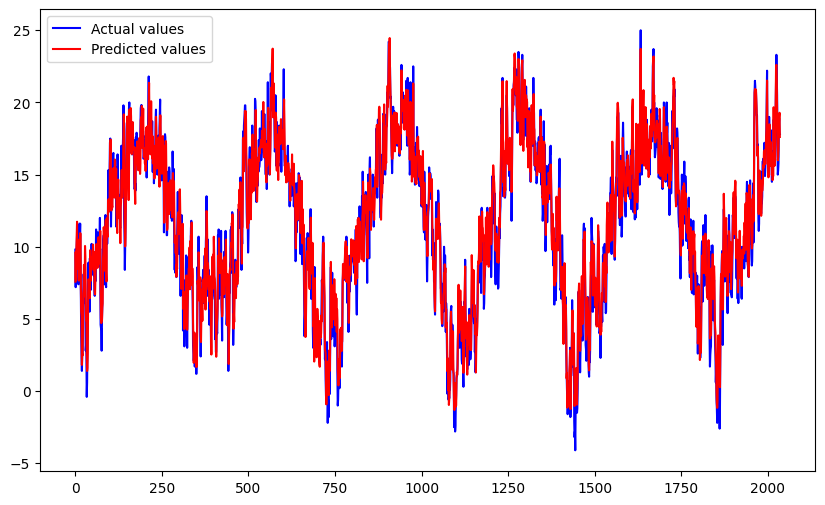

In [36]:

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(478,), learning_rate_init=0.01281173000201371, alpha= 0.9432344163021269, max_iter=500)

# Evaluate the model using 5-fold cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores, mae_scores, r2_scores = [], [], []

for train_index, test_index in tscv.split(X_train):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train[train_index])
    X_test_fold = scaler.transform(X_train[test_index])

    y_train_fold = y_train.iloc[train_index]
    y_test_fold = y_train.iloc[test_index]

    mlp = MLPRegressor(hidden_layer_sizes=(478,), learning_rate_init=0.01281173000201371, alpha=0.9432344163021269, max_iter=500)
    mlp.fit(X_train_fold, y_train_fold)

    y_pred = mlp.predict(X_test_fold)

    mse_scores.append(mean_squared_error(y_test_fold, y_pred))
    mae_scores.append(mean_absolute_error(y_test_fold, y_pred))
    r2_scores.append(r2_score(y_test_fold, y_pred))

print("Cross-validated Mean Squared Error: ", np.mean(mse_scores))
print("Cross-validated Mean Absolute Error: ", np.mean(mae_scores))
print("Cross-validated R² score: ", np.mean(r2_scores))

# Draw a comparison chart of predicted and actual values
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test_fold)), y_test_fold, color='blue', label='Actual values')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted values')
plt.legend()
plt.show()

#### 贝叶斯优化-最佳参数

In [32]:
import torch
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from skorch import NeuralNetRegressor
from sklearn.model_selection import cross_val_score
from pytorch_lightning import LightningModule, Trainer
from torch import nn


# 1. Define the search space
space = {
    'hidden_size': hp.quniform('hidden_size', 1, 500, 1), # for instance, between 1 and 500
    'dropout_rate': hp.uniform('dropout_rate', 0, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1))
}

# 2. Define the objective function
def objective(params):
    hidden_size = int(params['hidden_size'])
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    
    model = create_model(hidden_size, dropout_rate, learning_rate)
    
    # Note: We use a negative mean squared error because hyperopt will try to minimize this value.
    # So a negative value will make it try to maximize the raw mean squared error.
    score = -cross_val_score(model, X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(), cv=3, scoring='neg_mean_squared_error', error_score='raise').mean()
    
    return {
        'loss': score,
        'status': STATUS_OK,
        'params': params
    }

# 3. Optimization methods using hyperopt
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best parameters found: ", best)


  epoch       train_loss    valid_loss     dur         
-------  ---------------  ------------  ------         
      1  5159062052.4402        0.0835  2.2928
      2        0.0841        0.0814  0.2366
      3        0.0836        0.0814  0.2031
      4        0.0836        0.0814  0.1746
      5        0.0836        0.0813  0.1796
      6        0.0836        0.0813  0.1395
      7        0.0836        0.0813  0.1366
      8        0.0835        0.0813  0.1345
      9        0.0835        0.0813  0.1345
     10        0.0835        0.0813  0.1365
  epoch        train_loss    valid_loss     dur        
-------  ----------------  ------------  ------        
      1  20035994227.7583        0.2051  0.1470
      2        0.2283        0.2056  0.1241   
      3        0.2284        0.2056  0.1165            
      4        0.2284        0.2056  0.1295            
      5        0.2284        0.2055  0.1181            
      6        0.2283        0.2055  0.1201            
      7       

      2        0.7655        0.7369  0.1145                              
      3        0.7663        0.7368  0.2580                                       
      4        0.7661        0.7367  0.4596                                       
      5        0.7660        0.7365  0.4477                                       
      6        0.7658        0.7364  0.3887                                       
      7        0.7657        0.7362  0.4979                                       
      8        0.7655        0.7360  0.3661                              
      9        0.7653        0.7358  0.1545                              
     10        0.7650        0.7355  0.1512                              
  epoch      train_loss    valid_loss     dur                                     
-------  --------------  ------------  ------                                     
      1  151824575.1629      238.5747  0.1509                   
      2    88690.0467       89.5234  0.1481               

      6     6236.0301      148.4396  0.1176                               
      7     1799.5722       88.2967  0.1137                      
      8      772.4961       49.3310  0.1149                      
      9      399.3511       29.4343  0.1181                      
     10      249.0265       18.3855  0.1137                      
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  46516262.7483    21227.3474  0.1153                     
      2  5113271.3203     3132.5120  0.1135                      
      3   875198.1432     1294.9011  0.1182                      
      4   155660.8363      262.7519  0.1126                      
      5    25746.8757      195.2644  0.1117                      
      6     4797.7339      131.6011  0.1226                      
      7     1452.5888       76.8426  0.1177                      
      8      622.9435       44.

      8        0.2516        0.2274  0.1850                      
      9        0.2514        0.2273  0.1800                      
     10        0.2513        0.2271  0.1870                      
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  35418107.3615        0.2264  0.1585                     
      2        0.2414        0.2256  0.2000                      
      3        0.2412        0.2255  0.2230                      
      4        0.2411        0.2255  0.2205                      
      5        0.2410        0.2254  0.2090                      
      6        0.2409        0.2253  0.2329                      
      7        0.2408        0.2252  0.2080                      
      8        0.2407        0.2250  0.1910                      
      9        0.2406        0.2249  0.2051                      
     10        0.2404        0.2248  0.1

     10      810.8521       21.6490  0.2580                      
  epoch       train_loss    valid_loss     dur                                     
-------  ---------------  ------------  ------                                     
      1  2265171825.1492        0.1539  0.2850                   
      2        0.1536        0.1529  0.2976                      
      3        0.1546        0.1500  0.2770                               
      4        0.1534        0.1500  0.3045                      
      5        0.1534        0.1500  0.2875                      
      6        0.1534        0.1500  0.2725                      
      7        0.1534        0.1500  0.2595                      
      8        0.1533        0.1499  0.2835                      
      9        0.1533        0.1499  0.2890                      
     10        0.1533        0.1499  0.2645                      
  epoch       train_loss    valid_loss     dur                                     
-------  ----

  epoch    train_loss    valid_loss     dur                                         
-------  ------------  ------------  ------                                         
      1     3448.1137        0.0407  0.1900                       
      2        0.0348        0.0404  0.1770                       
      3        0.0344        0.0399  0.1705                       
      4        0.0340        0.0393  0.1740                       
      5        0.0336        0.0387  0.1920                       
      6        0.0330        0.0380  0.1520                       
      7        0.0325        0.0373  0.1675                       
      8        0.0320        0.0366  0.1555                       
      9        0.0314        0.0359  0.1590                       
     10        0.0309        0.0351  0.2520                       
  epoch    train_loss    valid_loss     dur                                         
-------  ------------  ------------  ------                                

-------  -------------  ------------  ------                                       
      1  11273466.0833      660.6221  0.3105                     
      2   332293.9473      523.7156  0.2916                      
      3    40243.0347      128.7905  0.2560                      
      4    12080.2532       48.7579  0.2794                      
      5     5268.8365       27.1465  0.2961                      
      6     2749.7856       19.3474  0.2586                      
      7     1555.8079       15.3559  0.2766                      
      8      950.9607       11.3896  0.2460                      
      9      620.5671        9.7184  0.2715                      
     10      413.9034        8.4741  0.2845                      
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1  2747131.8694        0.2995  0.2270                      
      2        0.3044 

      2        0.1230        0.1211  0.3030                      
      3        0.1227        0.1211  0.2908                      
      4        0.1227        0.1211  0.3224                      
      5        0.1227        0.1211  0.3079                      
      6        0.1227        0.1211  0.2962                      
      7        0.1227        0.1211  0.3119                      
      8        0.1227        0.1210  0.2830                      
      9        0.1227        0.1210  0.2811                      
     10        0.1227        0.1210  0.2901                      
  epoch       train_loss    valid_loss     dur                                     
-------  ---------------  ------------  ------                                     
      1  5634427129.1359    76395.5152  0.2695                   
      2    44426.0674       96.6301  0.2724                      
      3     8429.9378      151.2078  0.2533                               
      4     3978.3307       87.

      4        1.5103        1.4475  0.1894                      
      5        1.5098        1.4470  0.1888                      
      6        1.5092        1.4465  0.2356                      
      7        1.5086        1.4458  0.2201                      
      8        1.5079        1.4451  0.2353                      
      9        1.5072        1.4444  0.2214                      
     10        1.5064        1.4436  0.2056                      
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1  4118867.5551        1.4468  0.2062                      
      2        1.4880        1.4462  0.2012                      
      3        1.4876        1.4459  0.1994                      
      4        1.4872        1.4455  0.1930                      
      5        1.4868        1.4450  0.1853                      
      6        1.4863        1.4445  0.2

      6        1.0295        0.9951  0.3205                                        
      7        1.0294        0.9951  0.2850                                        
      8        1.0294        0.9950  0.2570                                        
      9        1.0293        0.9949  0.2489                                        
     10        1.0292        0.9949  0.2852                                        
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  11979019.0289    22397.1845  0.2483                     
      2  4310864.2888    66883.5767  0.2511                               
      3  1612023.7523     3713.8748  0.2342                      
      4   613238.4244     4387.9777  0.3117                               
      5   250066.7786     3009.3748  0.2410                      
      6   106717.6254     1136.2226  0.2785                     

      8        0.4352        0.2510  0.2988                      
      9        0.3992        0.2489  0.3164                      
     10        0.3825        0.2478  0.3092                      
  epoch      train_loss    valid_loss     dur                                      
-------  --------------  ------------  ------                                      
      1  203551190.1253        0.2377  0.2598                    
      2        0.2625        0.2378  0.2641                               
      3        0.2625        0.2377  0.3038                               
      4        0.2625        0.2377  0.2949                               
      5        0.2625        0.2377  0.2791                      
      6        0.2624        0.2376  0.2615                      
      7        0.2624        0.2376  0.2847                      
      8        0.2623        0.2375  0.2743                      
      9        0.2623        0.2375  0.2675                      
     10      

     10        0.3935        0.3403  0.2291                               
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1  7934603.1297        0.3428  0.2083                      
      2        0.3623        0.3426  0.2252                      
      3        0.3622        0.3425  0.2206                      
      4        0.3620        0.3423  0.1993                      
      5        0.3618        0.3421  0.2304                      
      6        0.3616        0.3419  0.2191                      
      7        0.3614        0.3416  0.2231                      
      8        0.3611        0.3414  0.2266                      
      9        0.3608        0.3411  0.2880                      
     10        0.3605        0.3408  0.2515                      
  epoch      train_loss    valid_loss     dur                                      
-------  ----

-------  ------------  ------------  ------                                        
      1  1980665.5770        1.1753  0.2508                      
      2        1.1858        1.1738  0.2024                      
      3        1.1823        1.1694  0.1989                      
      4        1.1774        1.1641  0.1535                      
      5        1.1717        1.1581  0.1583                      
      6        1.1652        1.1513  0.1809                      
      7        1.1581        1.1439  0.1780                      
      8        1.1504        1.1359  0.1865                      
      9        1.1421        1.1274  0.2026                      
     10        1.1333        1.1183  0.1727                      
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1  1514906.0112        1.1185  0.2199                      
      2        1.1731 

      2        1.5862        1.5214  0.2052                      
      3        1.5844        1.5193  0.2040                      
      4        1.5821        1.5168  0.2103                      
      5        1.5794        1.5139  0.1978                      
      6        1.5763        1.5107  0.2149                      
      7        1.5728        1.5072  0.1972                      
      8        1.5691        1.5034  0.2259                      
      9        1.5650        1.4993  0.1845                      
     10        1.5607        1.4949  0.2130                      
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1   786857.9009        1.5187  0.2242                      
      2        1.5611        1.5179  0.2176                      
      3        1.5596        1.5161  0.1949                      
      4        1.5577        1.5140  0.2

      4        0.4521        0.4311  0.3073                      
      5        0.4532        0.4310  0.2839                               
      6        0.4525        0.4308  0.2665                               
      7        0.4520        0.4307  0.2150                      
      8        0.4532        0.4305  0.2010                               
      9        0.4520        0.4303  0.1940                               
     10        0.4521        0.4301  0.1817                               
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  37228506.5357        0.3970  0.1907                     
      2        0.4030        0.3965  0.2002                      
      3        0.4023        0.3962  0.2005                      
      4        0.4020        0.3958  0.1956                      
      5        0.4016        0.3954  0.1850                  

      6        0.0241        0.0243  0.2195                      
      7        0.0241        0.0243  0.2511                               
      8        0.0241        0.0243  0.2664                               
      9        0.0241        0.0243  0.2506                               
     10        0.0241        0.0243  0.2351                               
  epoch    train_loss    valid_loss     dur                                        
-------  ------------  ------------  ------                                        
      1        0.0262        0.0263  0.2355                      
      2        0.0248        0.0254  0.2195                      
      3        0.0246        0.0253  0.2195                      
      4        0.0246        0.0252  0.2668                      
      5        0.0246        0.0252  0.2695                      
      6        0.0246        0.0252  0.2046                      
      7        0.0246        0.0252  0.2506                           

      8      793.2333       34.8773  0.2606                      
      9      443.6326       27.3850  0.2711                      
     10      259.6256       21.2864  0.3115                      
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  10691607.5236   154790.1878  0.2692                     
      2   933179.2844     2157.5500  0.3066                      
      3   150883.7373      920.3554  0.2998                      
      4    35301.4707      683.8306  0.2847                      
      5    10654.9910       85.3617  0.3022                      
      6     3731.3150       69.0441  0.2604                      
      7     1720.9367       63.5628  0.2787                      
      8      877.3074       41.6810  0.2639                      
      9      518.8702       33.1994  0.2926                      
     10      298.3024       26.5379  0.2

     10    28944.6777     1931.6672  0.2547                               
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  12721738.1423     5352.1620  0.2059                     
      2     6569.6155       47.6602  0.2637                      
      3      130.8793       44.2247  0.2042                      
      4       63.3225       24.4815  0.2314                      
      5       30.6362       11.8936  0.2199                      
      6       13.2118        5.4292  0.2217                      
      7        6.2178        2.5688  0.2104                      
      8        3.0612        1.3782  0.2227                      
      9        1.7420        0.8950  0.2638                      
     10        1.2397        0.6703  0.1884                      
  epoch     train_loss    valid_loss     dur                                       
-------  ----

-------  -------------  ------------  ------                                       
      1  43226340.0410        0.3391  0.2690                     
      2        0.3688        0.3389  0.2613                      
      3        0.3687        0.3388  0.2535                      
      4        0.3686        0.3387  0.2390                      
      5        0.3685        0.3386  0.2947                      
      6        0.3684        0.3385  0.2908                      
      7        0.3682        0.3384  0.2523                      
      8        0.3681        0.3382  0.2350                      
      9        0.3679        0.3381  0.2694                      
     10        0.3678        0.3379  0.2713                      
  epoch     train_loss    valid_loss     dur                                       
-------  -------------  ------------  ------                                       
      1  19230007.8320        0.3581  0.2621                     
      2        0.3783 

Cross-validated Mean Squared Error:  9.974654300215786
Cross-validated Mean Absolute Error:  1.9760818565248168
Cross-validated R² score:  0.683320207120362
Mean Squared Error on test set:  1.7743246197677423
Mean Absolute Error on test set:  0.9848727940849279
R² score on test set:  0.9446236923948702


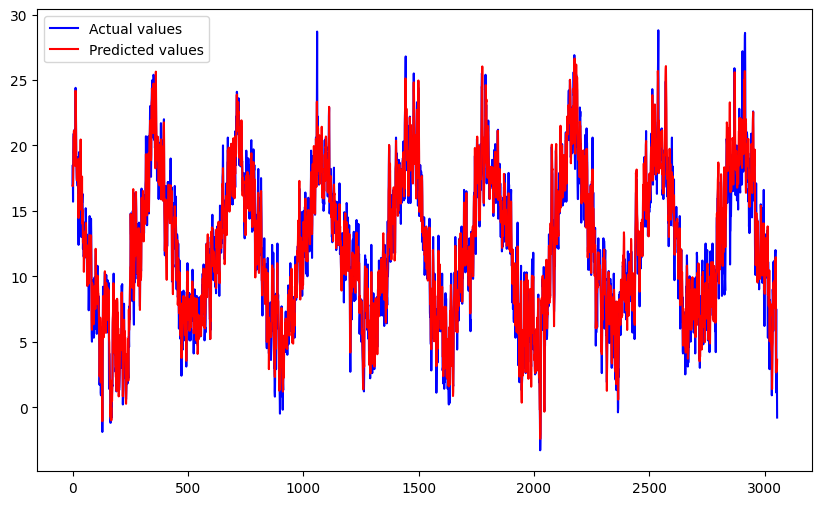

In [37]:


# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.005860677282939478, alpha=0.4380931027530852, max_iter=500)

from sklearn.model_selection import TimeSeriesSplit

# Assuming you've already defined and preprocessed your data and loaded necessary libraries

# For time series, we use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation
scores_mse = []
scores_mae = []
scores_r2 = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    mlp.fit(X_train_fold, y_train_fold)
    
    predictions_fold = mlp.predict(X_test_fold)
    scores_mse.append(mean_squared_error(y_test_fold, predictions_fold))
    scores_mae.append(mean_absolute_error(y_test_fold, predictions_fold))
    scores_r2.append(r2_score(y_test_fold, predictions_fold))

print("Cross-validated Mean Squared Error: ", np.mean(scores_mse))
print("Cross-validated Mean Absolute Error: ", np.mean(scores_mae))
print("Cross-validated R² score: ", np.mean(scores_r2))

# Training the model on the complete training set
mlp.fit(X_train, y_train)

# Predictions on the test set
predictions = mlp.predict(X_test)

# Evaluation on the test set
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error on test set: ", mse)
print("Mean Absolute Error on test set: ", mae)
print("R² score on test set: ", r2)

# Visualization
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicted values')
plt.legend()
plt.show()



#### 使用贝叶斯优化的最佳参数表现明显好于遗传算法

#### 不同期限的预测精度，1天，3天，7天和14天

In [11]:
periods = [1, 3, 7, 14]
models = {}  # To store trained models for each period
results = {}  # To store results for each period

for period in periods:
    print(f"Training model for a forecast period of {period} days...")
    
    # Shift the target column to create future targets
    y_train_shifted = y_train.shift(-period).dropna()
    y_test_shifted = y_test.shift(-period).dropna()
    X_train_period = X_train[:-period]
    X_test_period = X_test[:-period]

    # Scaling the features
    scaler = StandardScaler()
    X_train_period = scaler.fit_transform(X_train_period)
    X_test_period = scaler.transform(X_test_period)
    
    # Define and train the MLP model
    mlp = MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.005860677282939478, alpha=0.4380931027530852, max_iter=500)
    mlp.fit(X_train_period, y_train_shifted)

    # Store the trained model
    models[period] = mlp

    # Predict and evaluate
    y_train_pred = mlp.predict(X_train_period)
    y_test_pred = mlp.predict(X_test_period)

    mse_train = mean_squared_error(y_train_shifted, y_train_pred)
    mse_test = mean_squared_error(y_test_shifted, y_test_pred)
    mae_train = mean_absolute_error(y_train_shifted, y_train_pred)
    mae_test = mean_absolute_error(y_test_shifted, y_test_pred)
    r2_train = r2_score(y_train_shifted, y_train_pred)
    r2_test = r2_score(y_test_shifted, y_test_pred)

    results[period] = {
        "Train MSE": mse_train,
        "Test MSE": mse_test,
        "Train MAE": mae_train,
        "Test MAE": mae_test,
        "Train R^2": r2_train,
        "Test R^2": r2_test
    }

    print(f"Period: {period} days")
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    print(f"Train MAE: {mae_train}, Test MAE: {mae_test}")
    print(f"Train R^2: {r2_train}, Test R^2: {r2_test}")
    print("--------------------")

Training model for a forecast period of 1 days...
Period: 1 days
Train MSE: 3.294712619527808, Test MSE: 4.174365153801539
Train MAE: 1.439791177448162, Test MAE: 1.6075768081099813
Train R^2: 0.8988967217108301, Test R^2: 0.8697301683995983
--------------------
Training model for a forecast period of 3 days...
Period: 3 days
Train MSE: 6.84024285383445, Test MSE: 8.466680176612828
Train MAE: 2.088394442956276, Test MAE: 2.3019161560550576
Train R^2: 0.7899848399357824, Test R^2: 0.7358091094925836
--------------------
Training model for a forecast period of 7 days...
Period: 7 days
Train MSE: 7.892064174266139, Test MSE: 9.36010135725636
Train MAE: 2.2615577897604813, Test MAE: 2.4415261816353953
Train R^2: 0.7574648755684289, Test R^2: 0.7076014175141003
--------------------
Training model for a forecast period of 14 days...
Period: 14 days
Train MSE: 8.204823649970315, Test MSE: 10.15945847200299
Train MAE: 2.312557960226779, Test MAE: 2.506659190437944
Train R^2: 0.7476350330928969

In [7]:
import pickle
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
mlp = MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.005860677282939478, alpha=0.4380931027530852, max_iter=500)
mlp.fit(X_train, np.ravel(y_train))

MLPRegressor(alpha=0.4380931027530852, hidden_layer_sizes=(3,),
             learning_rate_init=0.005860677282939478, max_iter=500)

In [8]:
def predict_future(df, model, window, days_ahead, scaler):
    future_predictions = []
    df_copy = df.copy()
    for _ in range(days_ahead):
        # Create lag data
        lagged_data = create_lagged_features(df_copy, window, target_column)
        
        # predict a value in the future using the last window of data
        last_window = lagged_data.iloc[-1].values.reshape(1, -1)
        last_window_scaled = scaler.transform(last_window)
        next_value = model.predict(last_window_scaled)
        future_predictions.append(next_value[0])
        
        # Update df_copy, add predicted values, and prepare for the next prediction
        next_row = df_copy.iloc[-1].copy()
        next_row[target_column] = next_value
        df_copy = pd.concat([df_copy, pd.DataFrame([next_row])], ignore_index=True)
    
    return future_predictions
# Predict future dates
days_to_predict = [1, 3, 7, 14]
for days in days_to_predict:
    predictions = predict_future(data_weather_encoded, mlp, window, days, scaler)
    print(f"Predictions for the next {days} days: {predictions}")


with open("ann_future_predictions.pkl", "wb") as file:
    pickle.dump(predictions, file)


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 1 days: [2.4821840489963165]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 3 days: [2.4821840489963165, 0.7061469714999644, 0.3005159485590294]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 7 days: [2.4821840489963165, 0.7061469714999644, 0.3005159485590294, 0.41398043416182695, 0.607267980181251, -0.13526898041099322, 0.05000749342704669]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 14 days: [2.4821840489963165, 0.7061469714999644, 0.3005159485590294, 0.41398043416182695, 0.607267980181251, -0.13526898041099322, 0.05000749342704669, 0.4885044596819501, 0.10565047335953004, 0.21414956942202412, 0.19673619179626556, -0.01726702719639661, -0.14576728280179196, 0.20270602357178014]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
import pickle

with open("ann_future_predictions.pkl", "rb") as file:
    predictions = pickle.load(file)


In [10]:
predictions

[2.4821840489963165,
 0.7061469714999644,
 0.3005159485590294,
 0.41398043416182695,
 0.607267980181251,
 -0.13526898041099322,
 0.05000749342704669,
 0.4885044596819501,
 0.10565047335953004,
 0.21414956942202412,
 0.19673619179626556,
 -0.01726702719639661,
 -0.14576728280179196,
 0.20270602357178014]